#Explanation
##Why MFCC
[Juan I. Godino-Llorente, et al](https://pdfs.semanticscholar.org/bbeb/d259f824703a6efa82f5eefce6f42da37b7d.pdf) concluded MFCC works better than LPC and LPCC. They managed to get 100% of accuracy to identify voice impairment.

[Leena R Mehta et al](https://www.ijareeie.com/upload/june/9_COMPARATIVE.pdf) MFCC provided 99.5 to 99.75% of accuracy for isolated word recognition system. As a contrast LPC only provided 78.5% to 76.25%. 

[Olla Eltiraif et al](https://ieeexplore.ieee.org/document/8515821) MFCC provided similar test error rate when compare to LPCC. Altough LPCC is slightly accurate than MFCC. But the trainning time of MFCC is faster then LPC. 

[Taabish Gulzar et al](https://www.researchgate.net/publication/284453088_Comparative_Analysis_of_LPCC_MFCC_and_BFCC_for_the_Recognition_of_Hindi_Words_using_Artificial_Neural_Networks) This paper compared MFCC, LPCC and BFCC feature for recognition of hindi words using ANN. MFCC has the better recognition rate which are 99.78% for isolated, 99.88% for paired and 99.82% for Hybrid words.

# Preparation

Download processed data

In [0]:
!rm -rf Stuttered-Data

In [2]:
!git clone 'https://github.com/ming0520/Stuttered-Data.git'

Cloning into 'Stuttered-Data'...
remote: Enumerating objects: 2916, done.
remote: Counting objects: 100% (2916/2916), done.
remote: Compressing objects: 100% (2915/2915), done.
remote: Total 2916 (delta 3), reused 2914 (delta 1), pack-reused 0
Receiving objects: 100% (2916/2916), 21.70 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Install dependencies

In [3]:
!pip install colorlog
!pip install --upgrade librosa
!pip search librosa

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp36-none-any.whl size=1612885 sha256=39ea7f46167c24d1f8e46428fd77e6391d4f9c7159e231f54fdde39f107c04bd
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
librosa (0.7.2)                - Python module for audio and music processing
  INSTALLED: 0.7.2 (latest)
torchlibrosa (0.0.4)           - PyTorch implemention of part of librosa functions.
explibrosa (0.0.0.dev1)        - A tool to analyse and convert data coming from the Librosa python package.
signal-transformation (2.1.1)  - The package allows performing a transformation of an audio signal using TensorFlow or LibROSA


Import library

In [0]:
from IPython.display import Audio

import librosa # to load audio
import glob # to load file like linux
import librosa.display # display spectrogram and mfcc module
import numpy as np # support librosa and create array

import matplotlib.pyplot as plt #plotting module to support librosa

import os
import sys
import re
import shutil # to remove child directory and file
import datetime
import logging
import colorlog #for logger
import progressbar

In [0]:
import time
import tqdm.notebook as tq # a progressbar in colab notebook

In [0]:
# Setting up progressbar and logger
progressbar.streams.wrap_stderr()
logger = colorlog.getLogger("ASSR")
handler = logging.StreamHandler()
handler.setFormatter(colorlog.ColoredFormatter('%(log_color)s%(levelname)-8s| %(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)

## Data Processing

Load the data

In [14]:
DATA_PATH = f'Stuttered-Data/20200708_Standard'
NORMAL_AUDIOS = glob.glob(f'./{DATA_PATH}/NORMAL/*.wav')
STUTTERED_AUDIOS = glob.glob(f'./{DATA_PATH}/STUTTERED/*.wav')
failed_list = []
print(len(NORMAL_AUDIOS))
print(len(STUTTERED_AUDIOS))
print(NORMAL_AUDIOS[1].split('/')[4].split('.wav')[0])

1326
124
001147-with


Load the class

In [0]:
class FeatureExtraction:
    def __init__(self, n_mels=128):
        self.n_mels = n_mels
        self.y = None
        self.sr = None
        self.S = None
        self.log_S = None
        self.mfcc = None
        self.delta_mfcc = None
        self.delta2_mfcc = None
        self.M = None
        self.rmse = None
        self.filename = None
    
    def loadFile(self, filename):
        self.filename=filename
        self.y, self.sr = librosa.load(filename)
        logger.debug('File loaded: %s', filename)
    
    def load_y_sr(self, y, sr):
        self.y = y
        self.sr = sr
    
    def melspectrogram(self):
        self.S = librosa.feature.melspectrogram(self.y, sr=self.sr, n_mels=self.n_mels)
        self.log_S = librosa.amplitude_to_db(self.S)
    
    def plotmelspectrogram(self):
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(self.log_S, sr=self.sr, x_axis='time', y_axis='mel')
        plt.title(f'mel Power Spectrogram ({self.filename})')
        plt.colorbar(format='%+02.0f dB')
        plt.tight_layout()
    
    def extractmfcc(self, n_mfcc=13):
        self.mfcc = librosa.feature.mfcc(S=self.log_S, n_mfcc=n_mfcc)
        self.delta_mfcc = librosa.feature.delta(self.mfcc,mode='nearest')
        self.delta2_mfcc = librosa.feature.delta(self.mfcc, order=2,mode='nearest')
        self.M = np.vstack([self.mfcc, self.delta_mfcc, self.delta2_mfcc])
    
    def plotmfcc(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(3, 1, 1)
        librosa.display.specshow(self.mfcc)
        plt.title(f'mel Power Spectrogram ({self.filename})')
        plt.ylabel('MFCC')
        plt.colorbar()
        
        plt.subplot(3, 1, 2)
        librosa.display.specshow(self.delta_mfcc)
        plt.title(f'mel Power Spectrogram ({self.filename})')
        plt.ylabel('MFCC-$\Delta$')
        plt.colorbar()
        
        plt.subplot(3, 1, 3)
        librosa.display.specshow(self.delta2_mfcc, sr=self.sr, x_axis='time')
        plt.title(f'mel Power Spectrogram ({self.filename})')
        plt.ylabel('MFCC-$\Delta^2$')
        plt.colorbar()
        
        plt.tight_layout()
    
    def extractrmse(self):
        self.rmse = librosa.feature.rmse(y=self.y)

Create an empty list for feature object in this case is various mfcc

In [0]:
mfcc_objects = []

Create the mfcc_object list and append mfcc object

In [0]:
for audio in STUTTERED_AUDIOS:
  mfcc_object = FeatureExtraction()
  mfcc_object.loadFile(f'{audio}')
  mfcc_objects.append(mfcc_object)

Calculate the MFCC, MFCC delta, MFCC delta 2
Then plot the Spectrogram, MFCC, MFCC Delta, MFCC delta2

limit can control the maximum graph required

I saved all the feature graph in my local machine

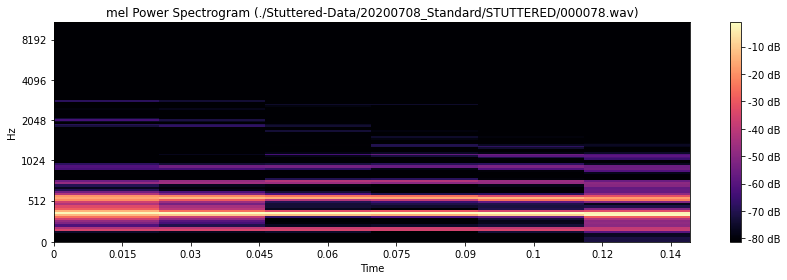

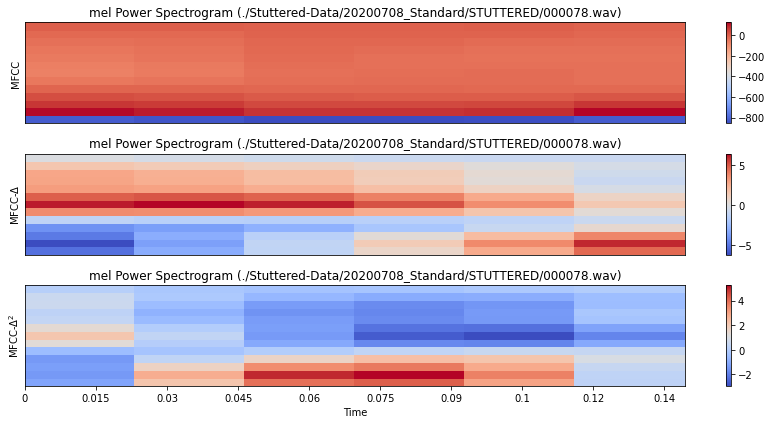

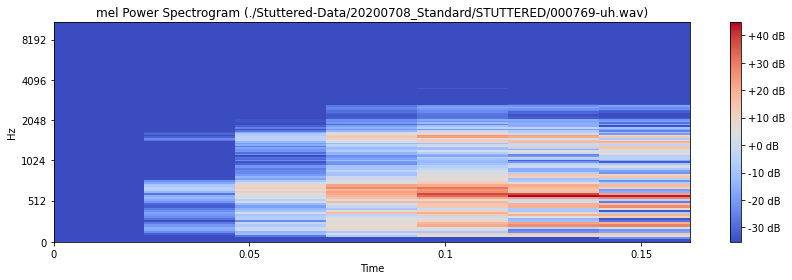

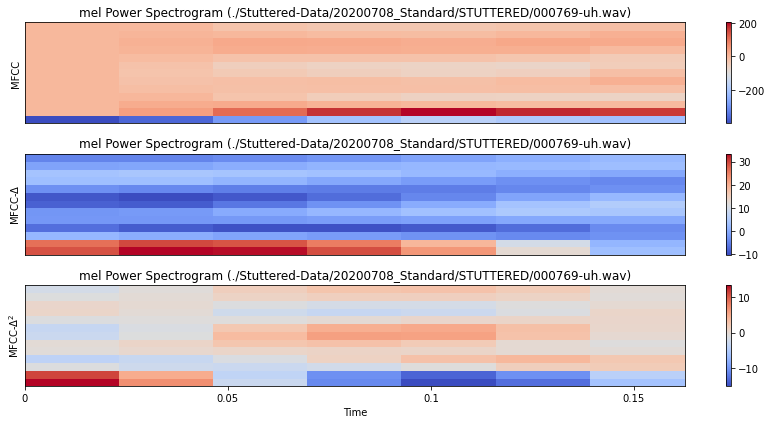

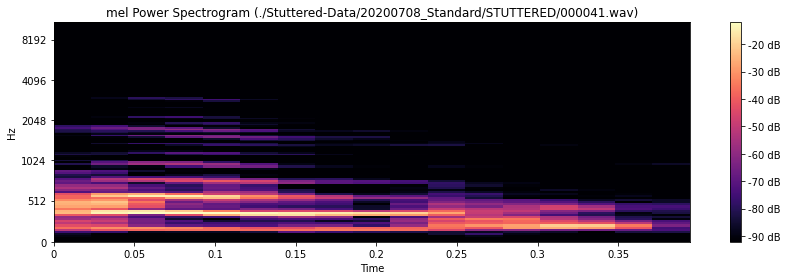

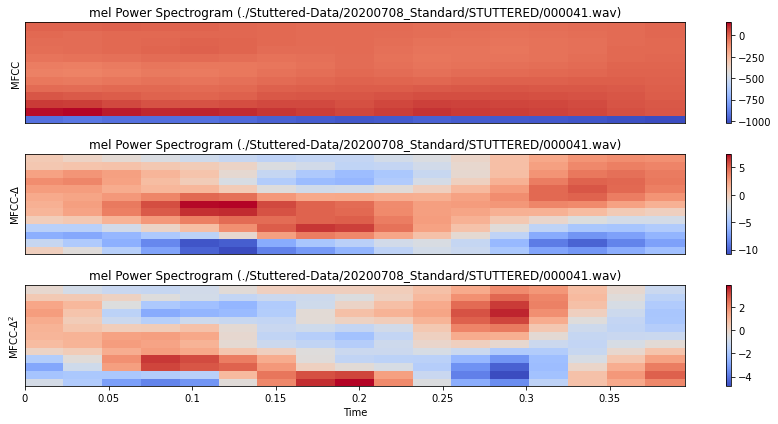

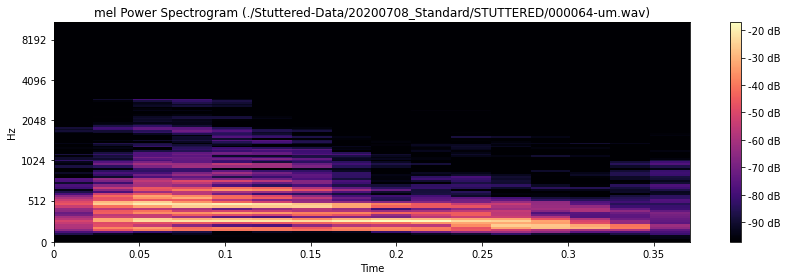

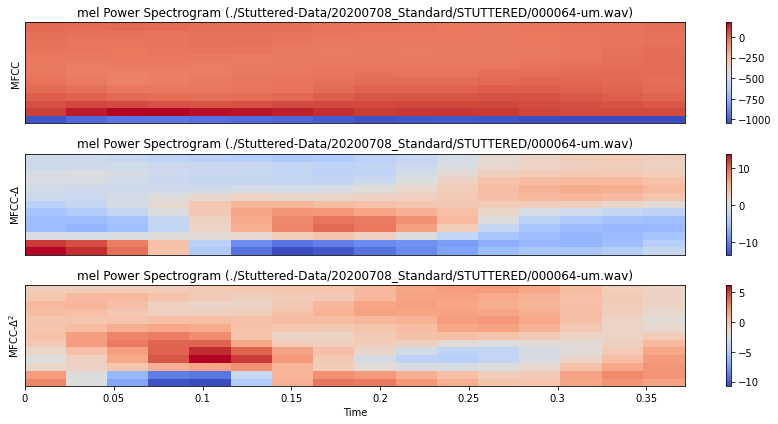

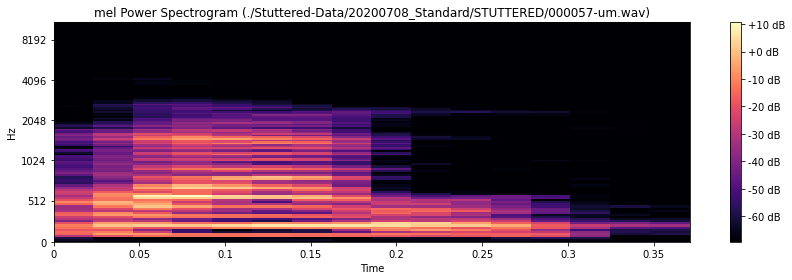

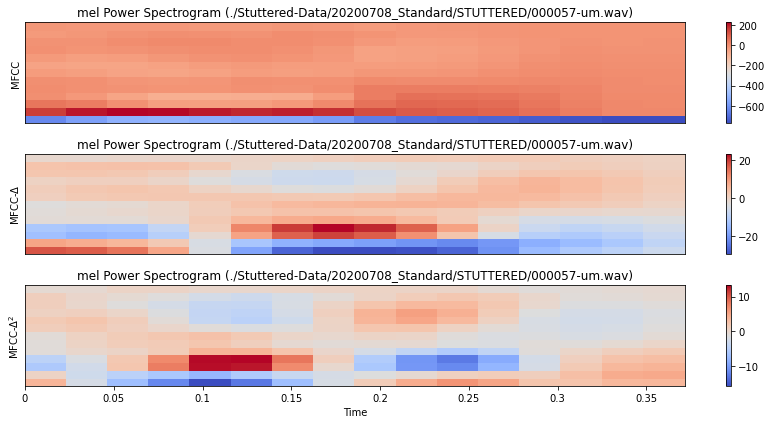

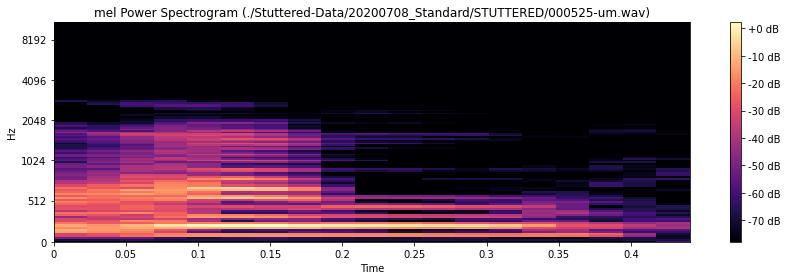

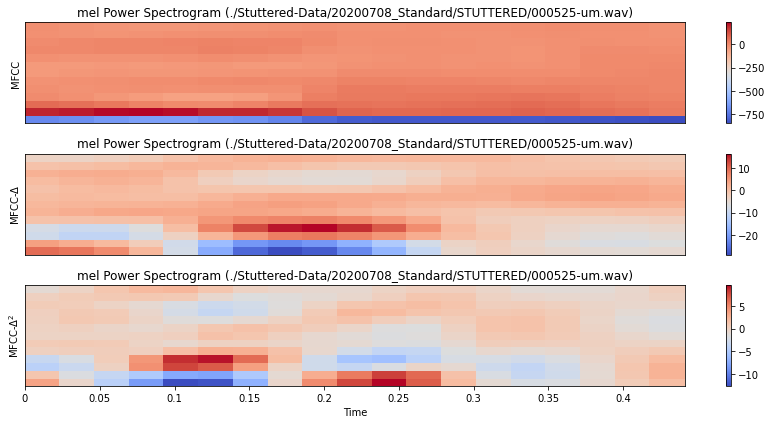

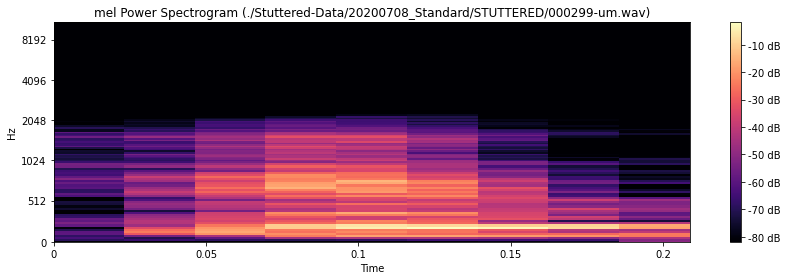

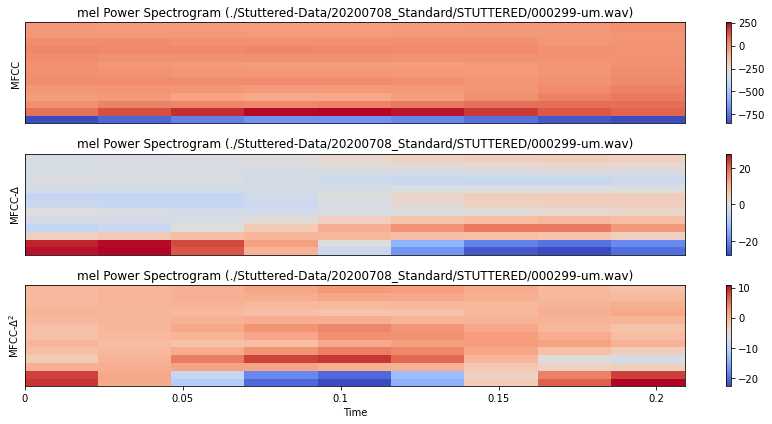

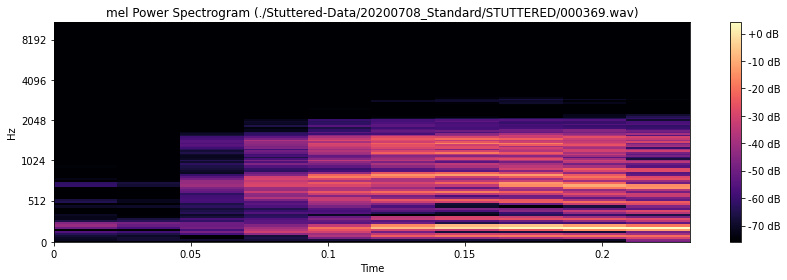

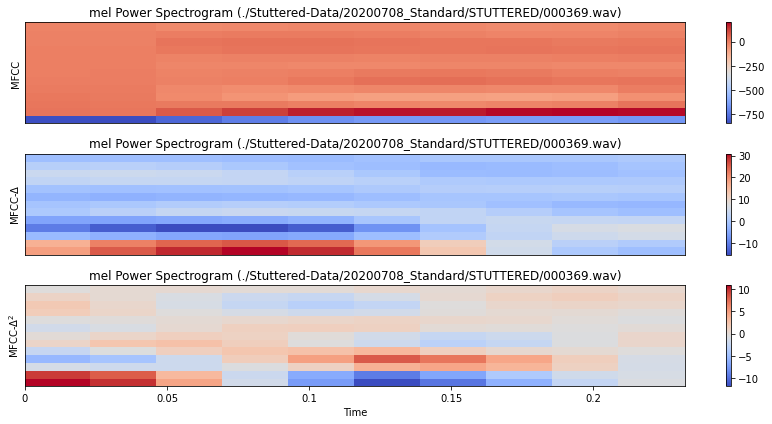

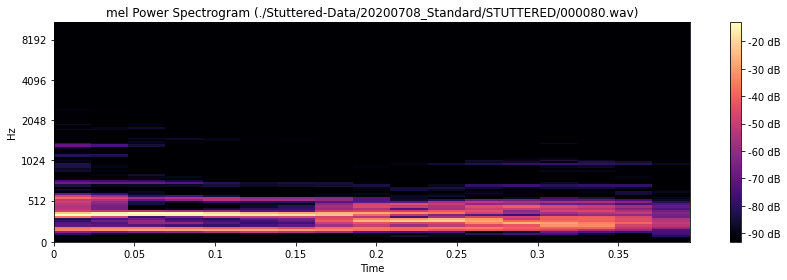

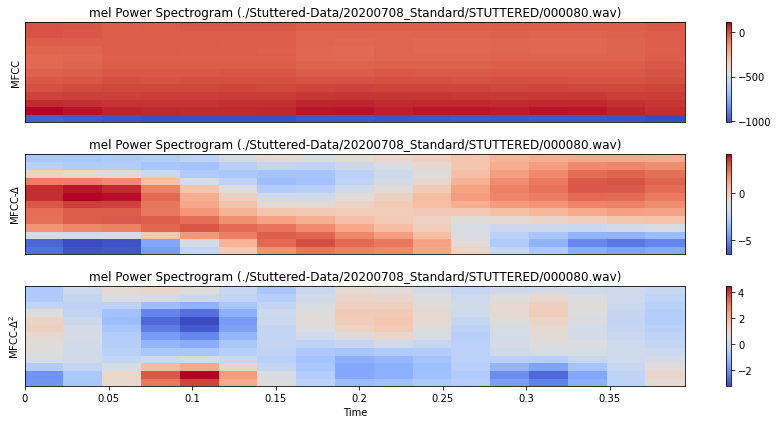

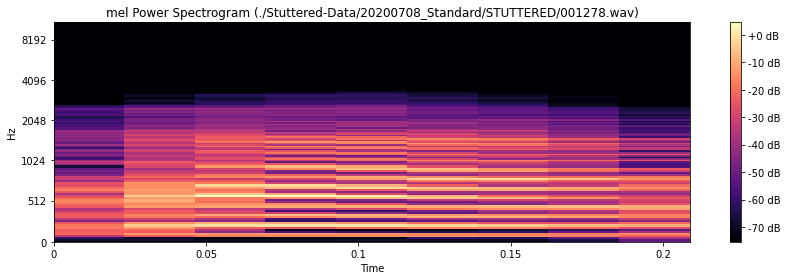

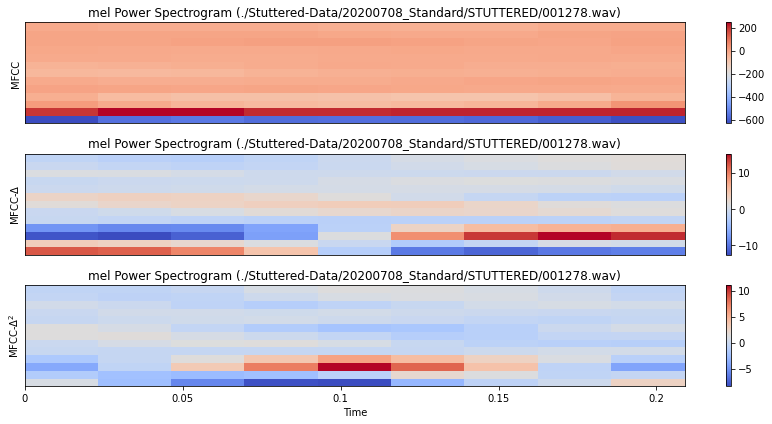

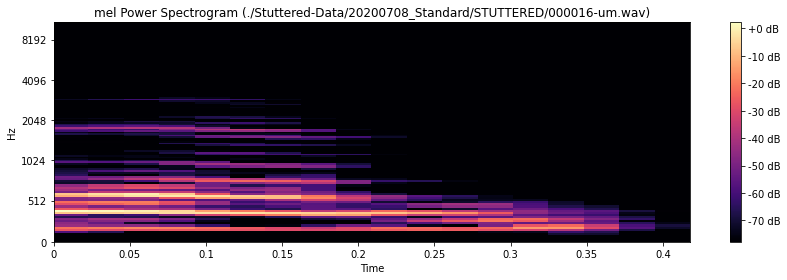

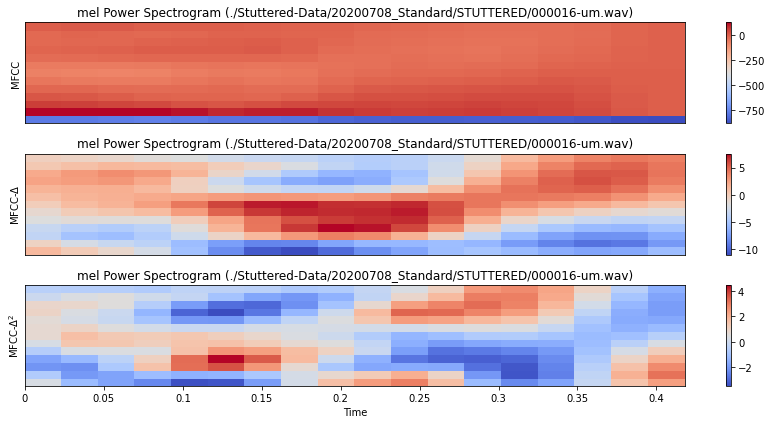

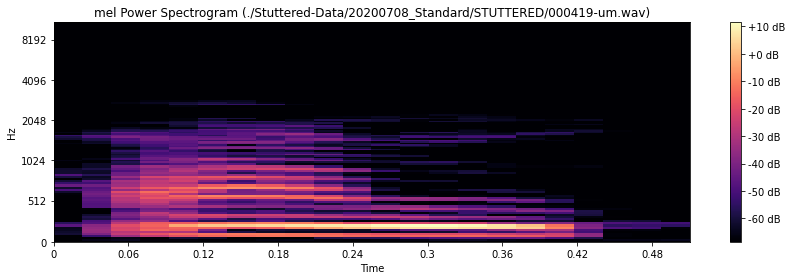

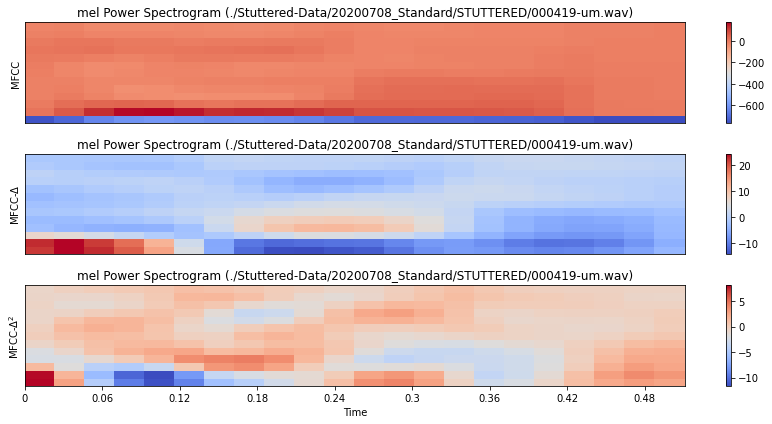

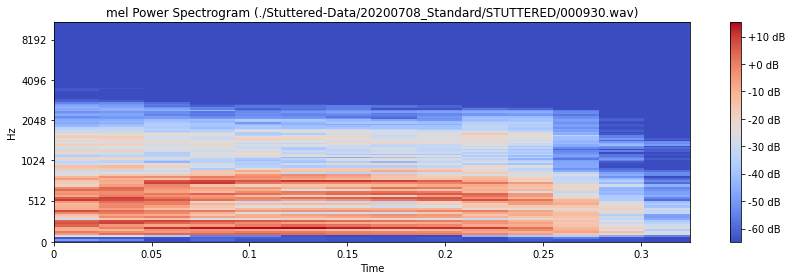

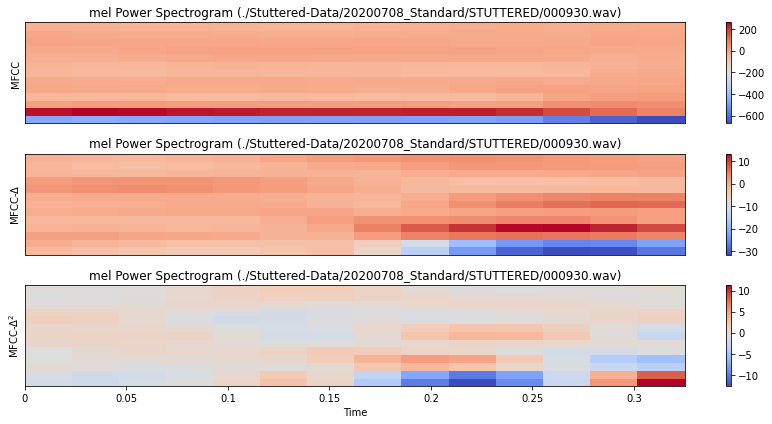

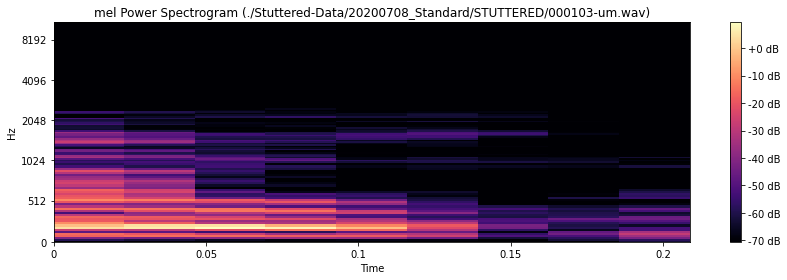

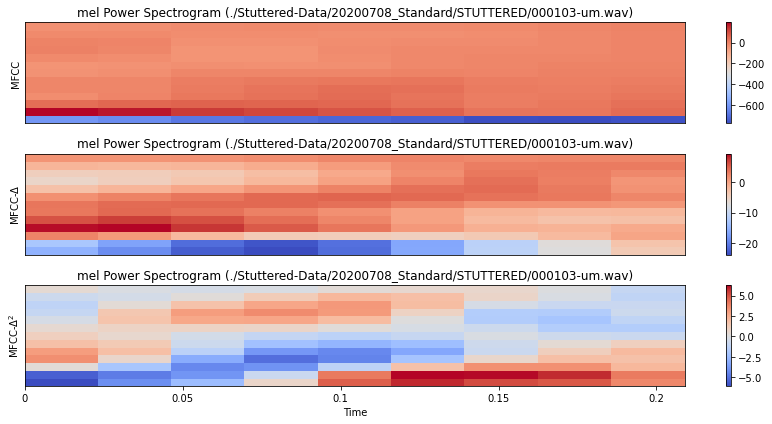

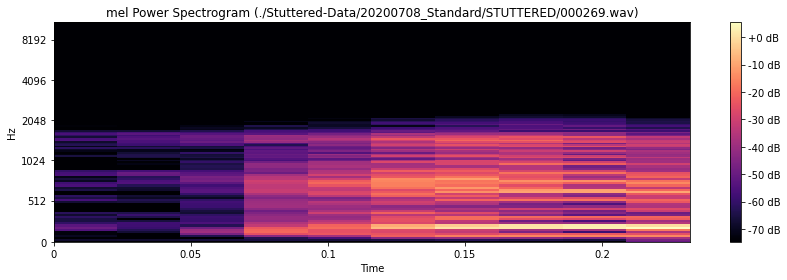

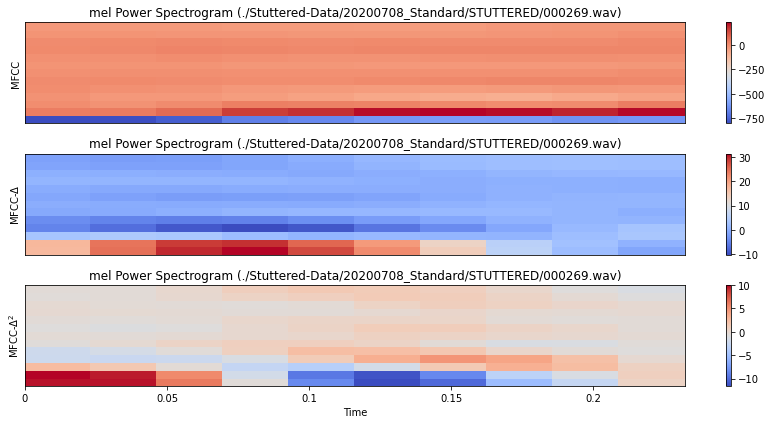

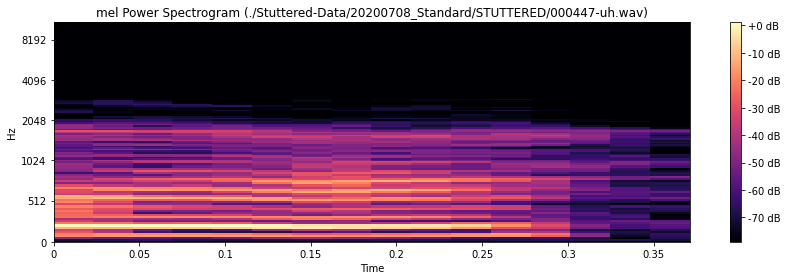

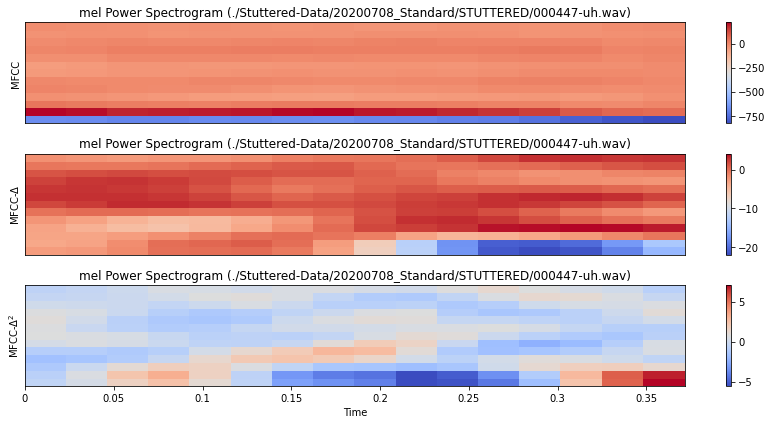

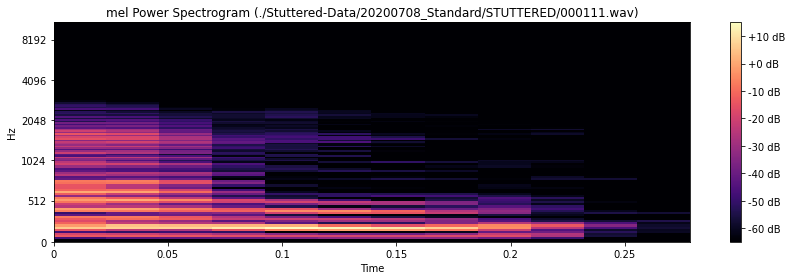

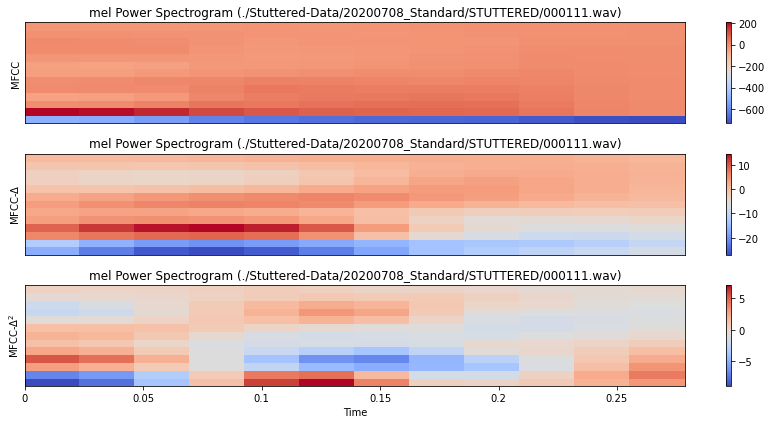

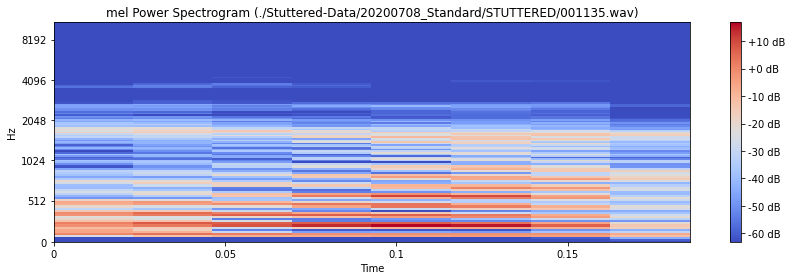

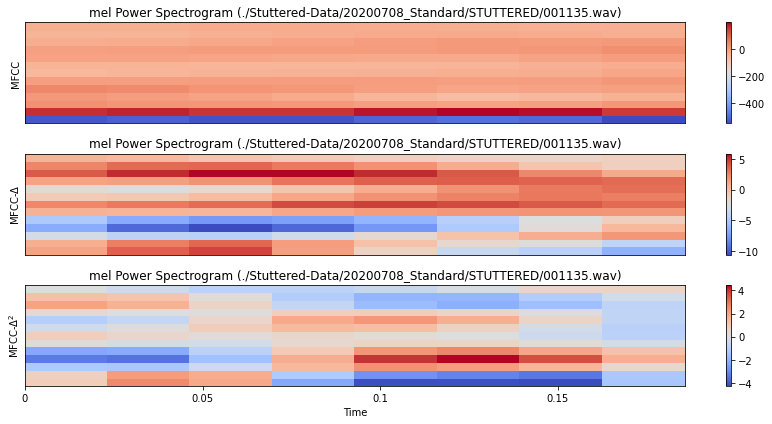

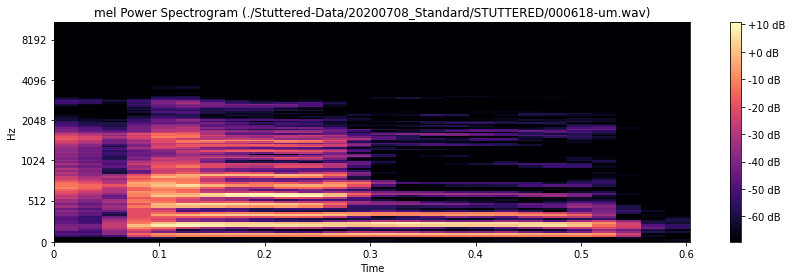

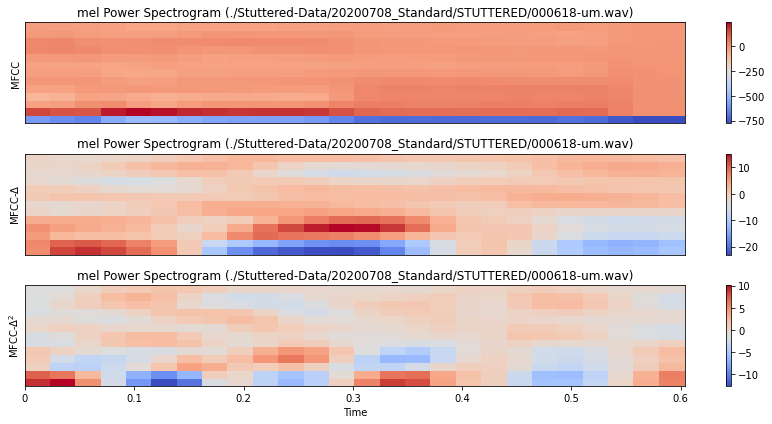

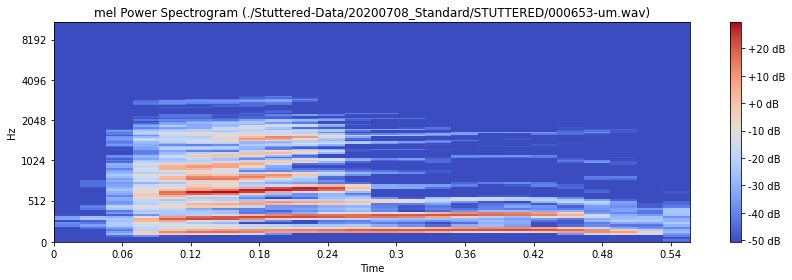

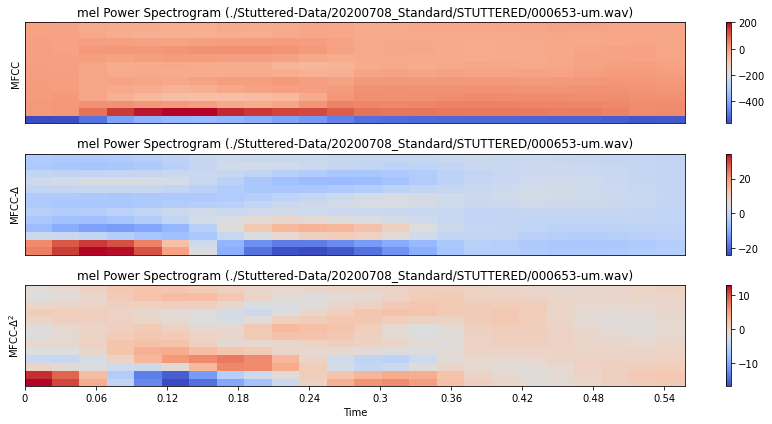

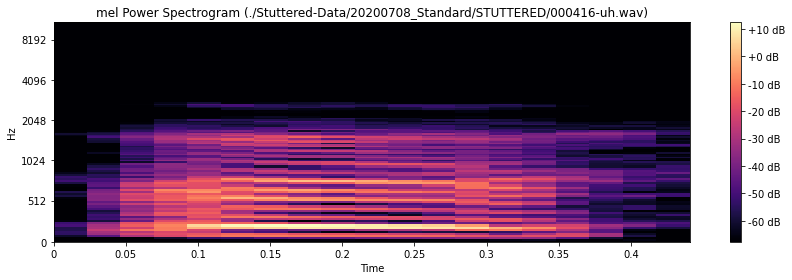

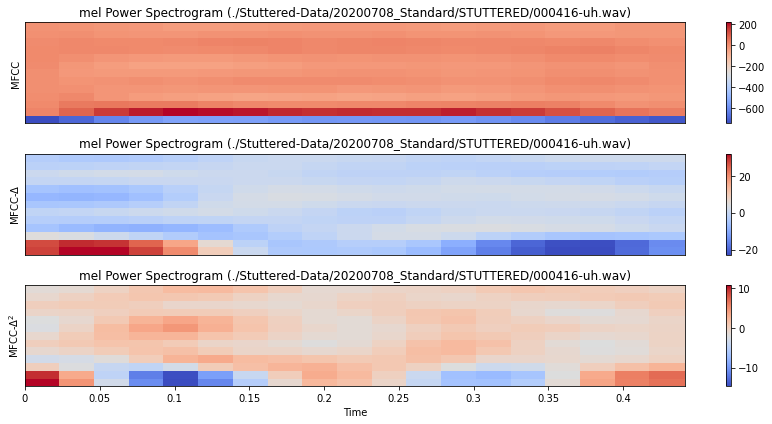

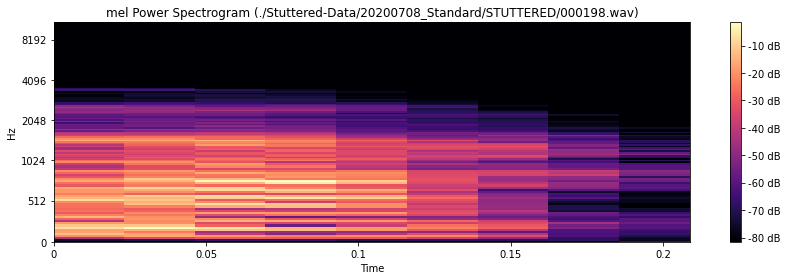

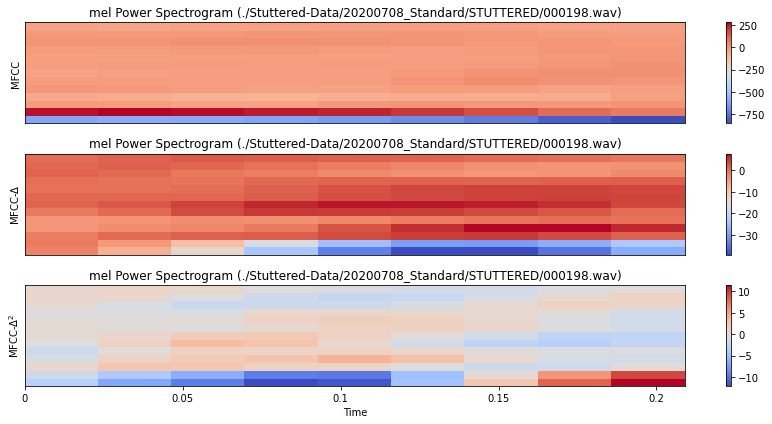

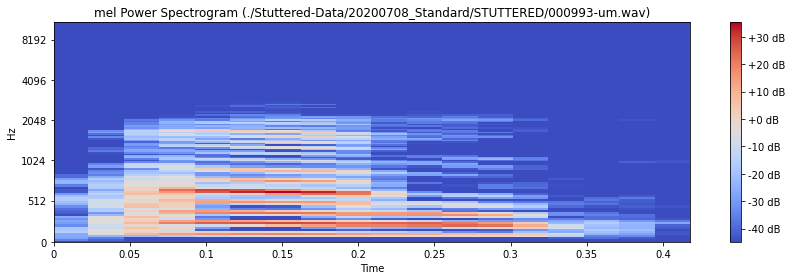

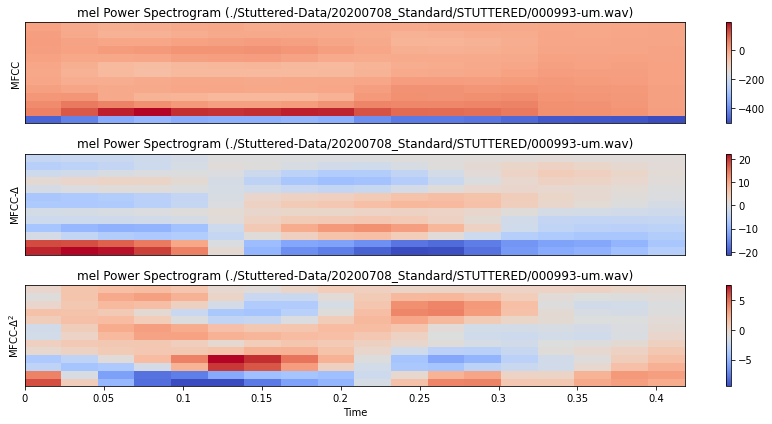

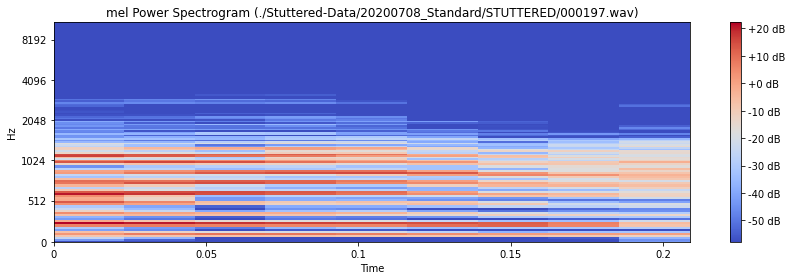

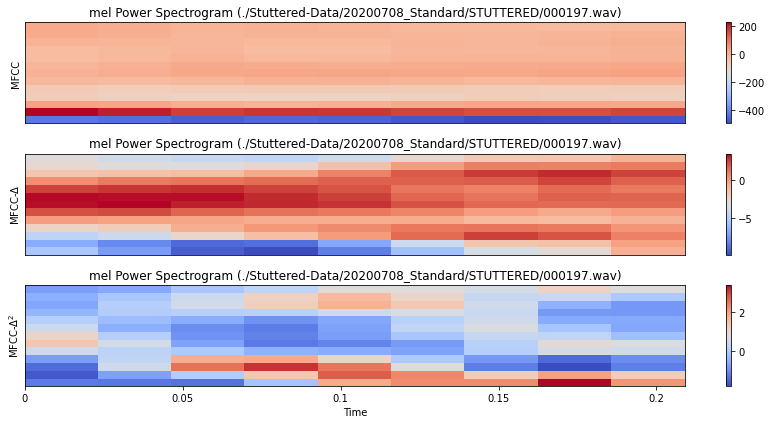

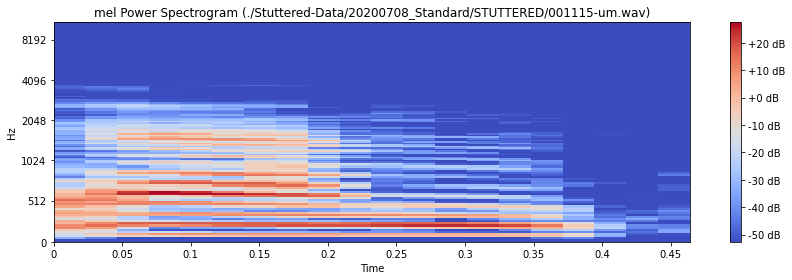

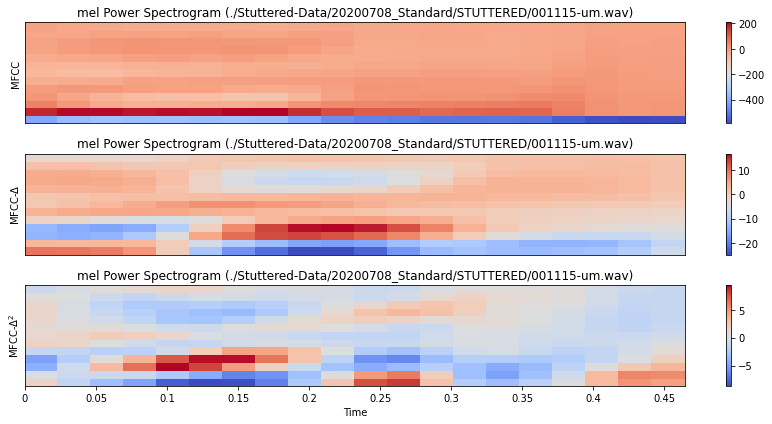

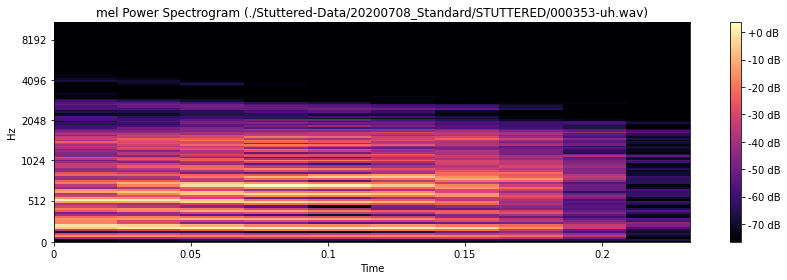

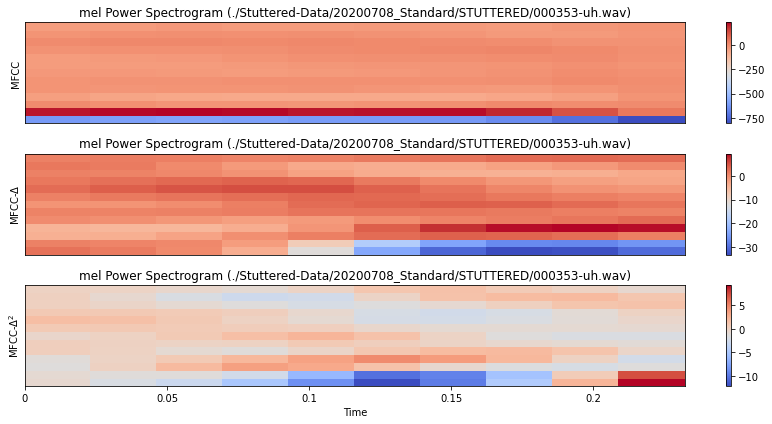

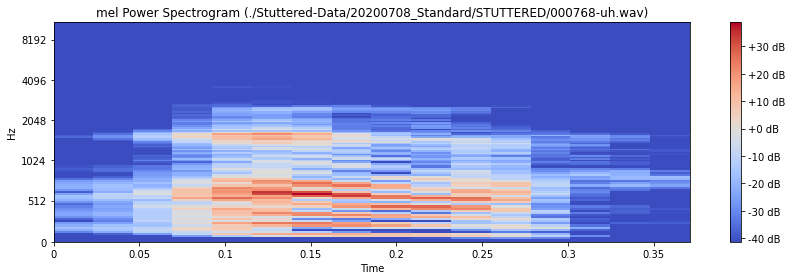

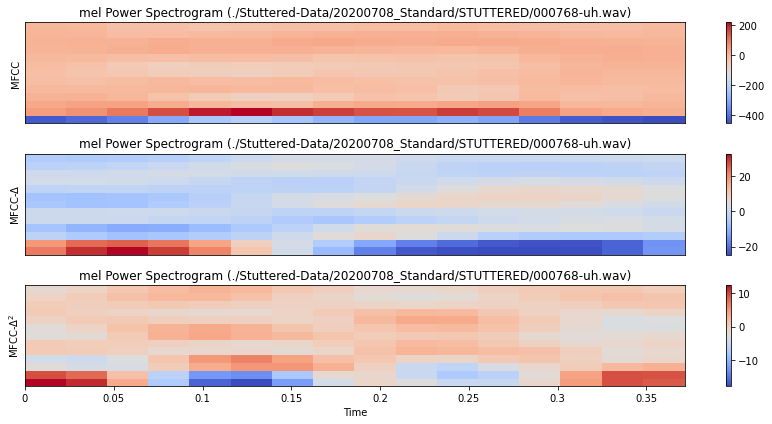

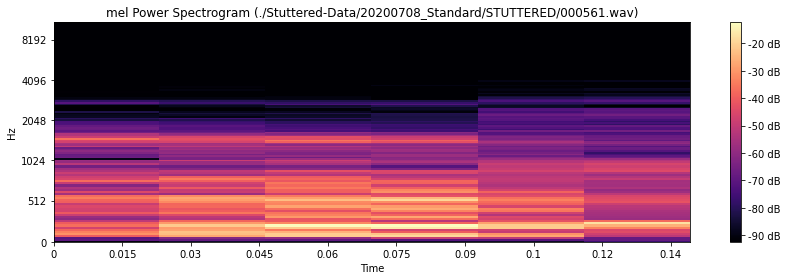

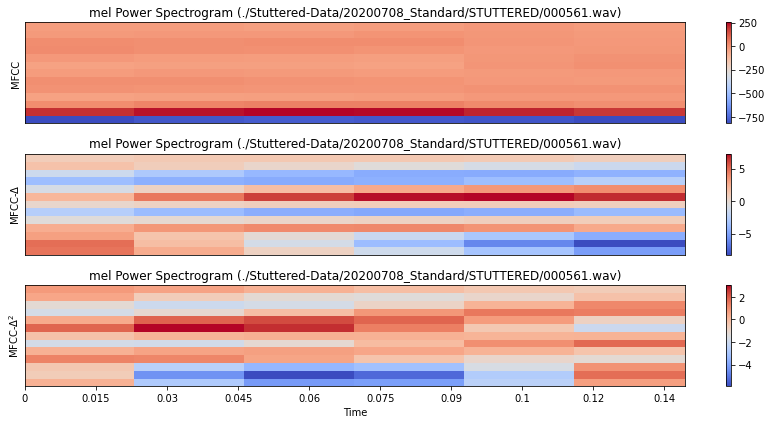

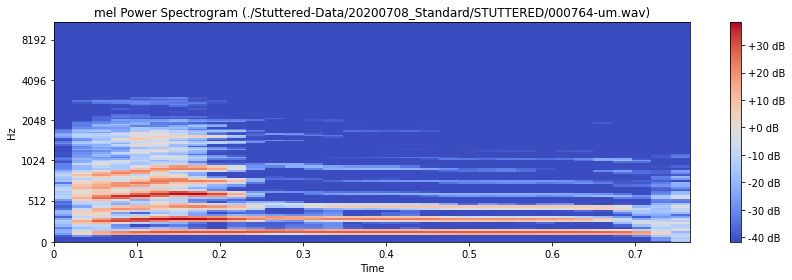

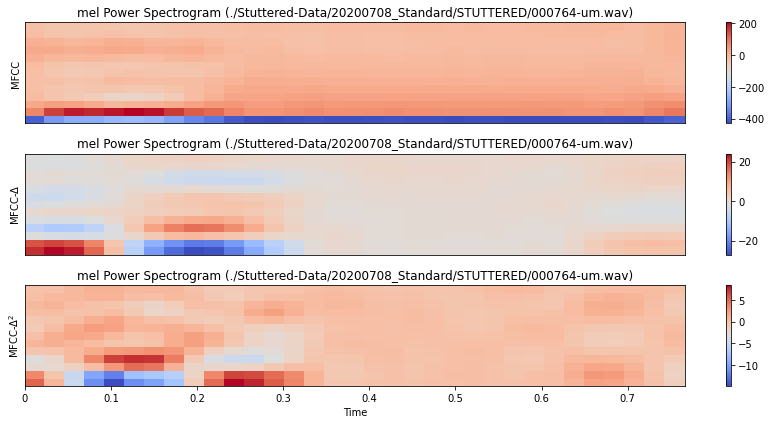

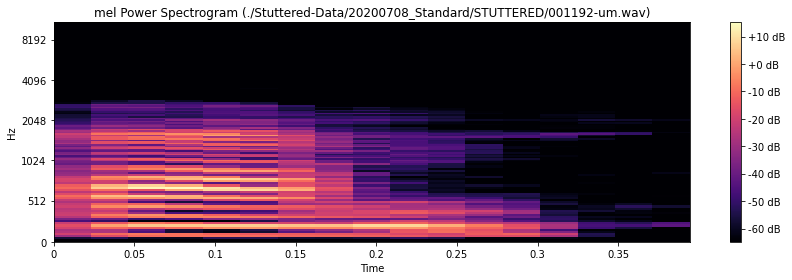

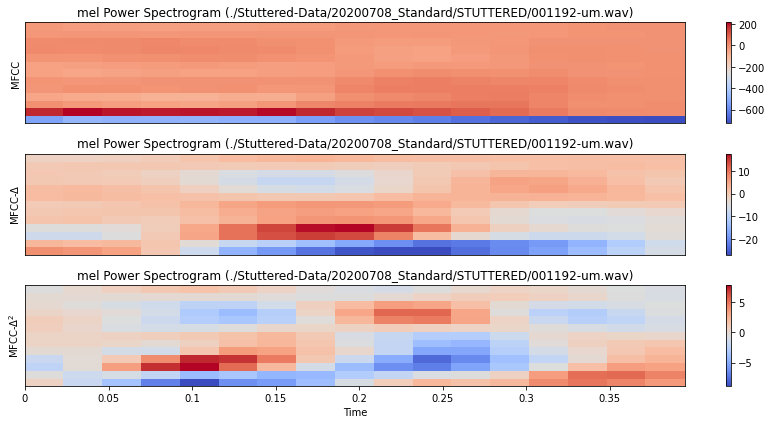

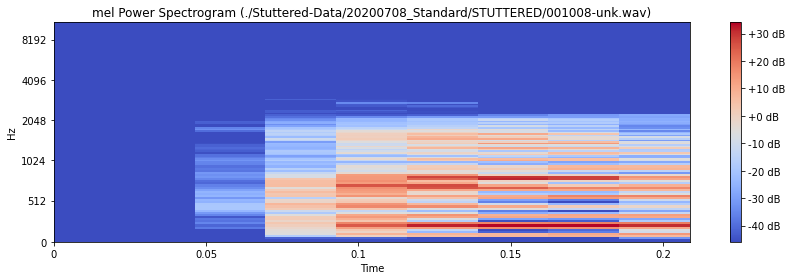

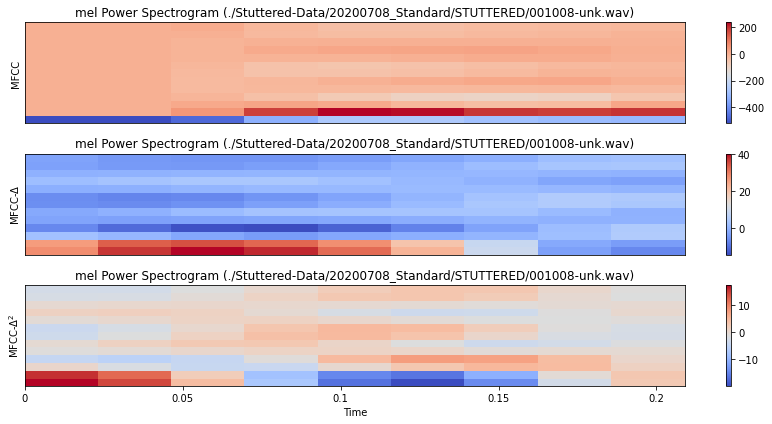

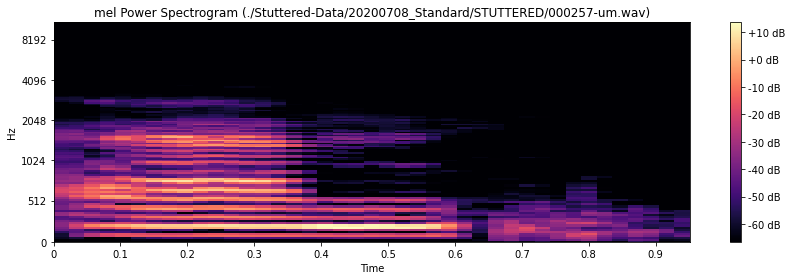

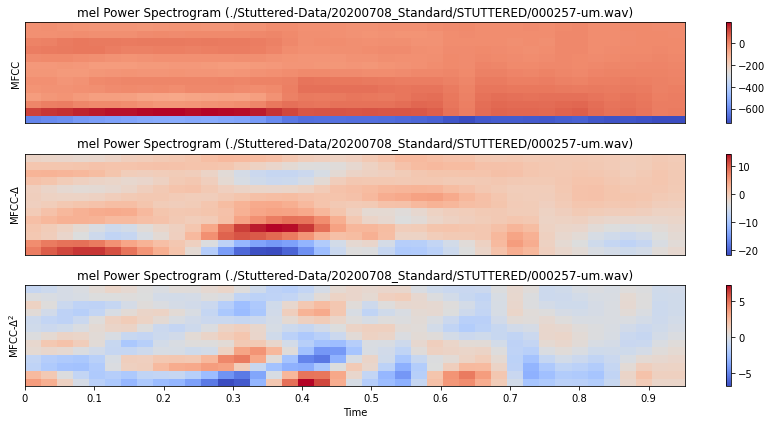

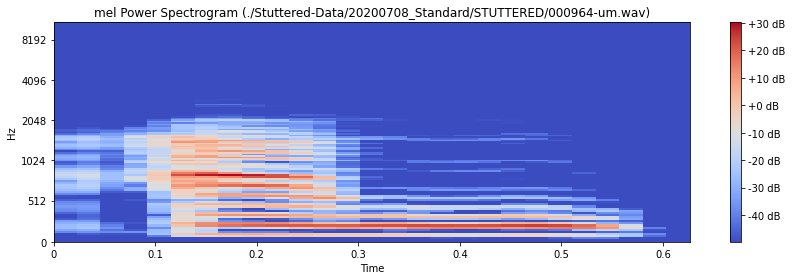

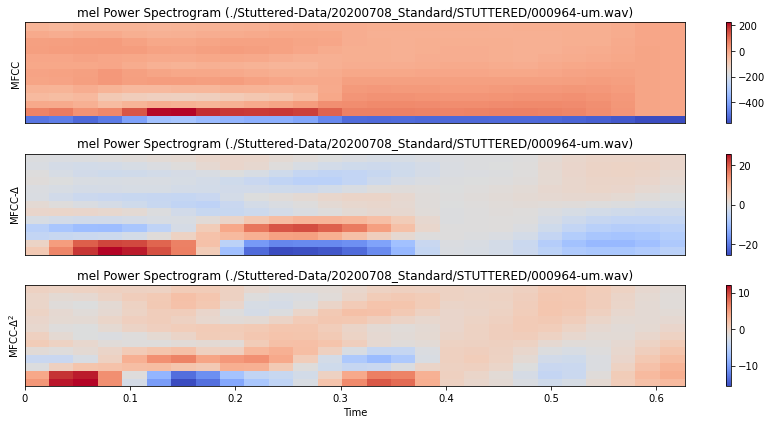

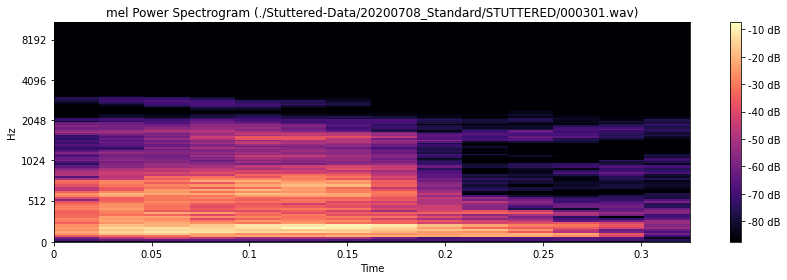

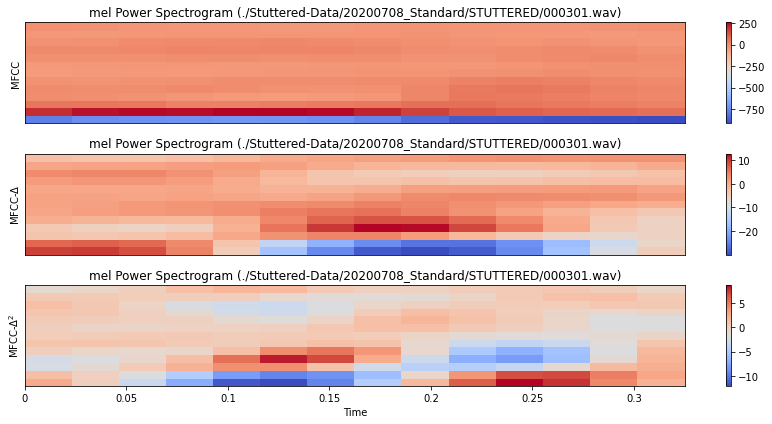

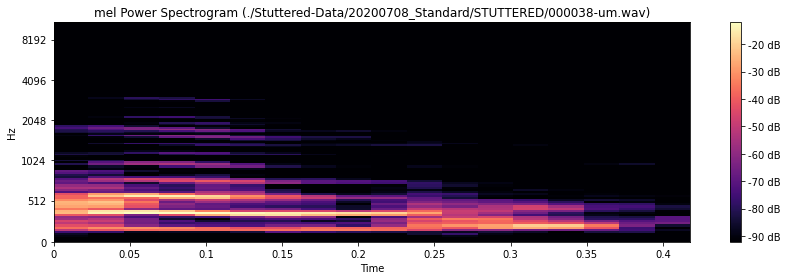

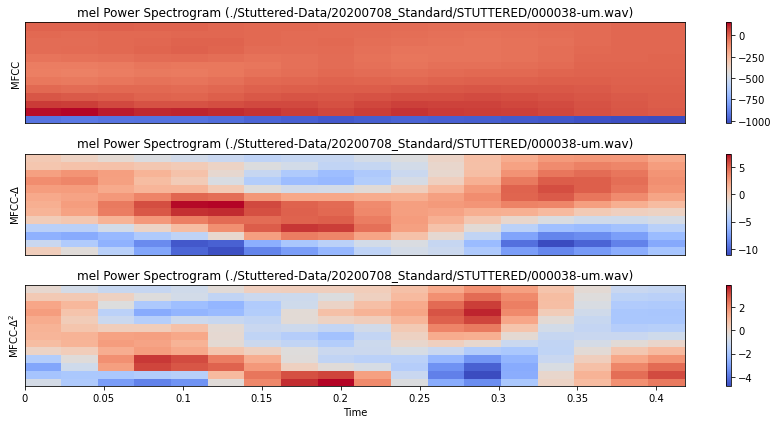

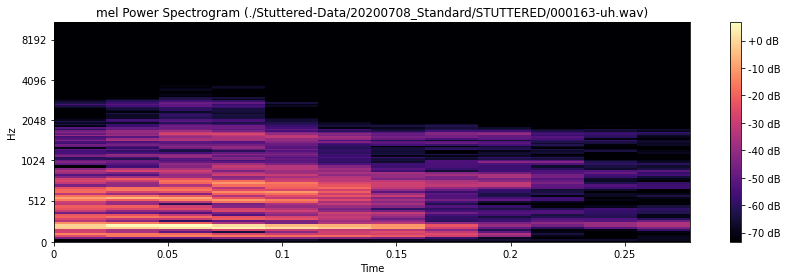

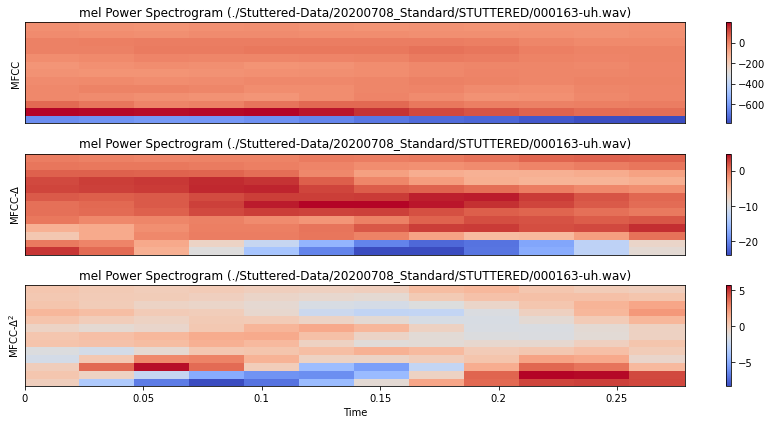

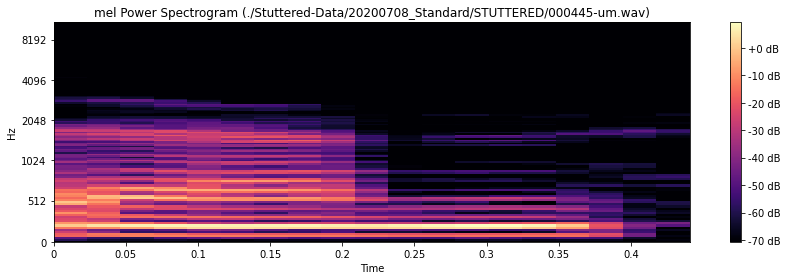

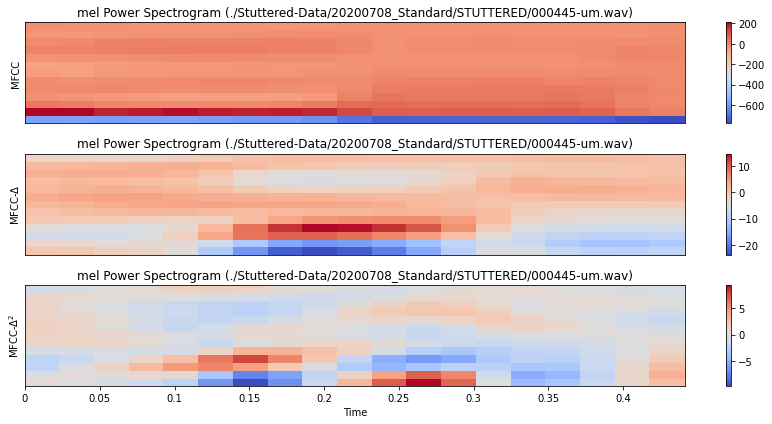

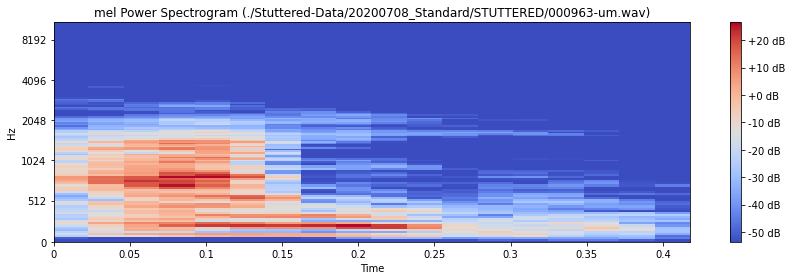

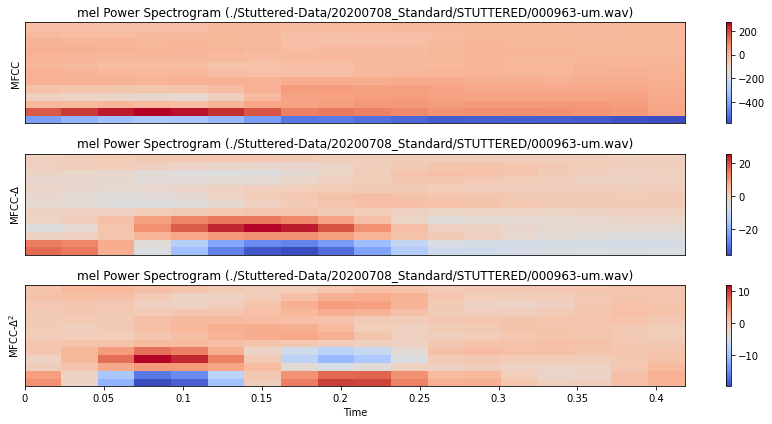

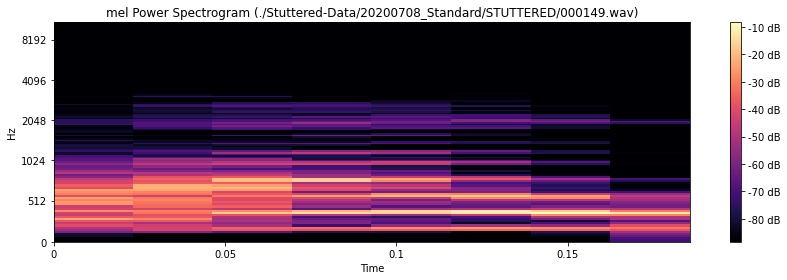

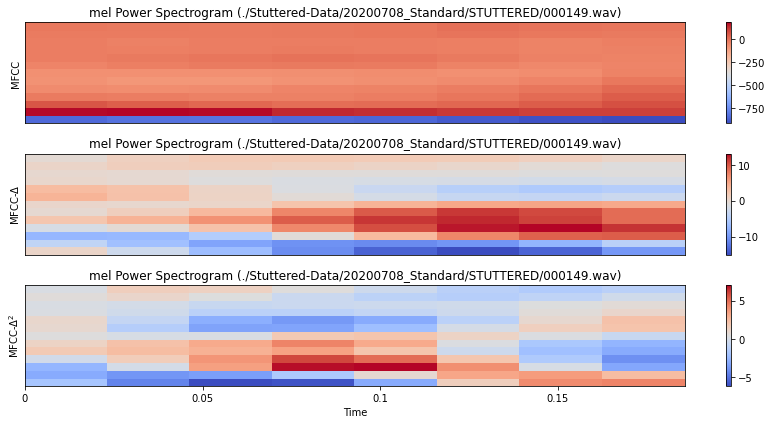

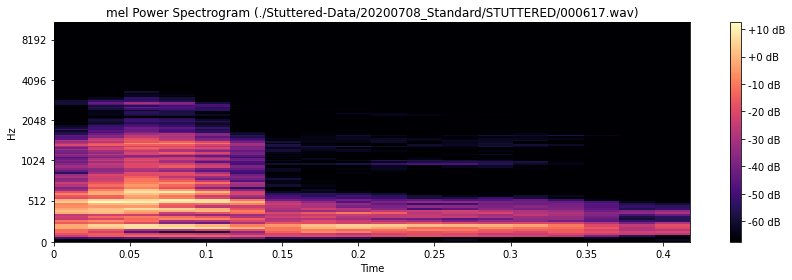

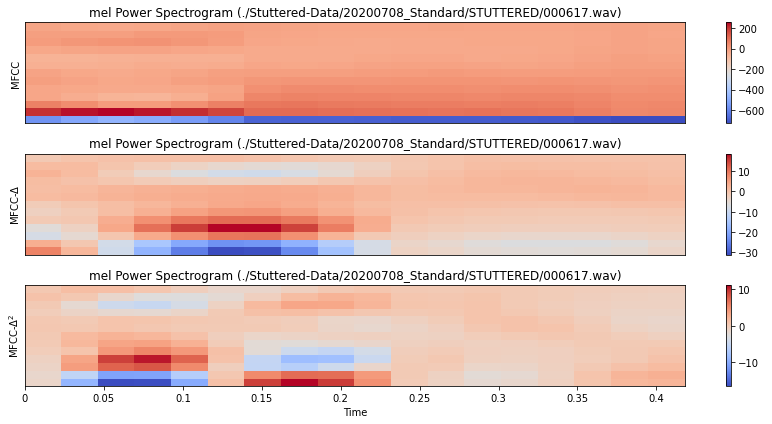

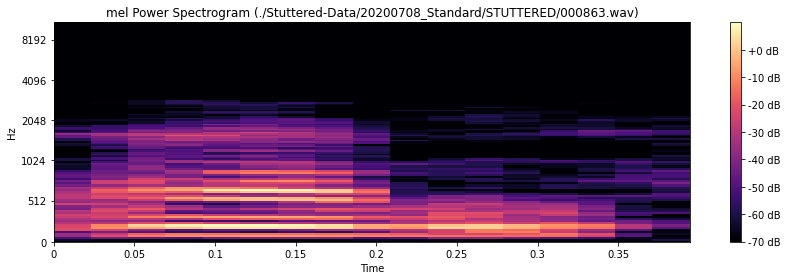

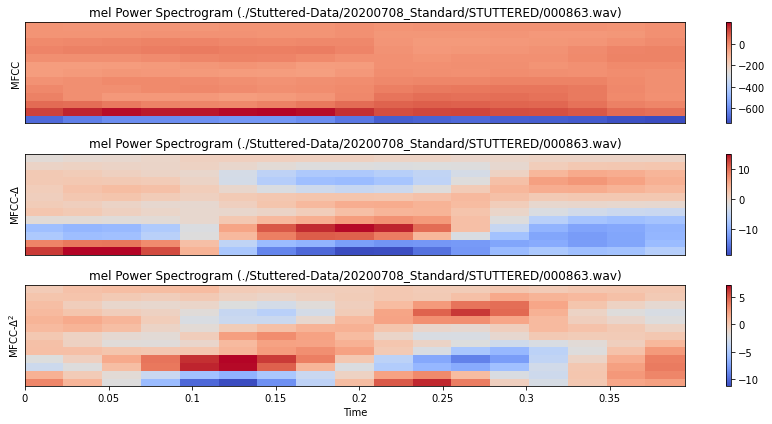

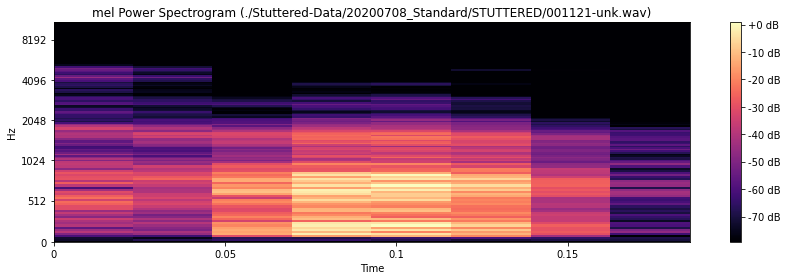

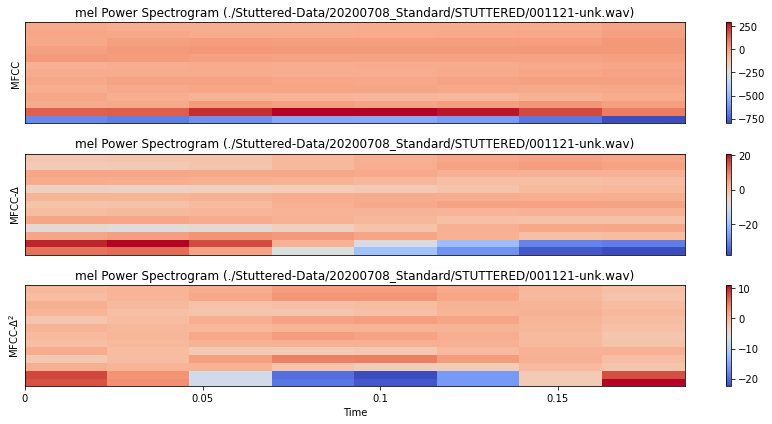

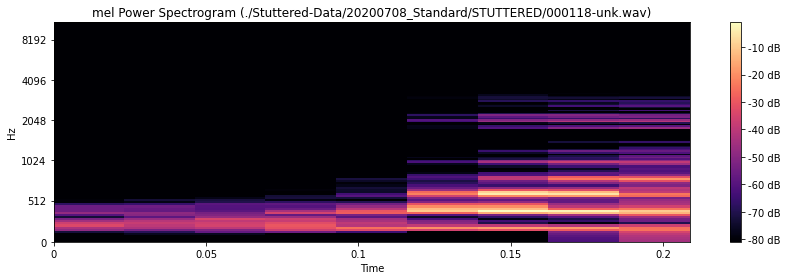

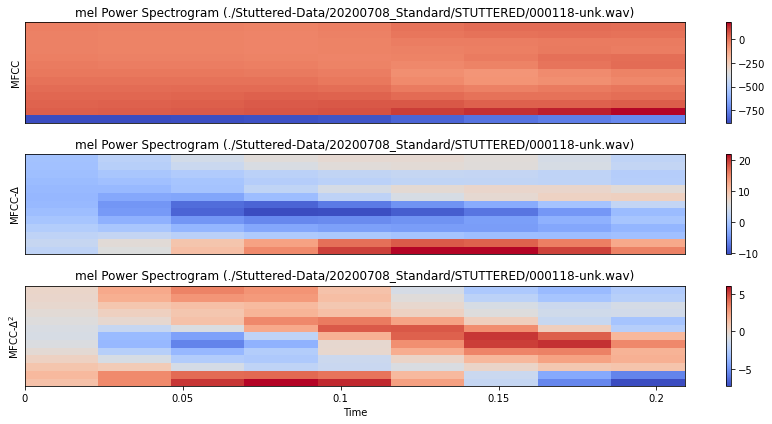

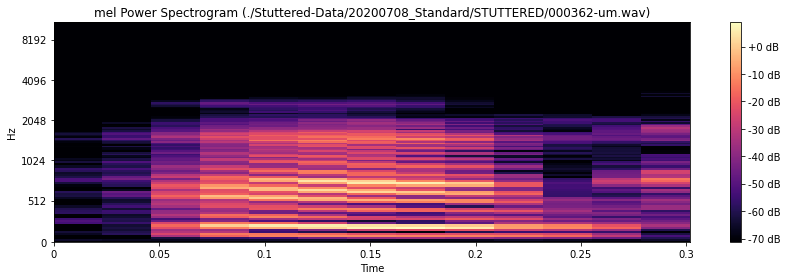

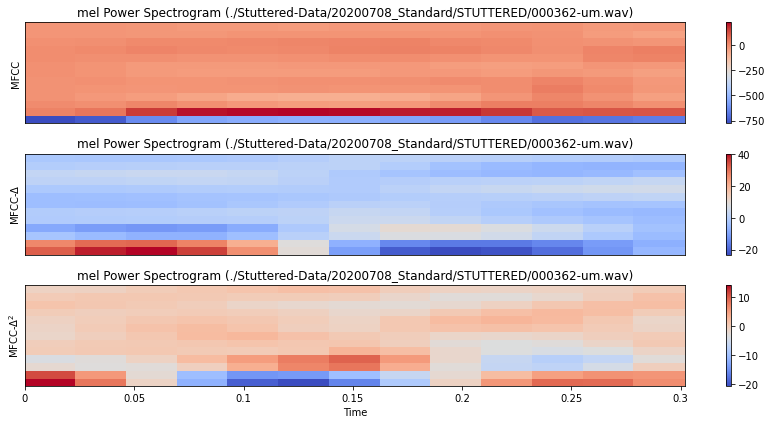

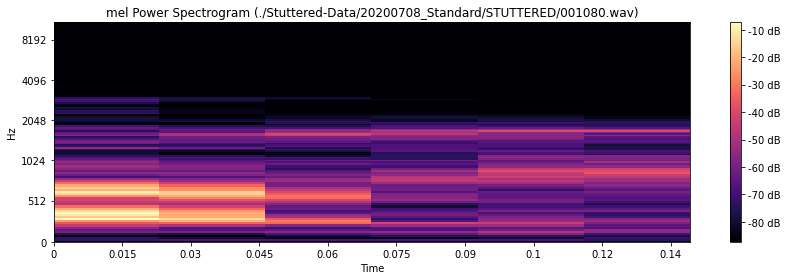

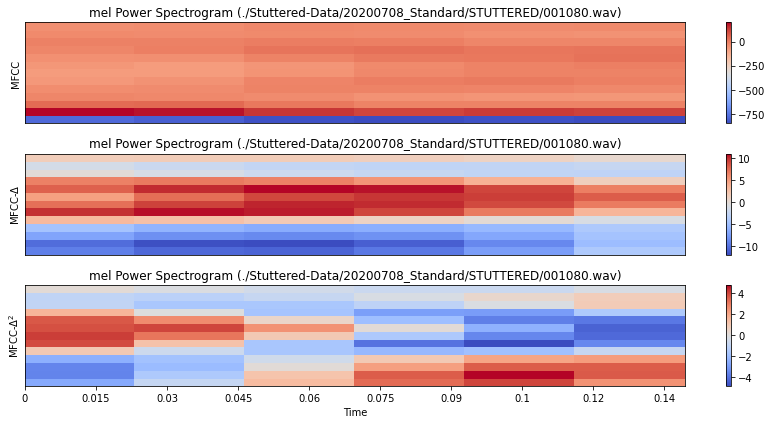

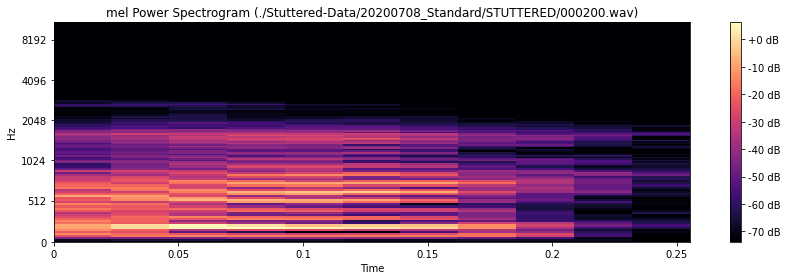

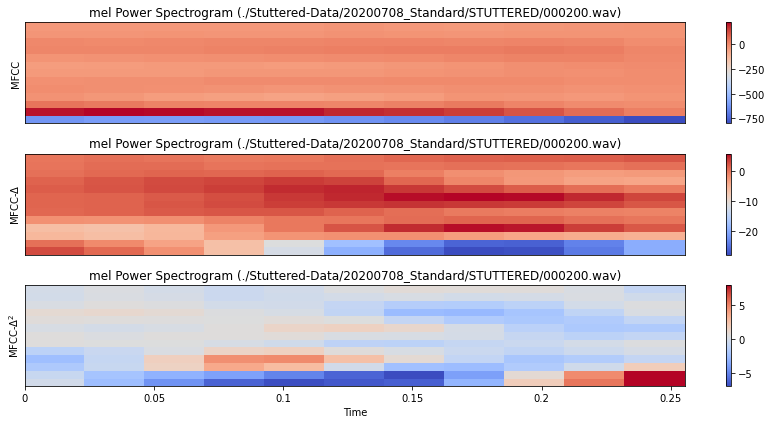

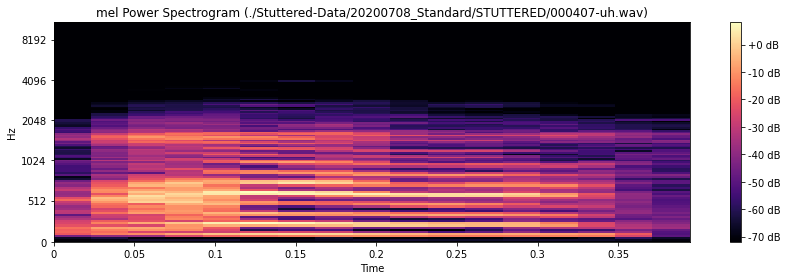

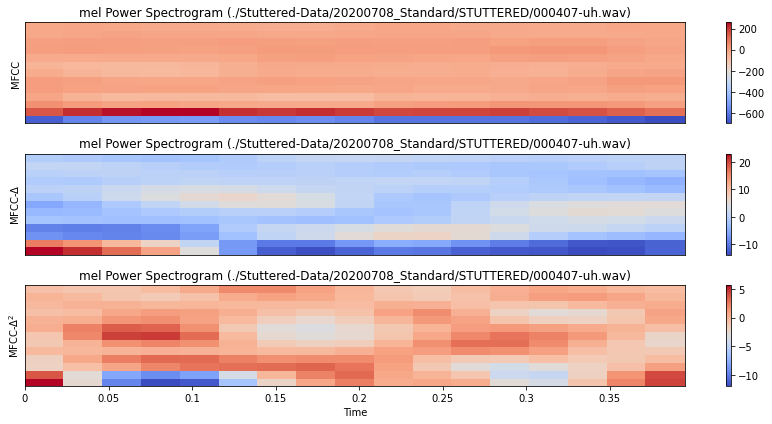

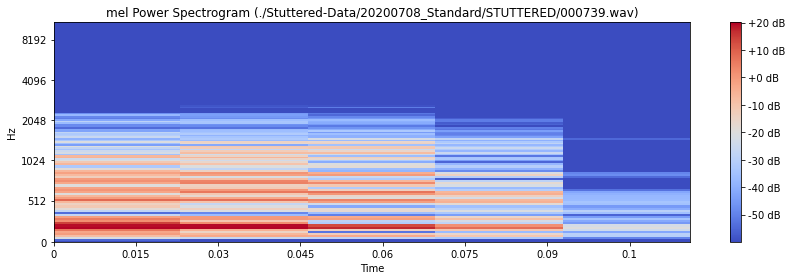

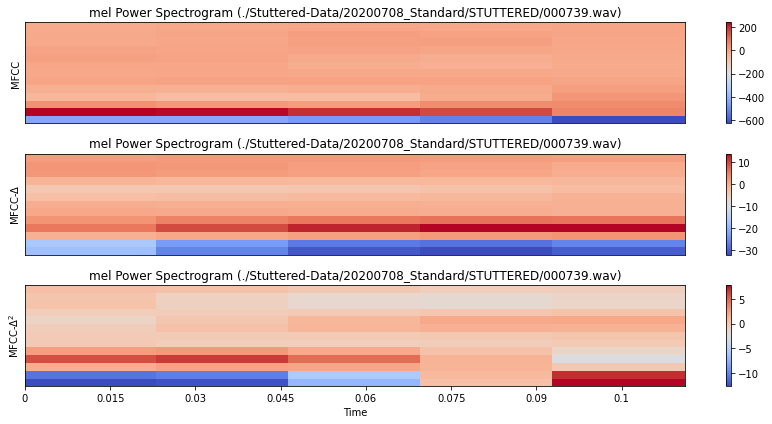

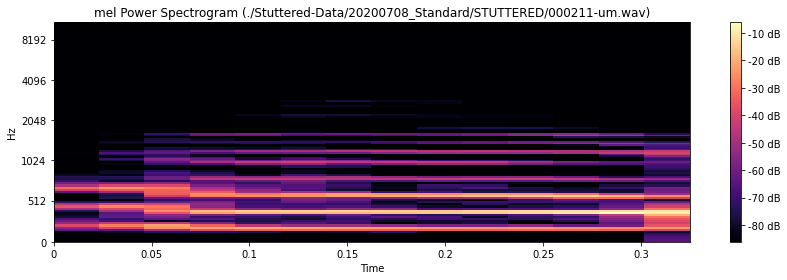

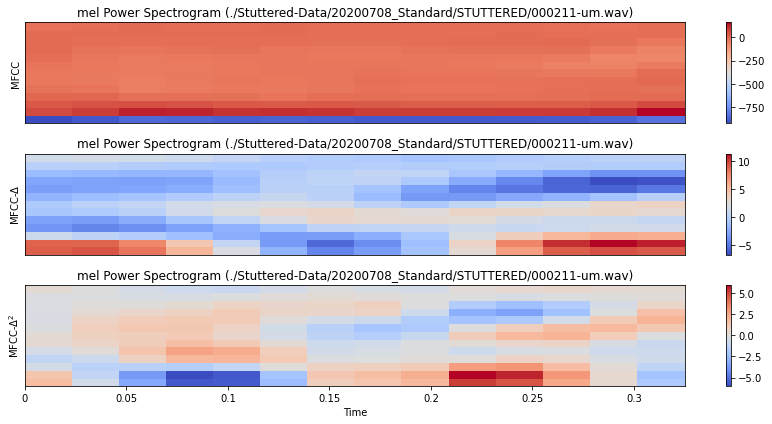

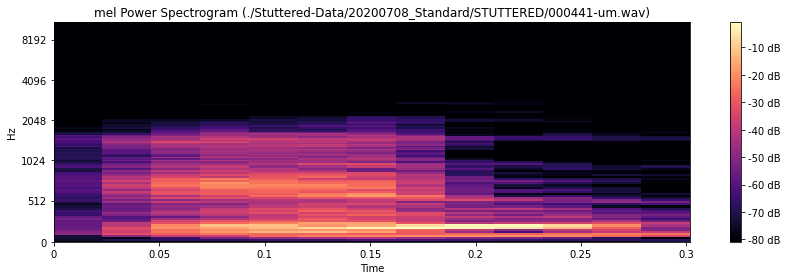

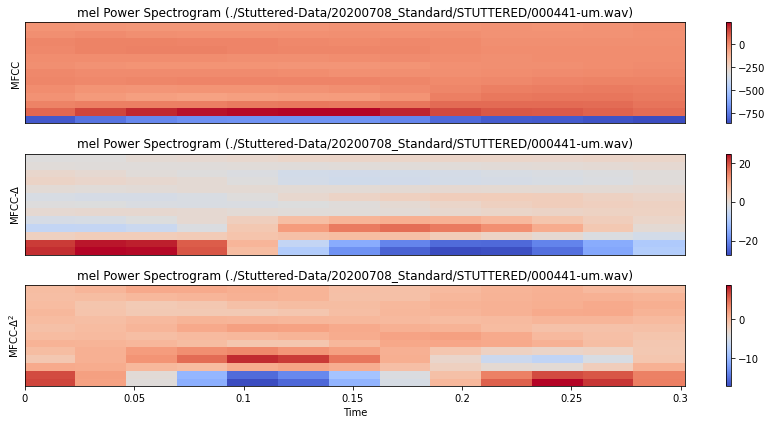

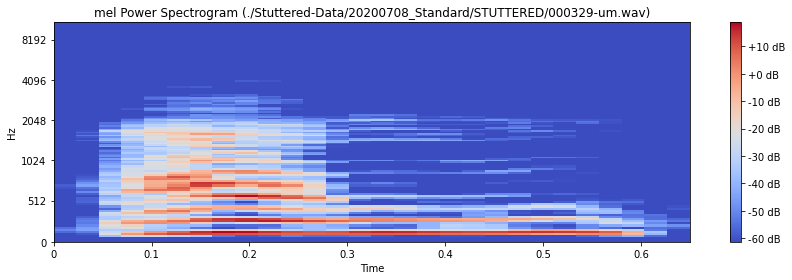

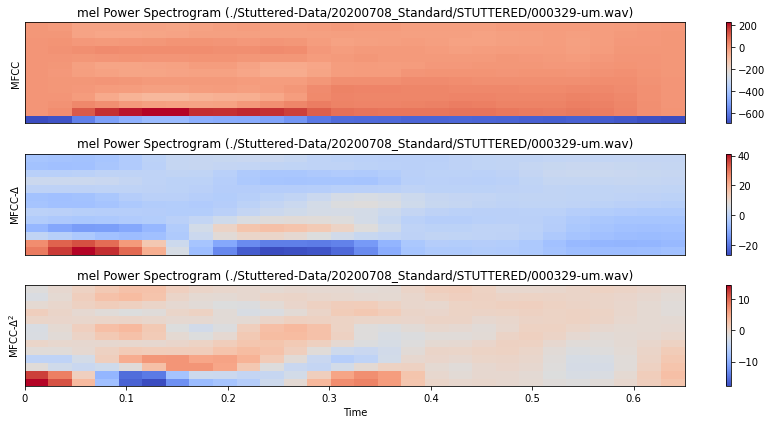

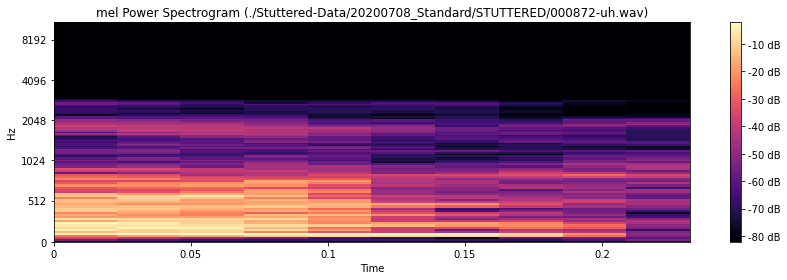

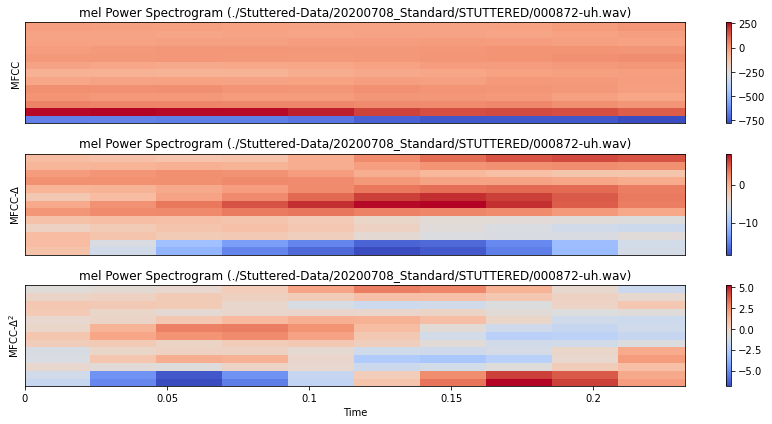

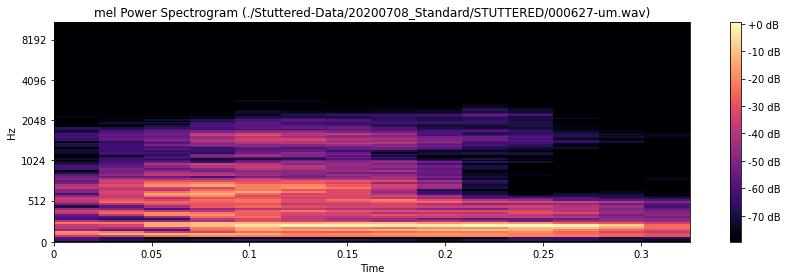

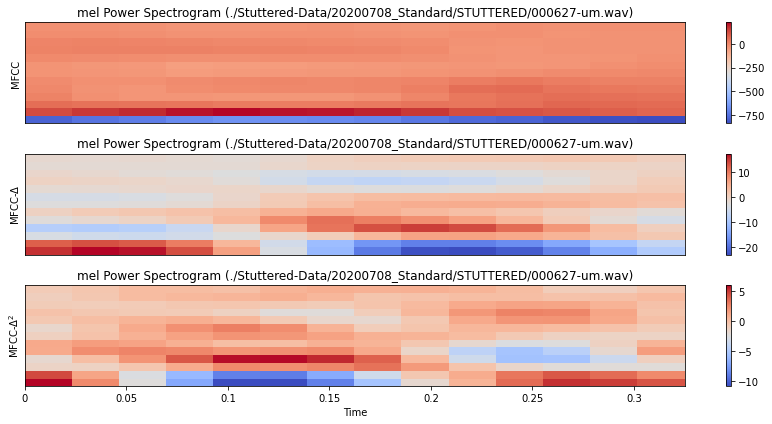

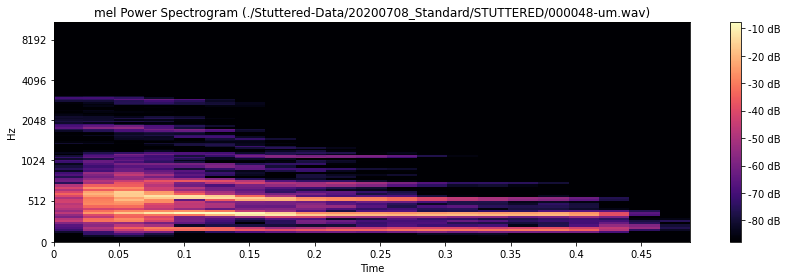

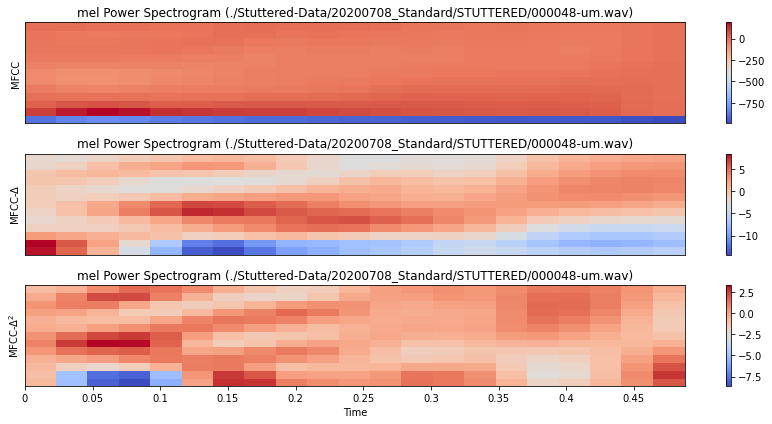

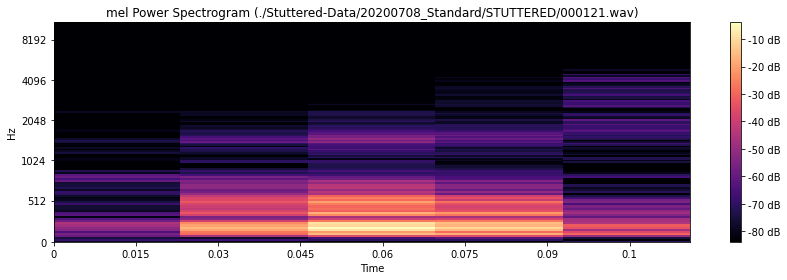

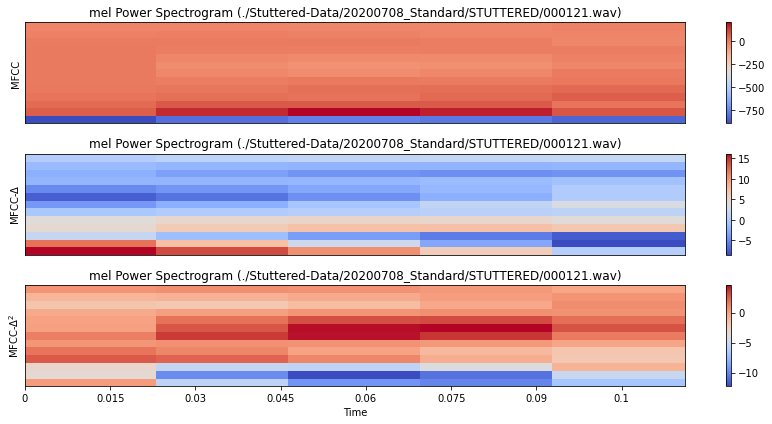

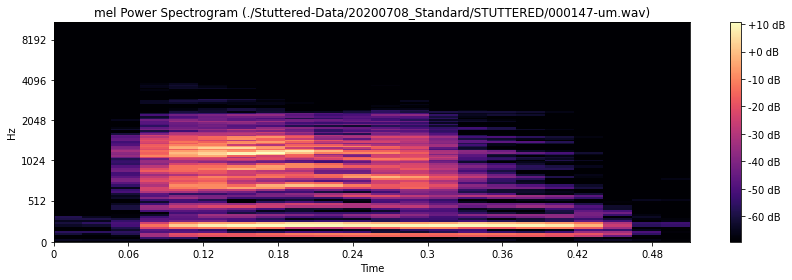

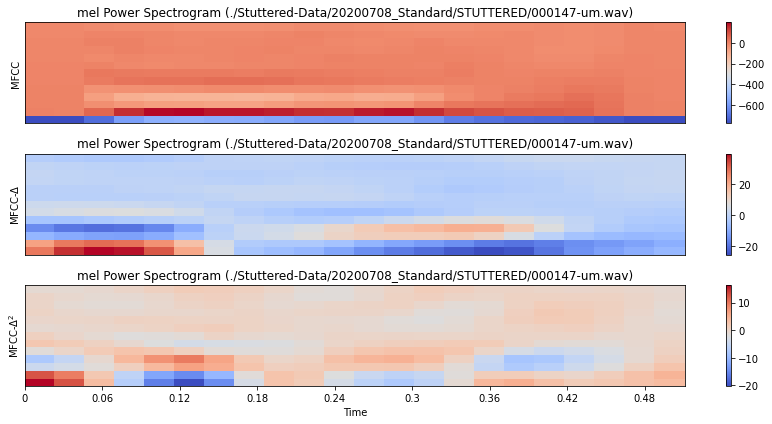

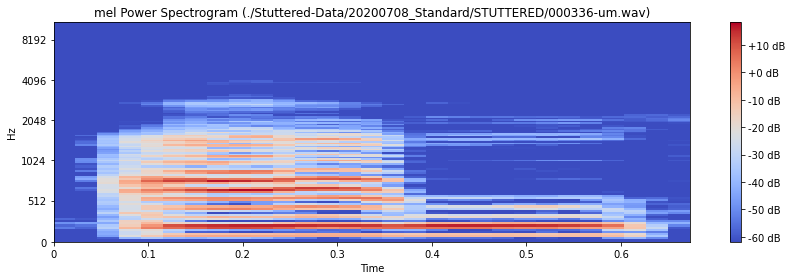

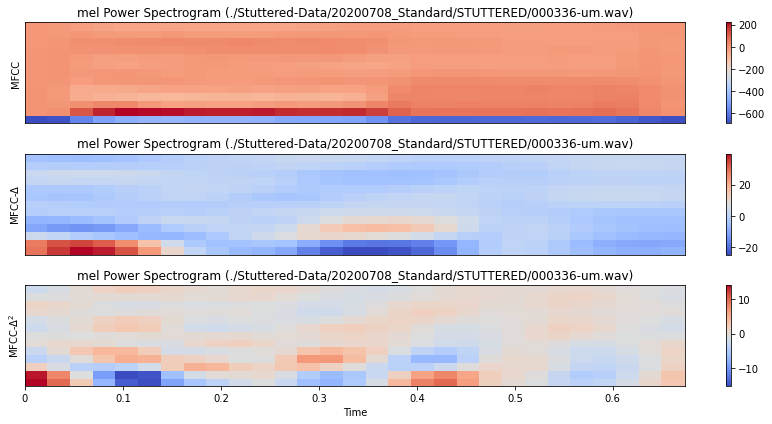

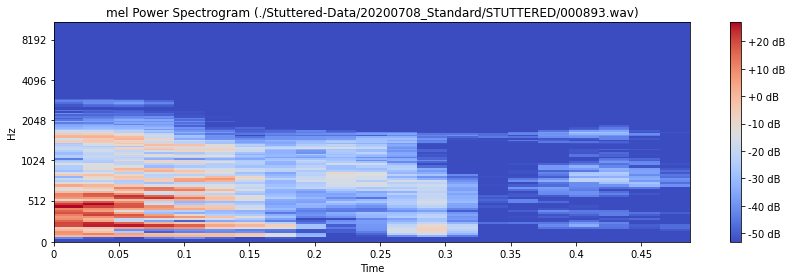

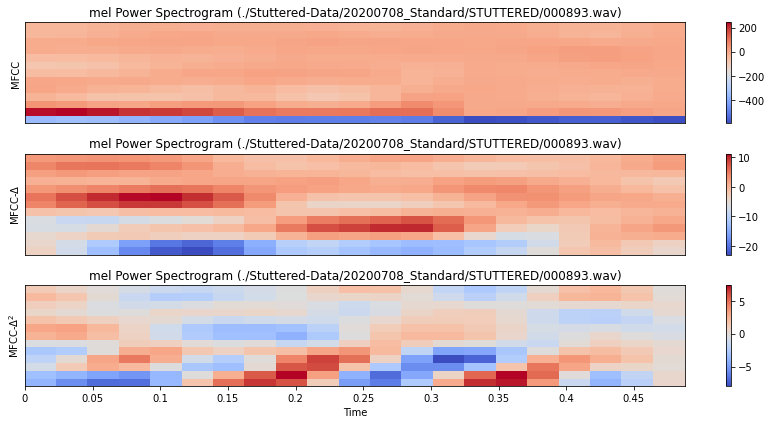

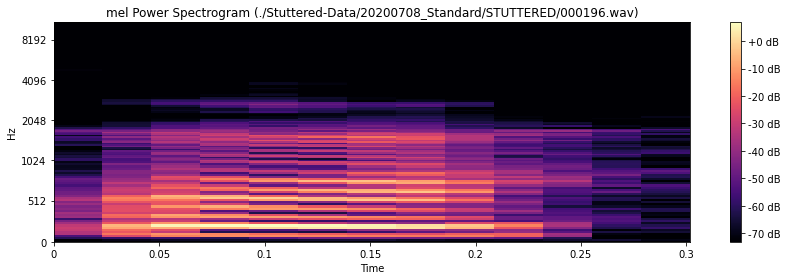

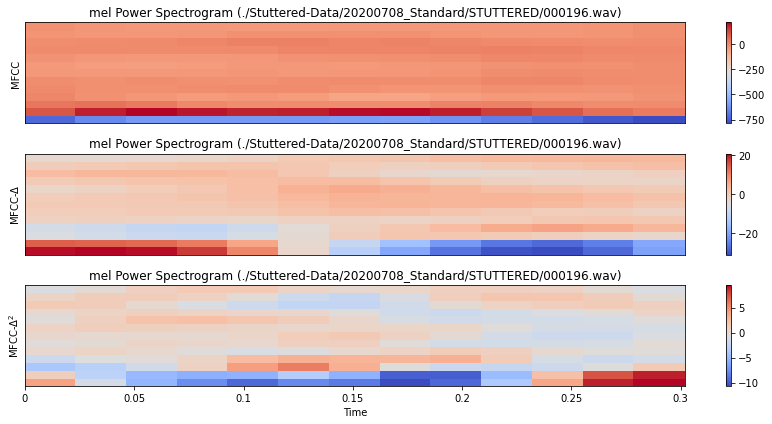

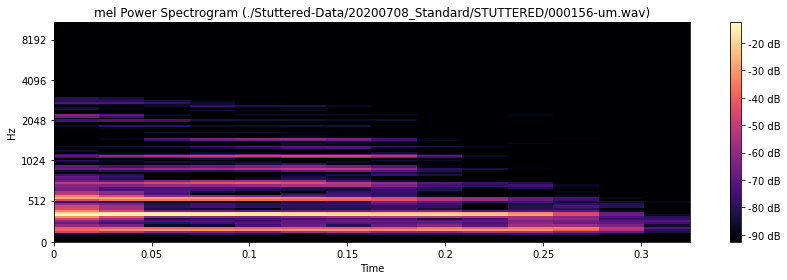

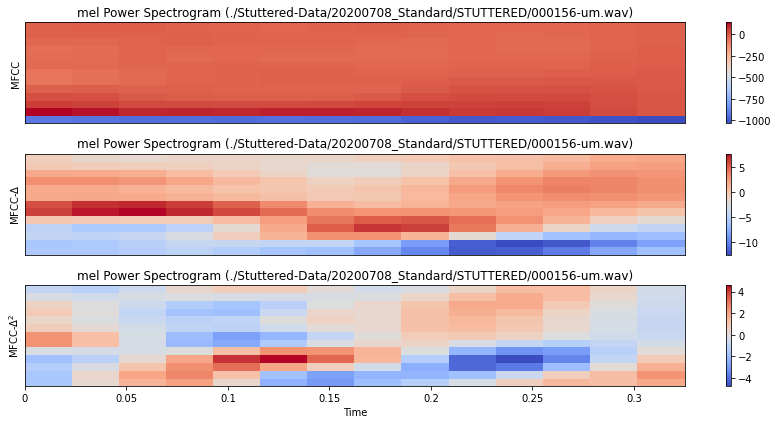

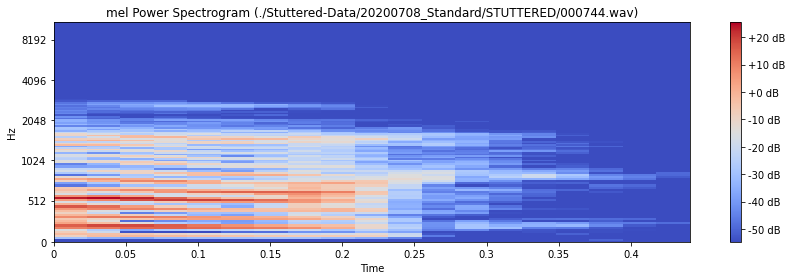

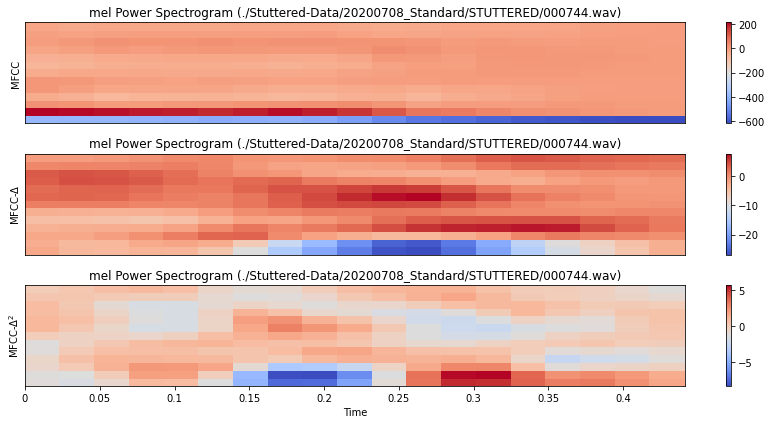

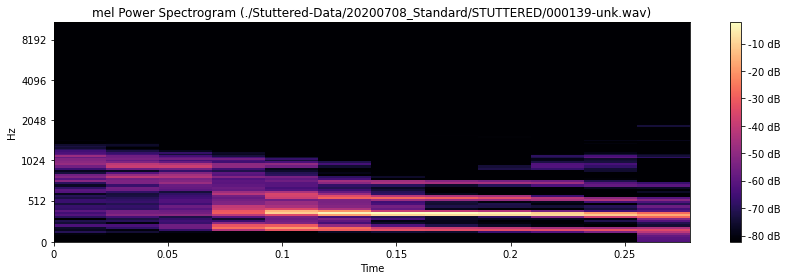

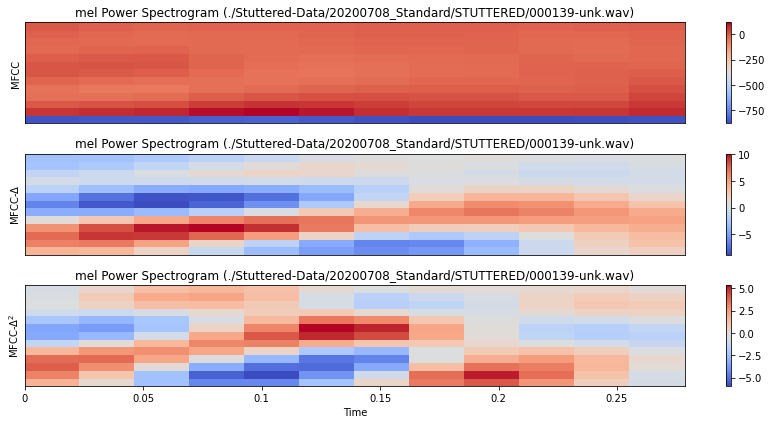

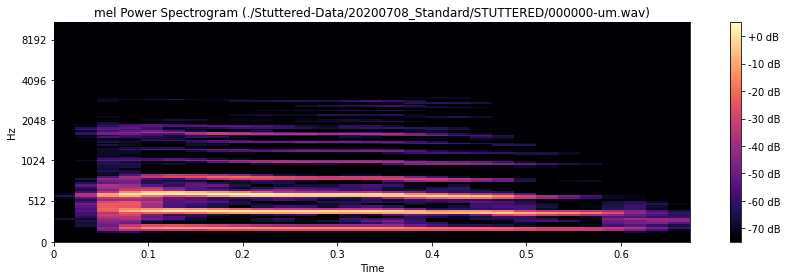

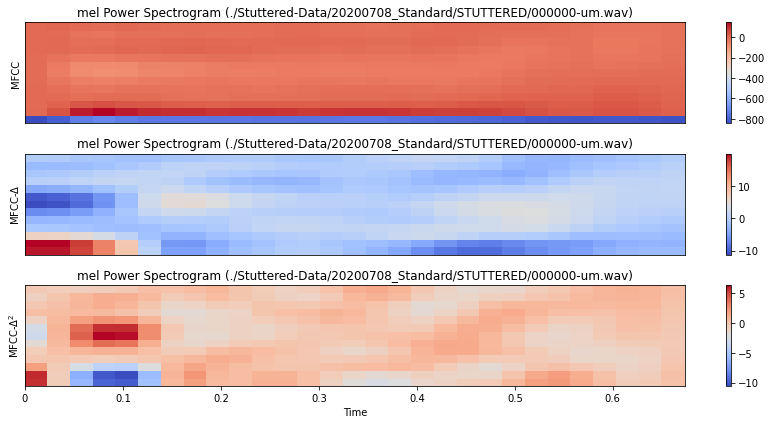

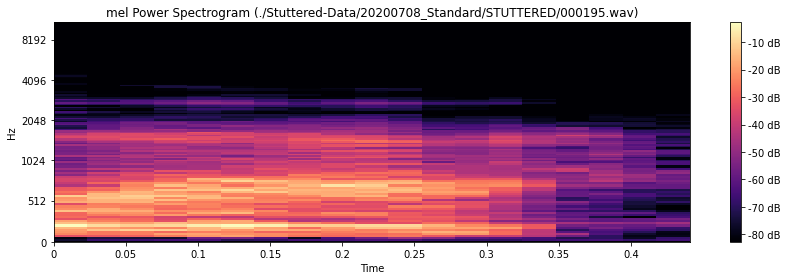

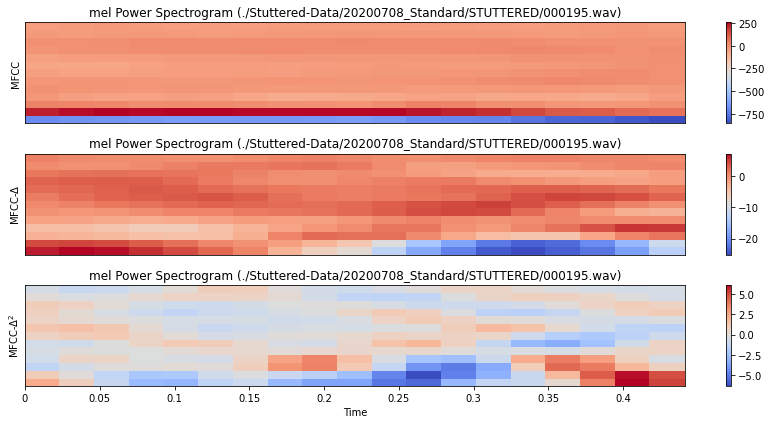

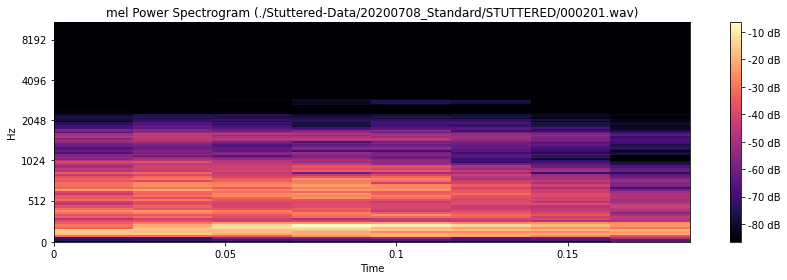

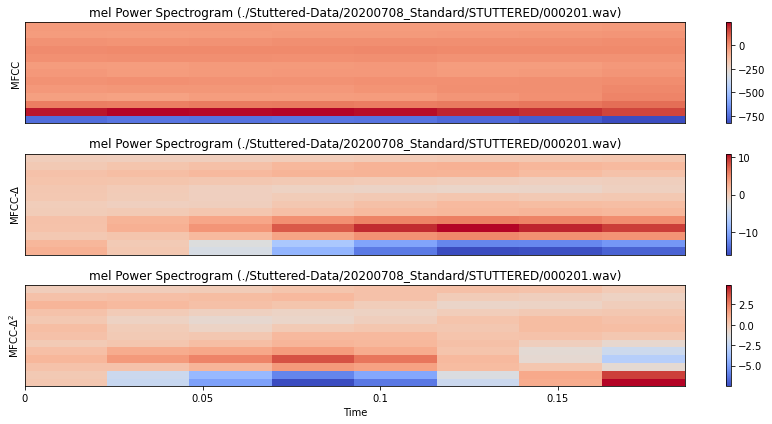

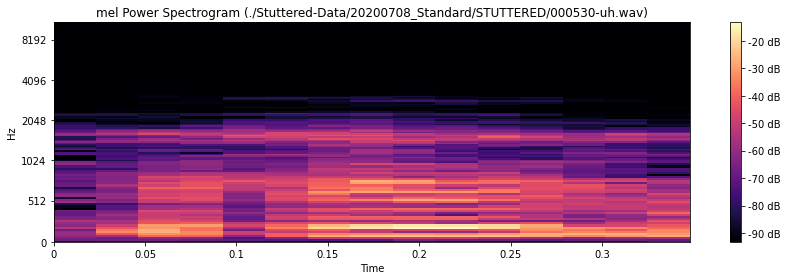

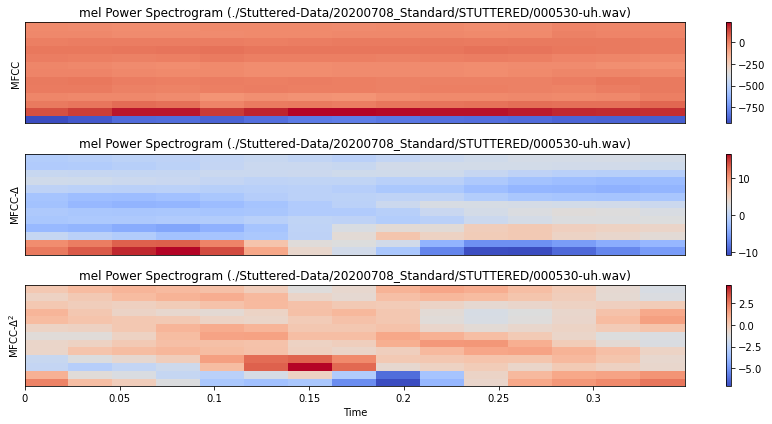

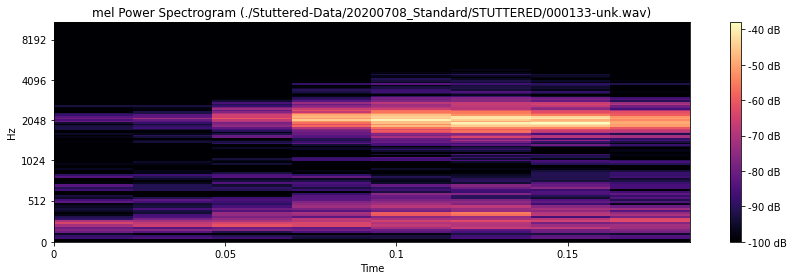

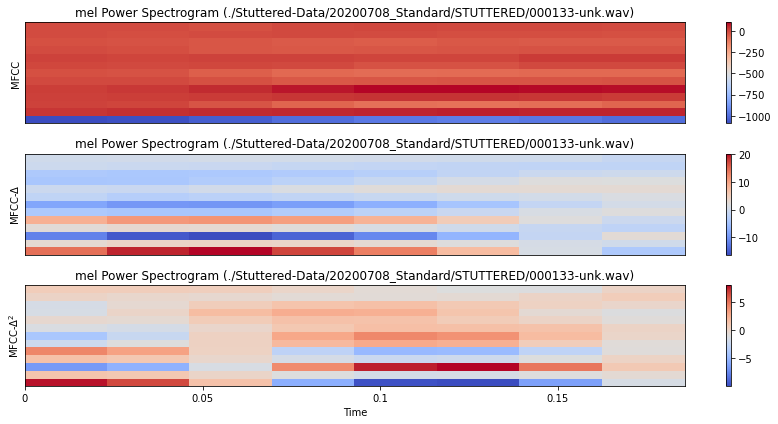

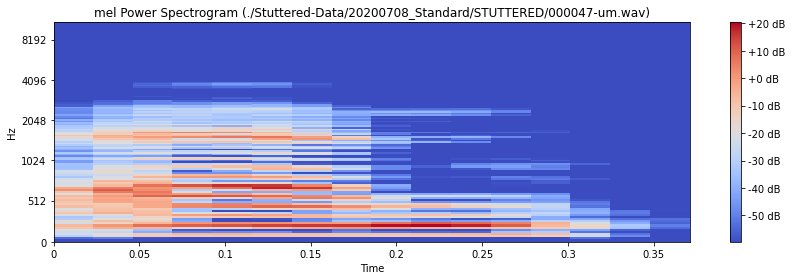

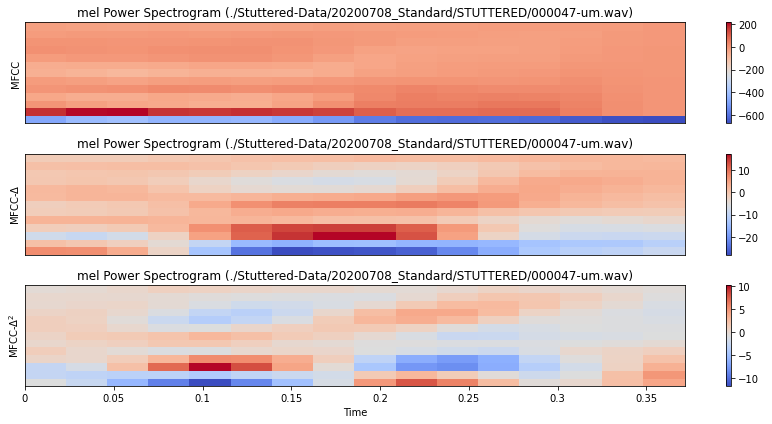

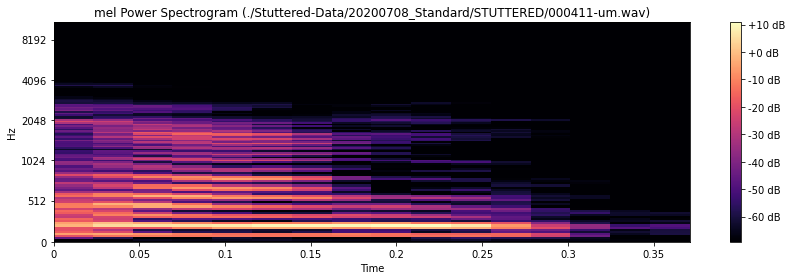

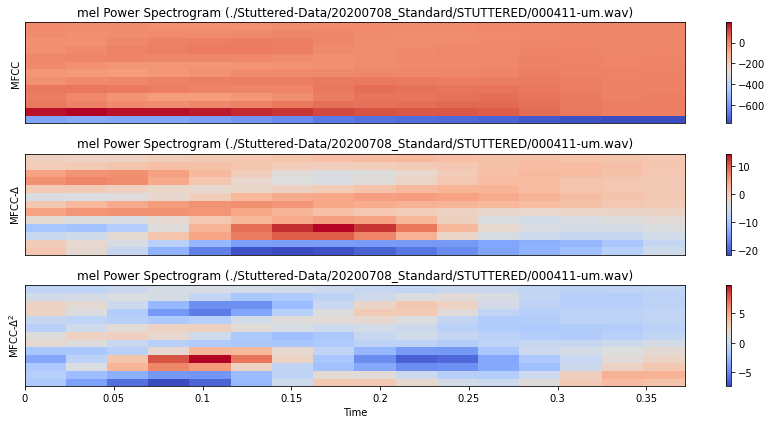

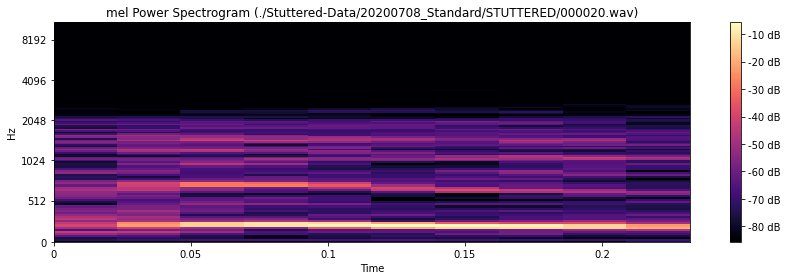

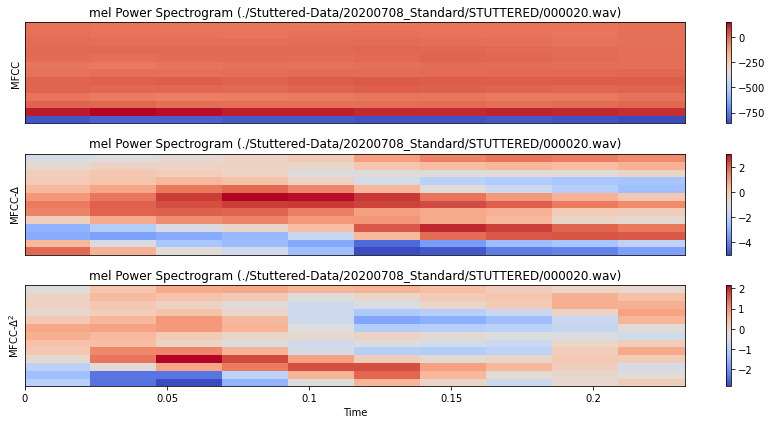

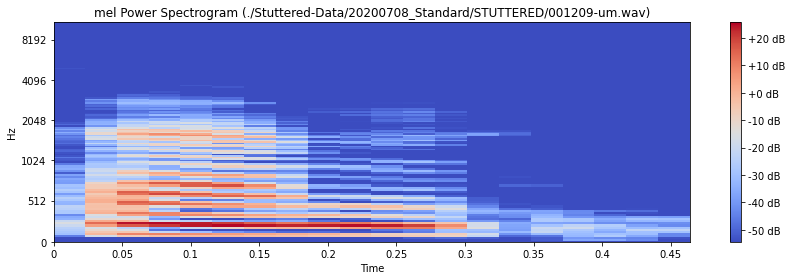

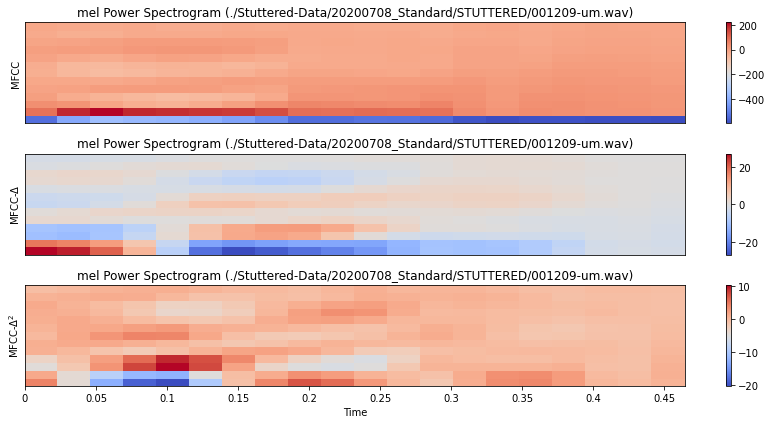

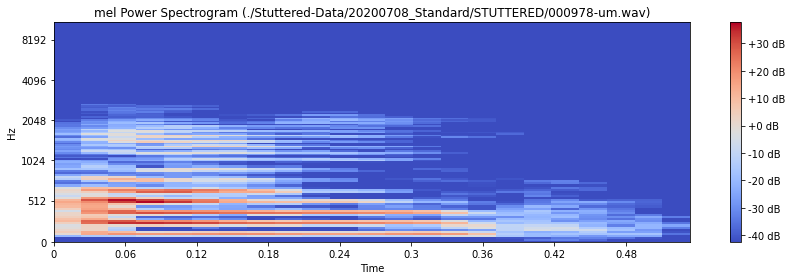

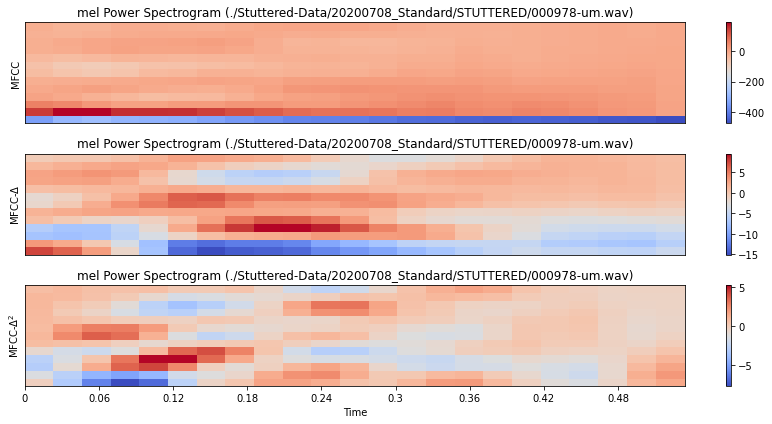

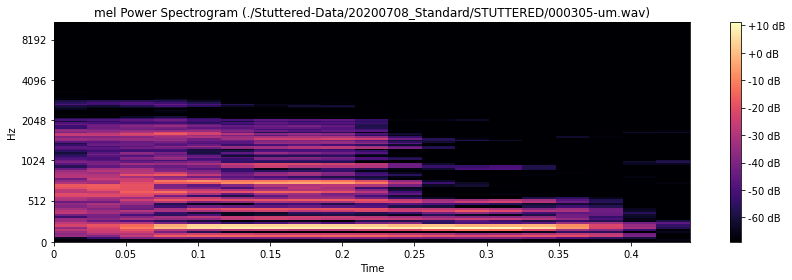

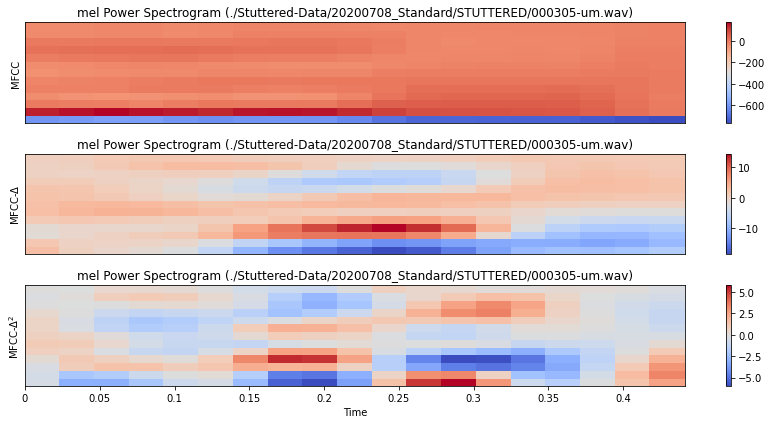

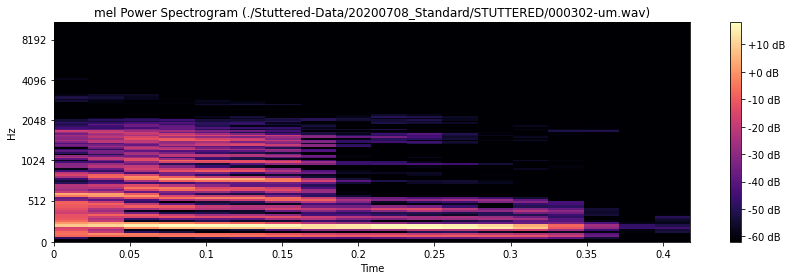

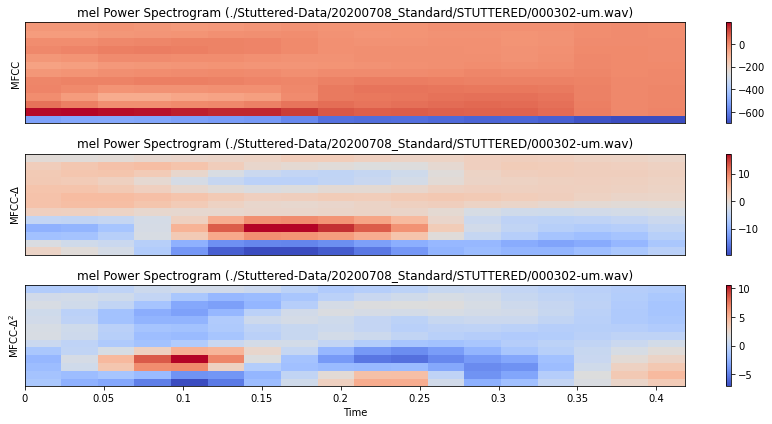

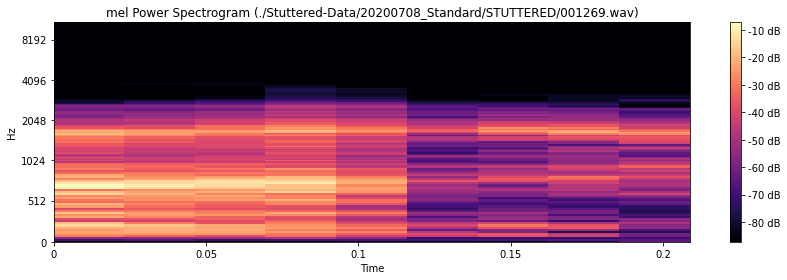

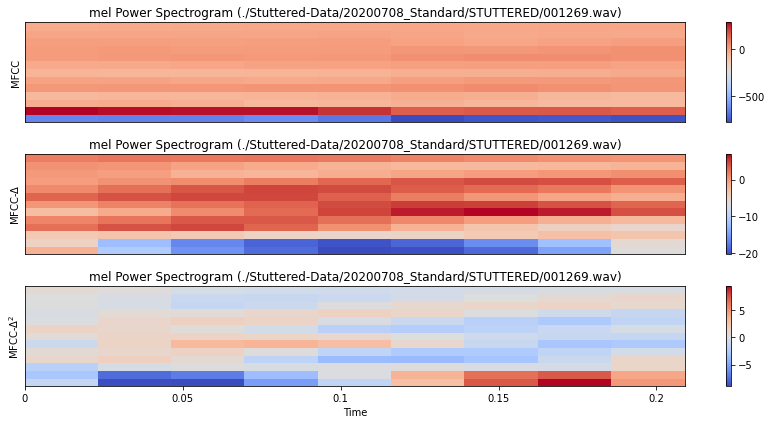

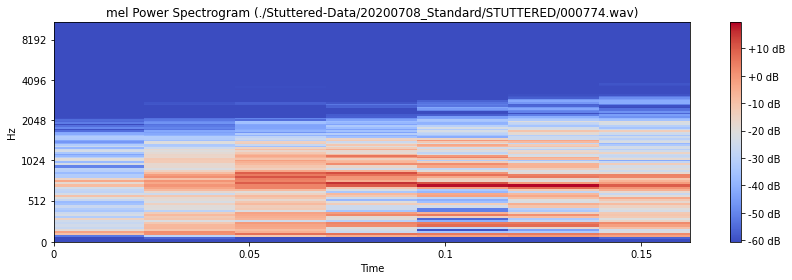

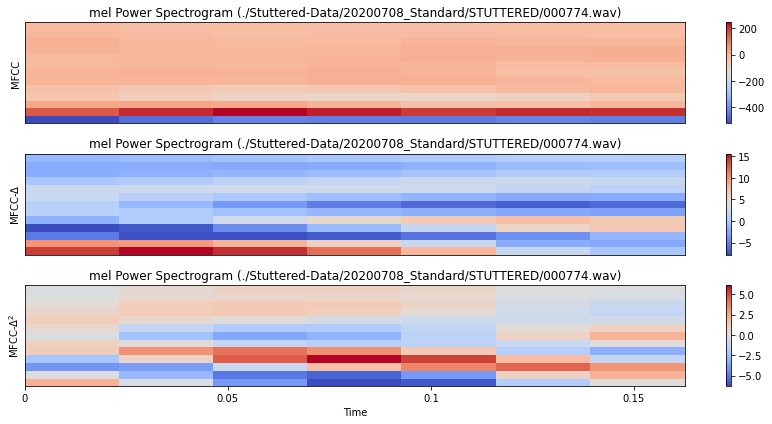

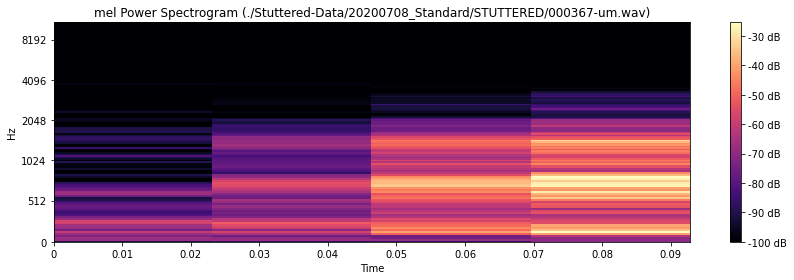

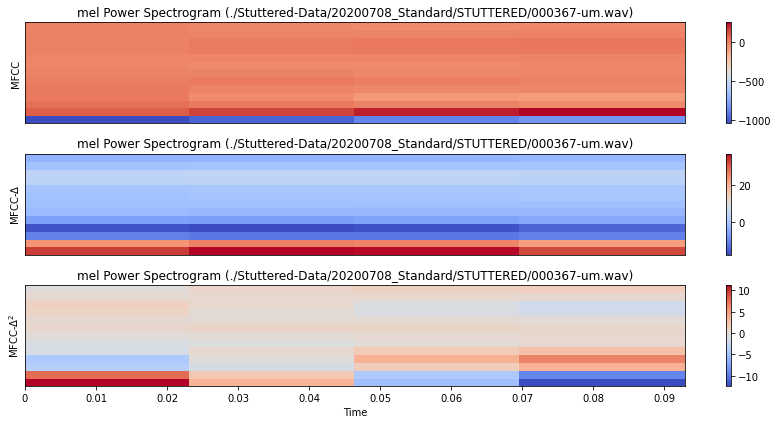

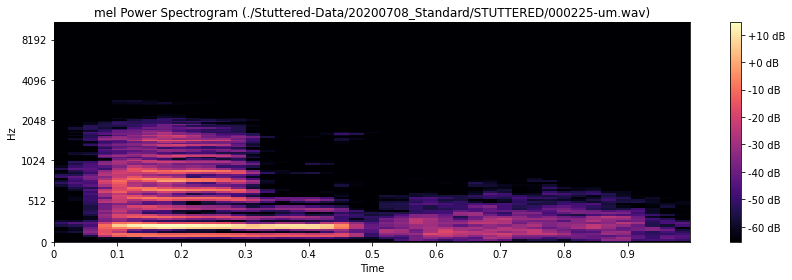

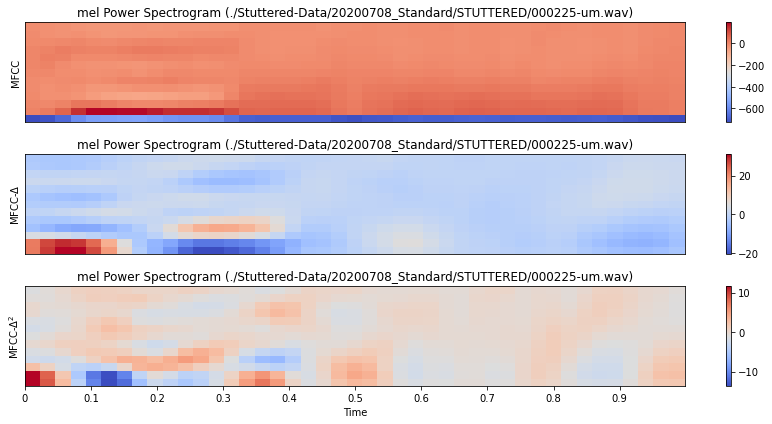

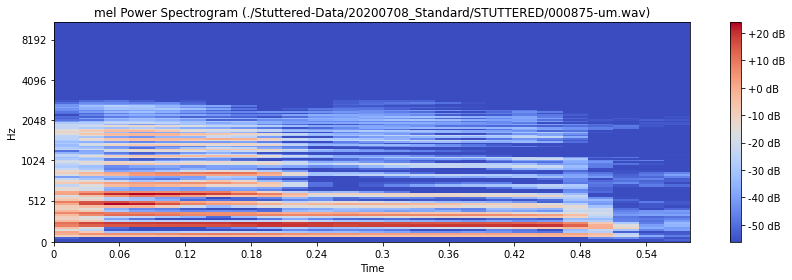

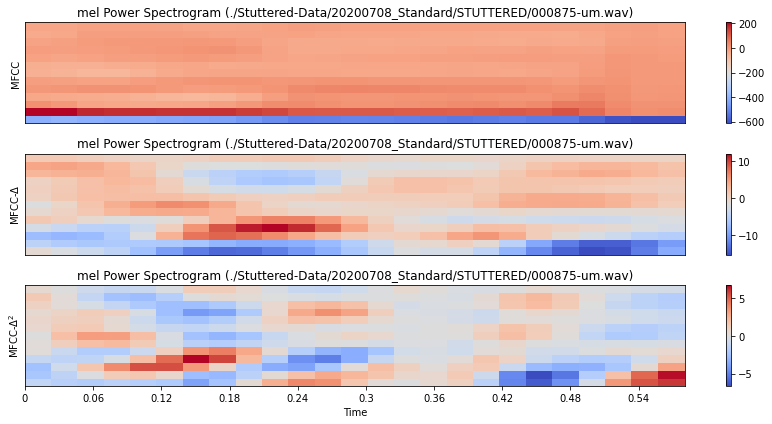

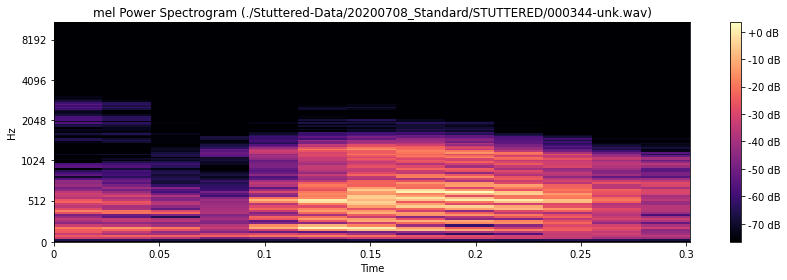

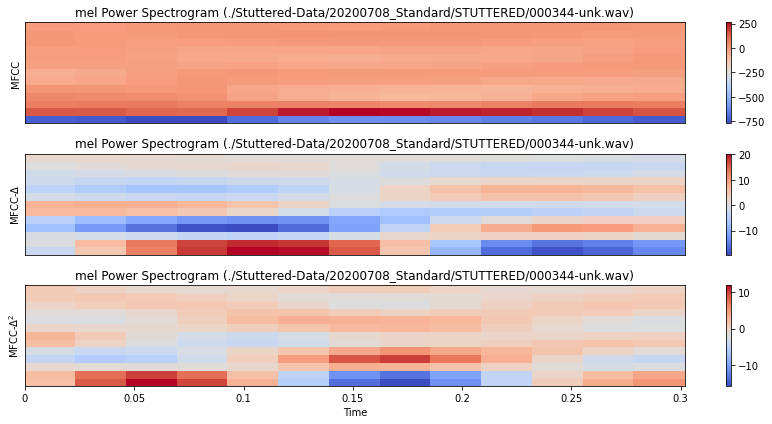

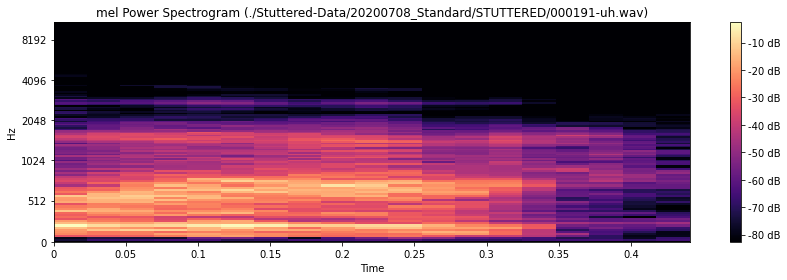

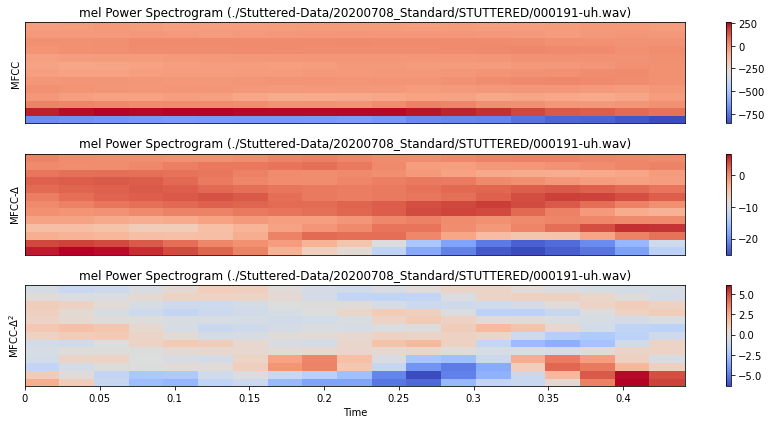

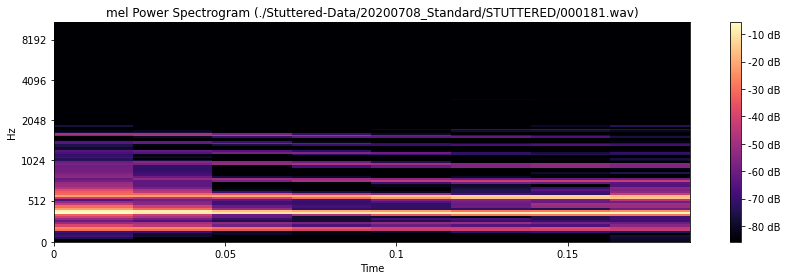

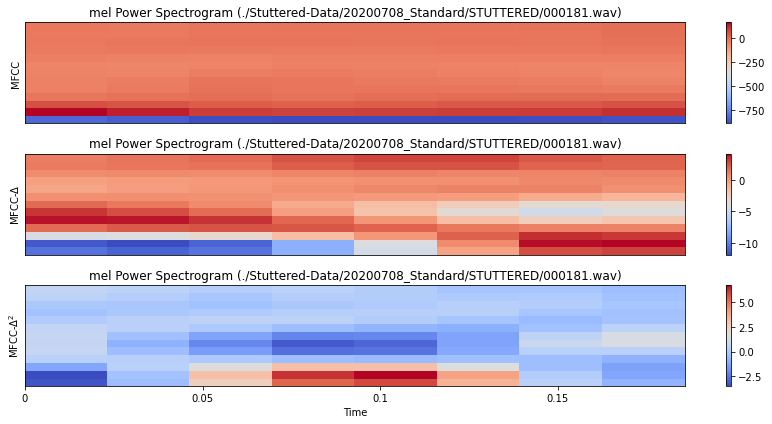

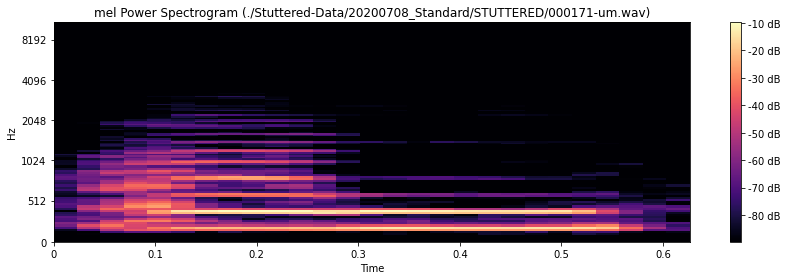

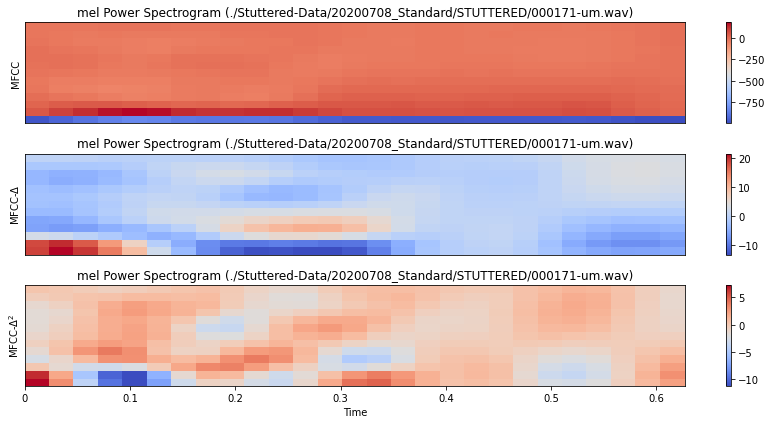

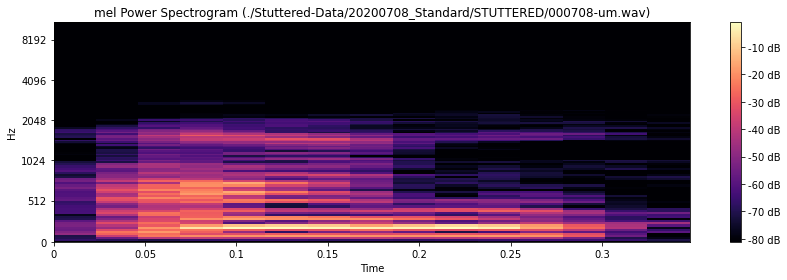

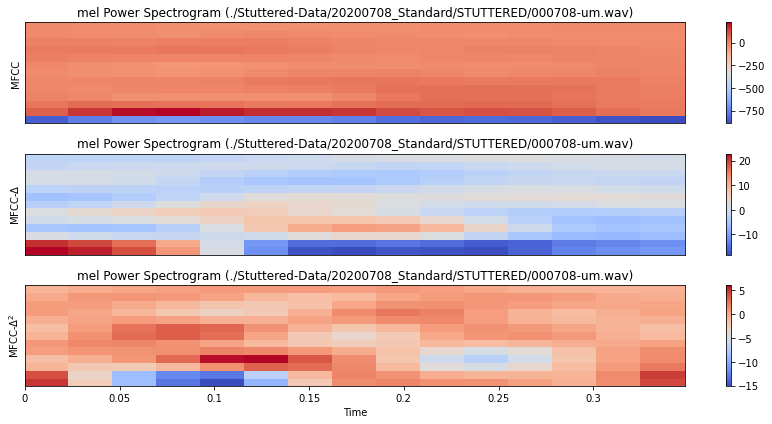

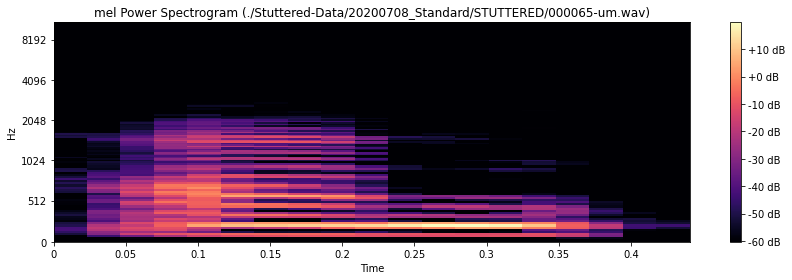

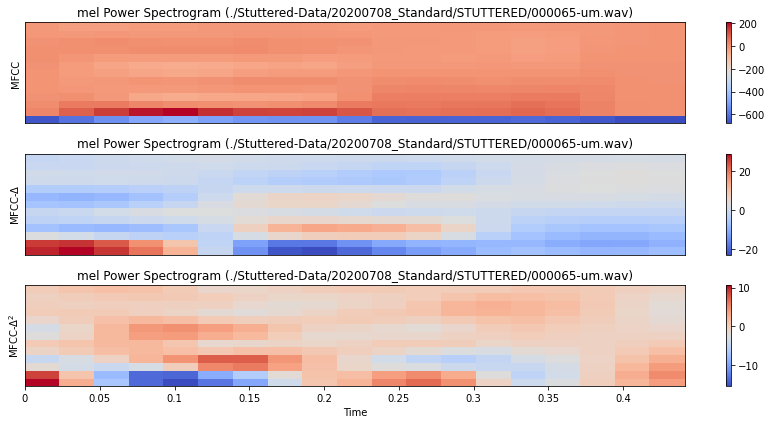

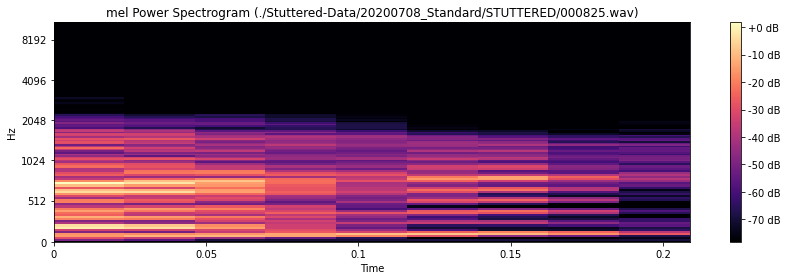

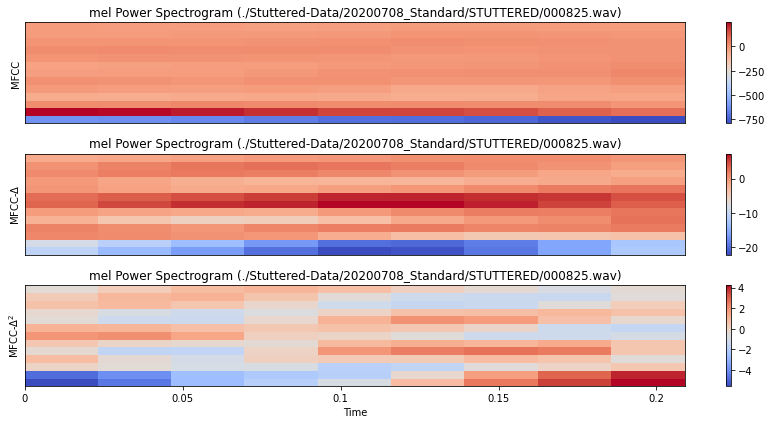

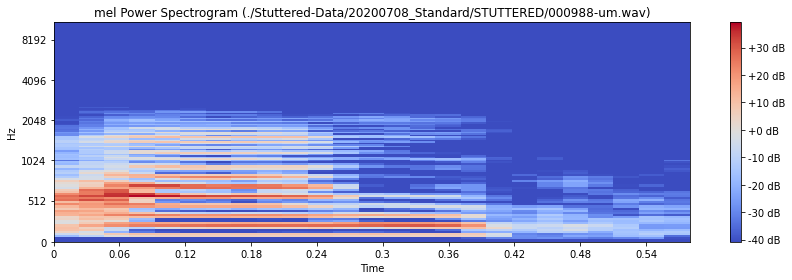

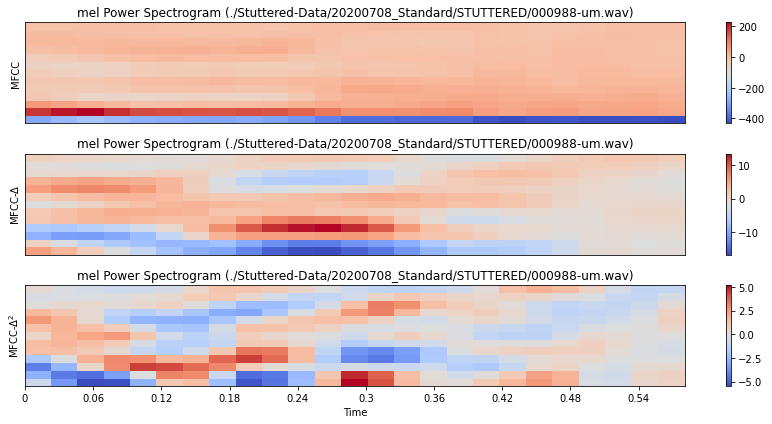

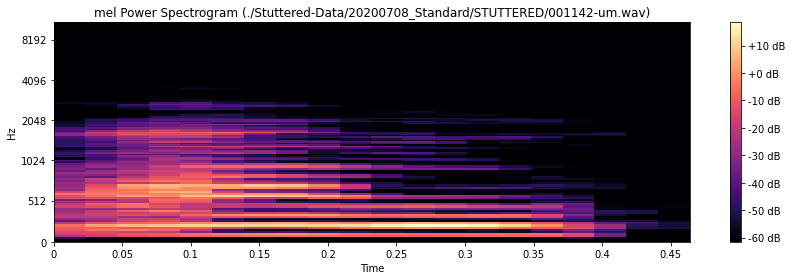

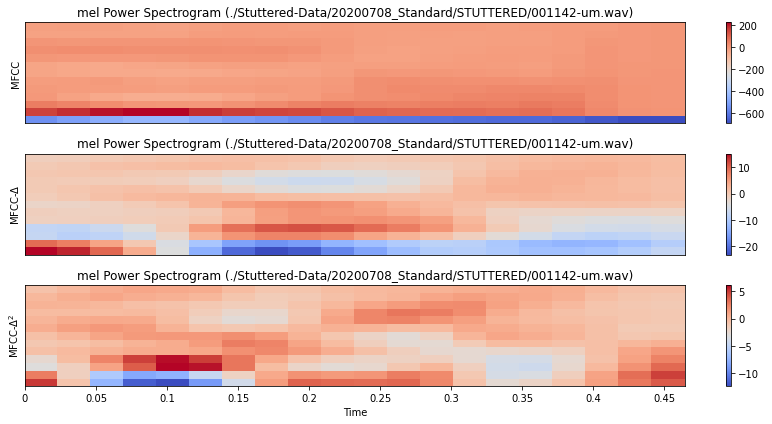

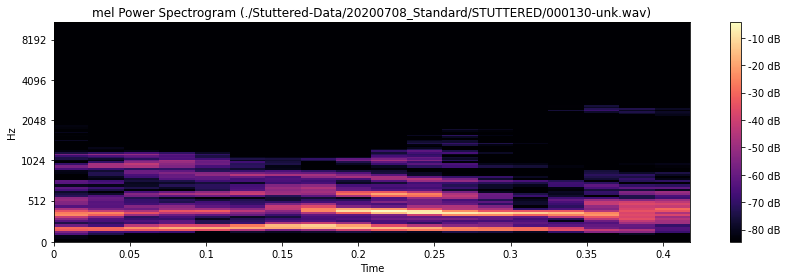

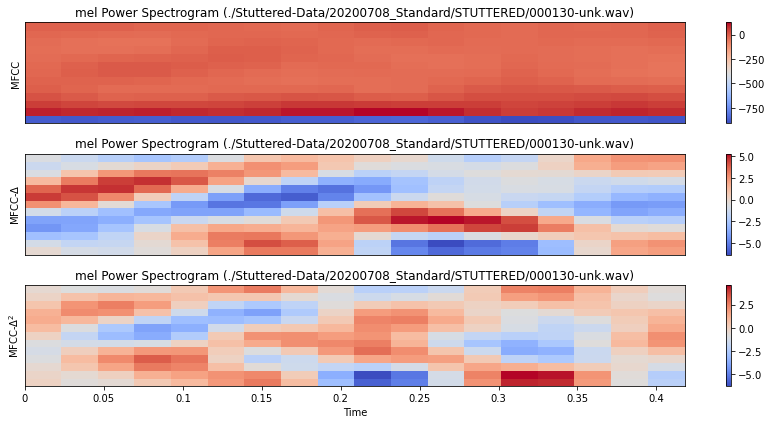

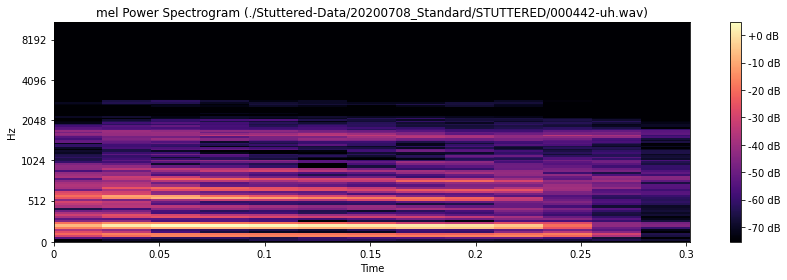

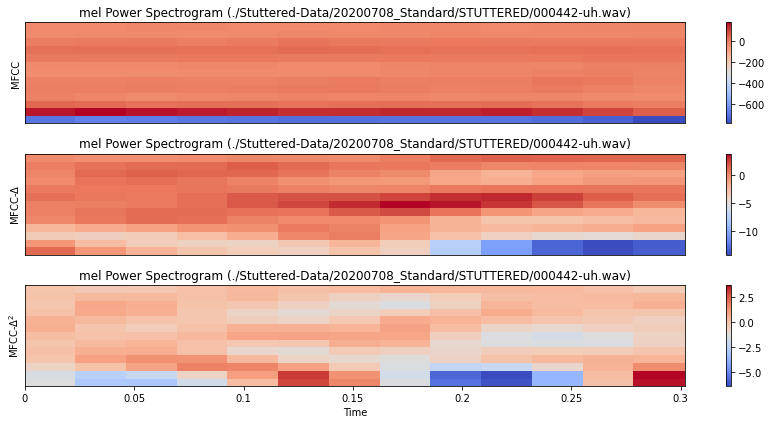

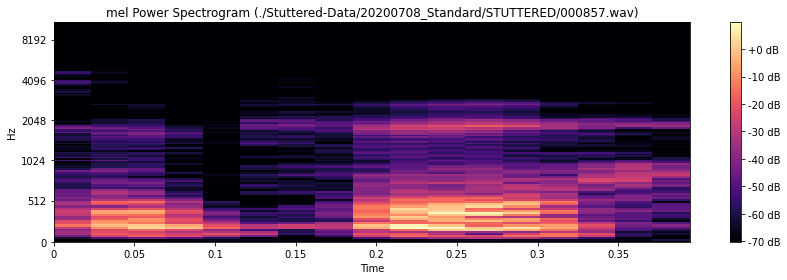

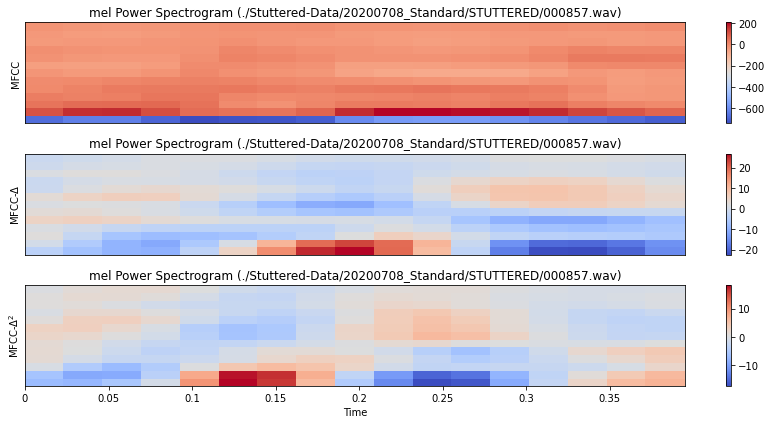

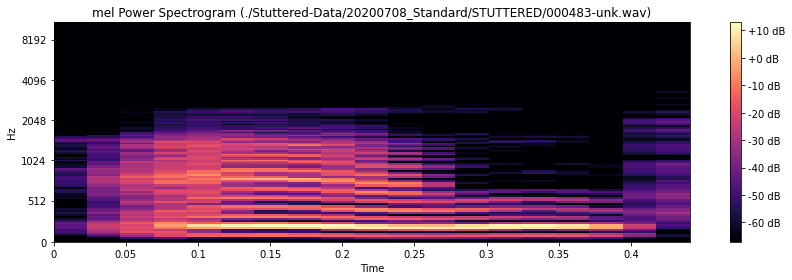

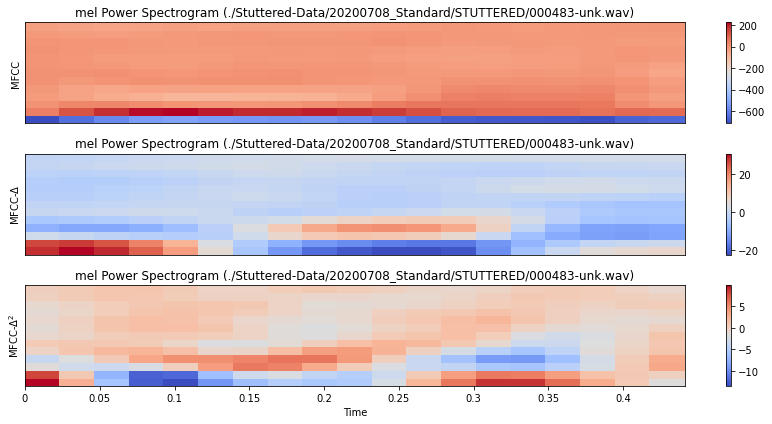

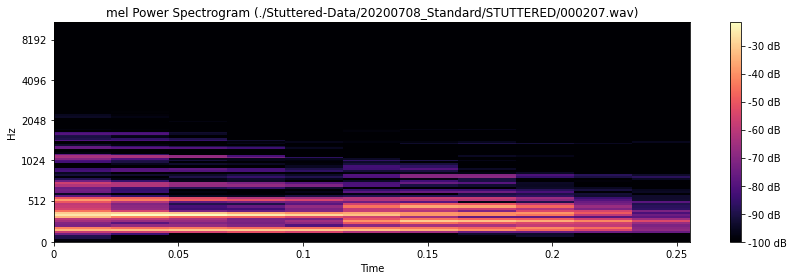

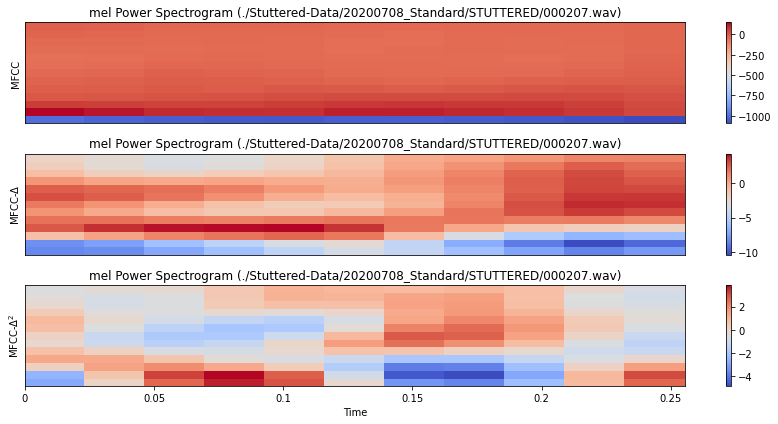

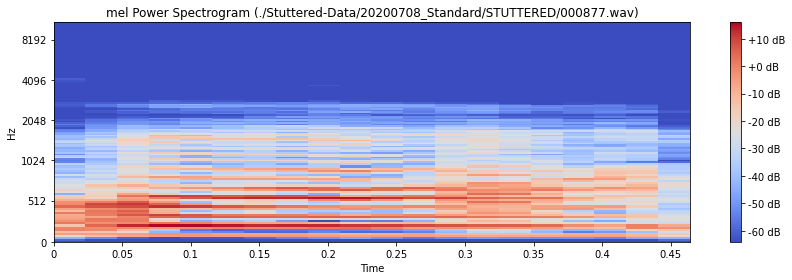

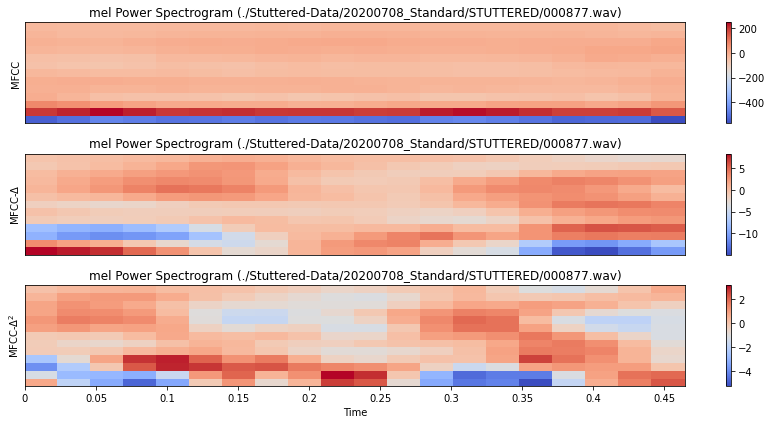

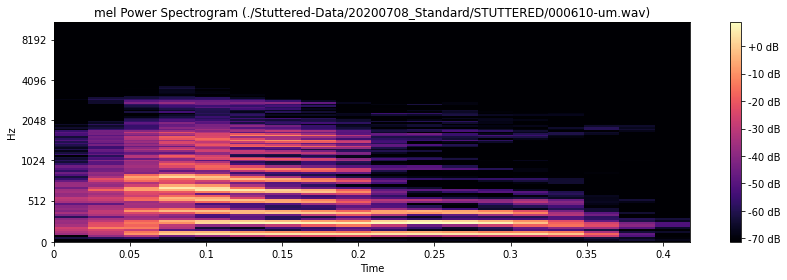

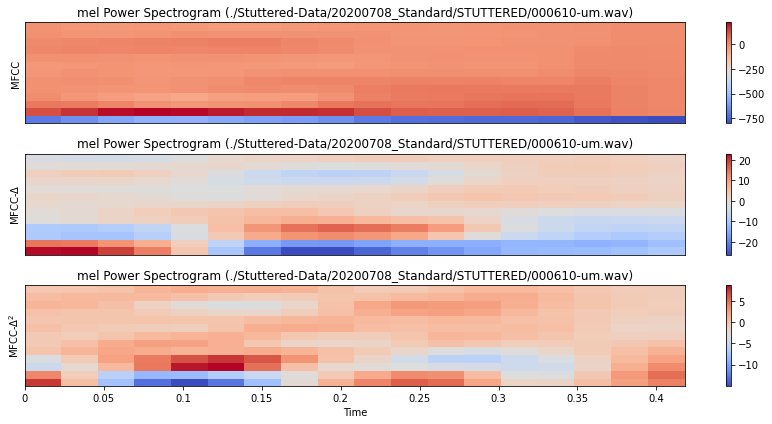

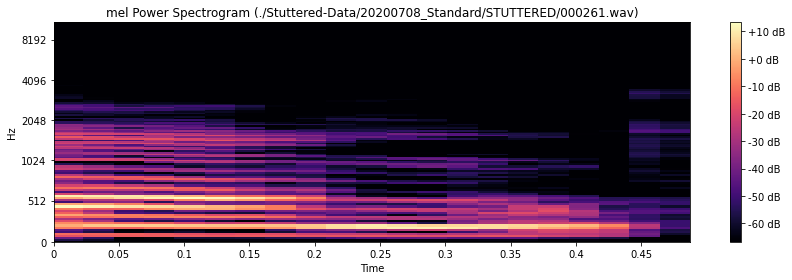

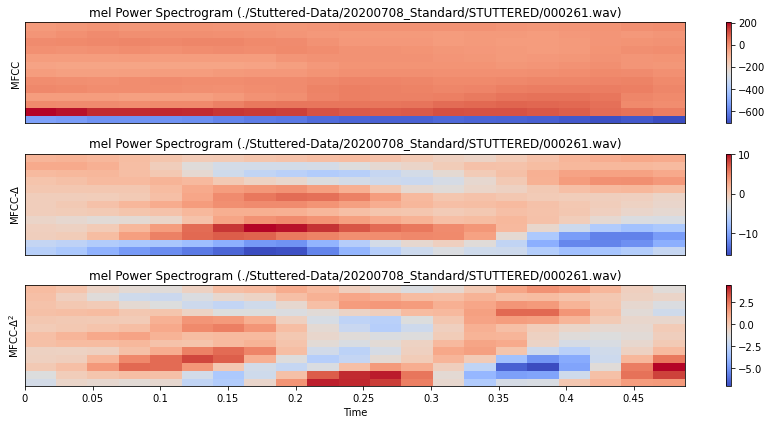

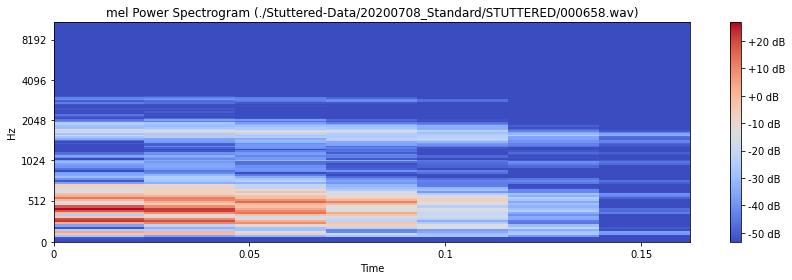

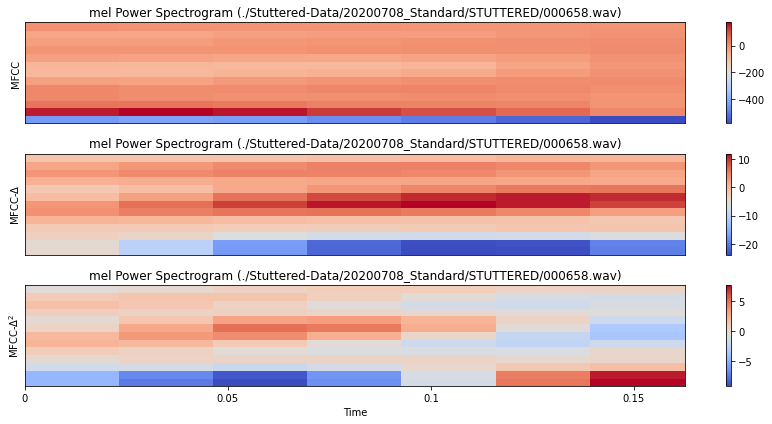

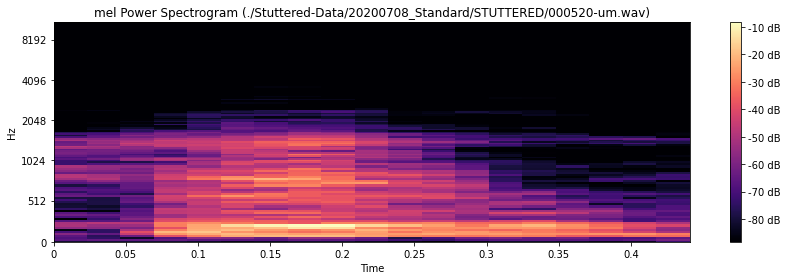

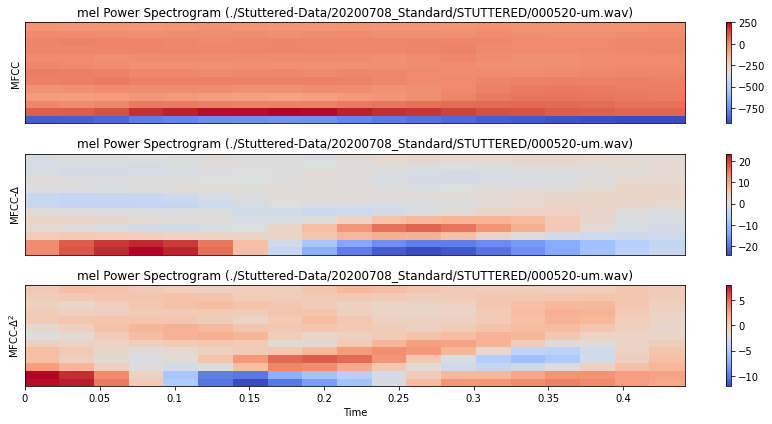

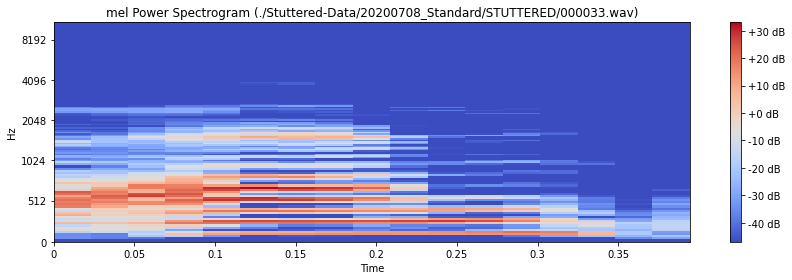

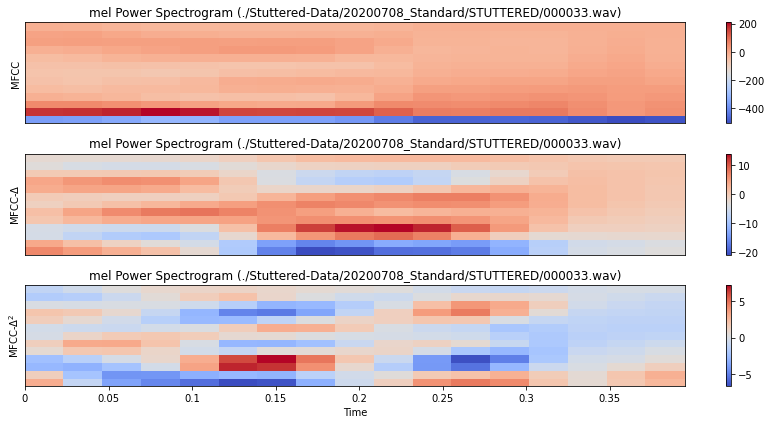

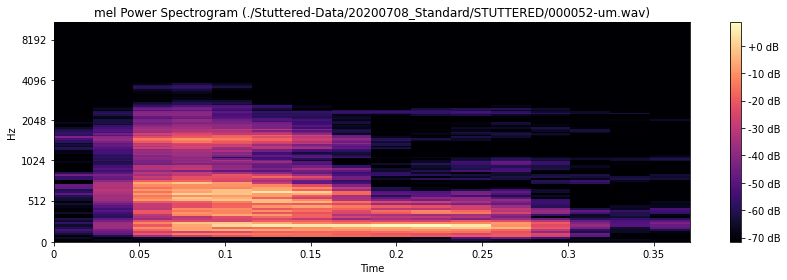

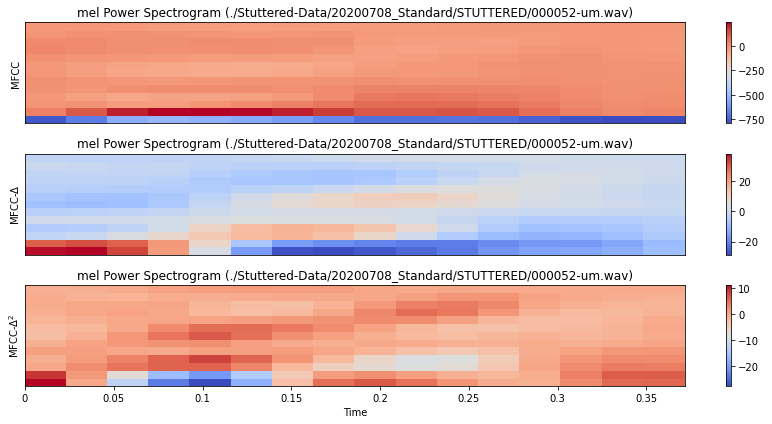

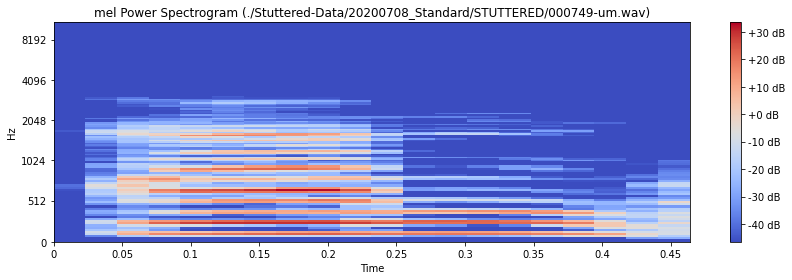

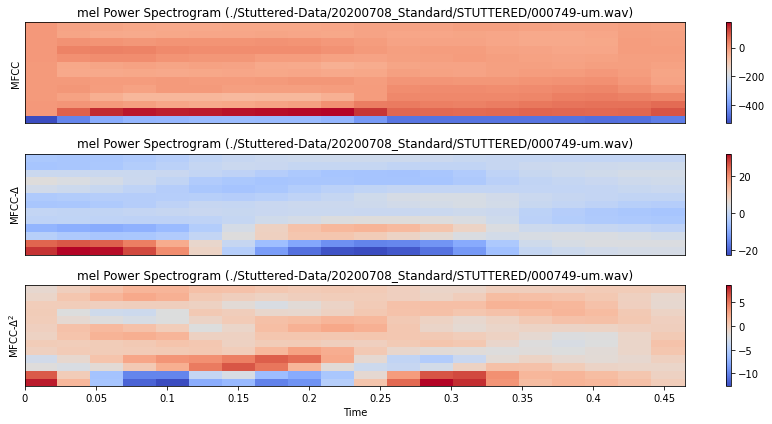

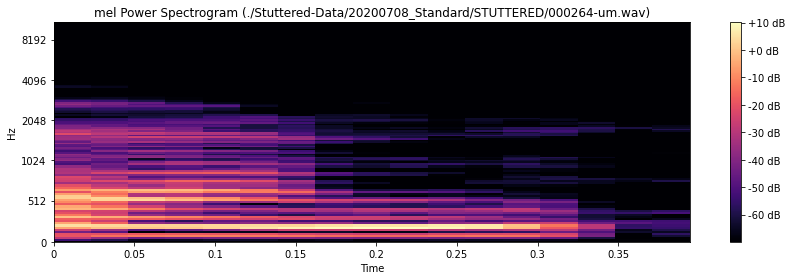

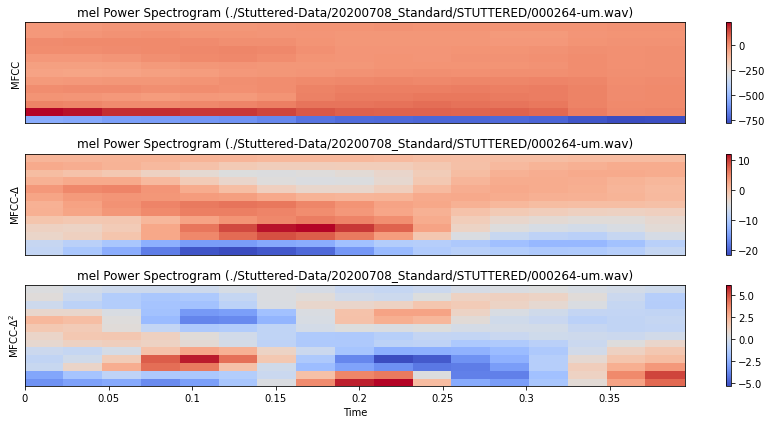

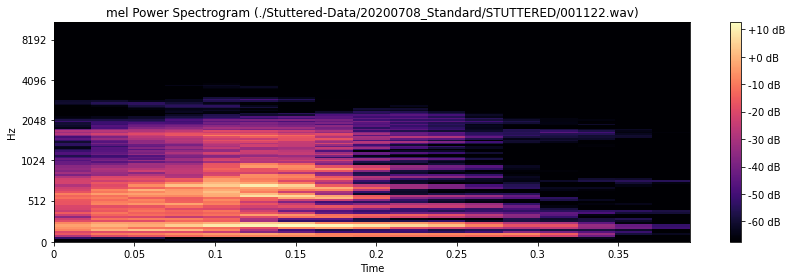

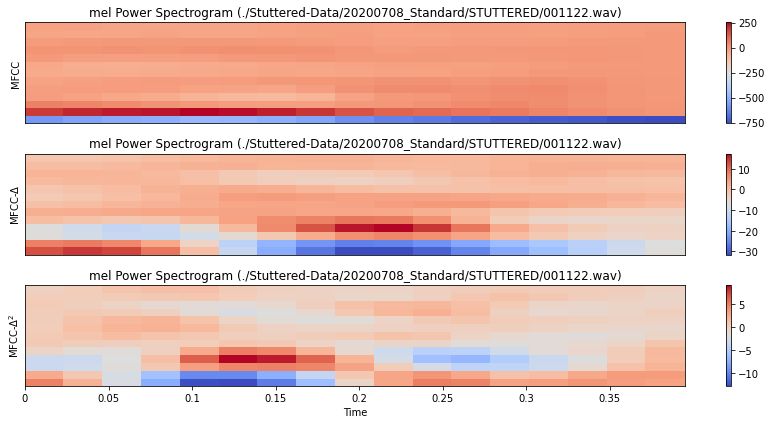

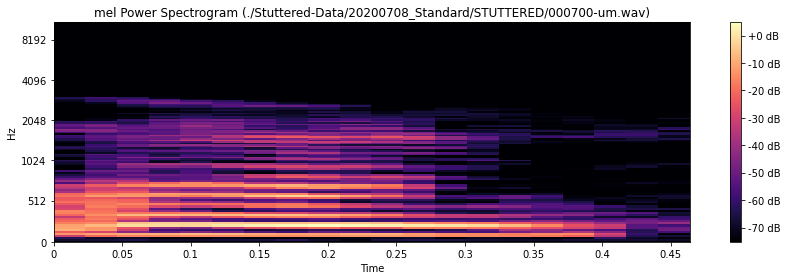

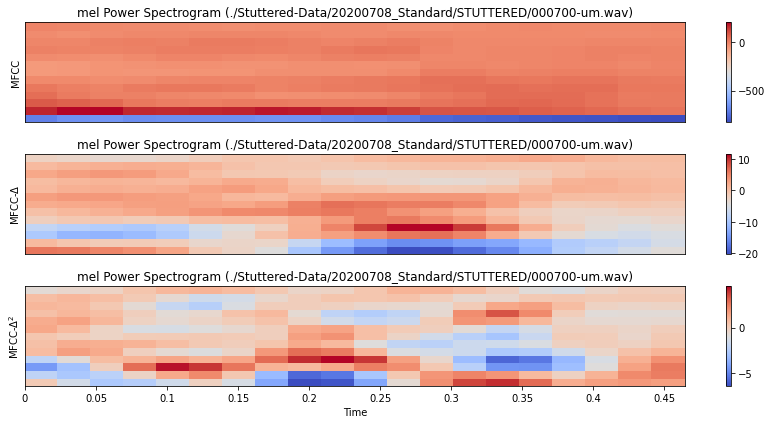

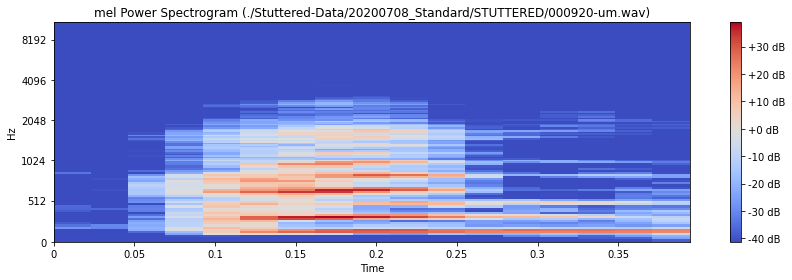

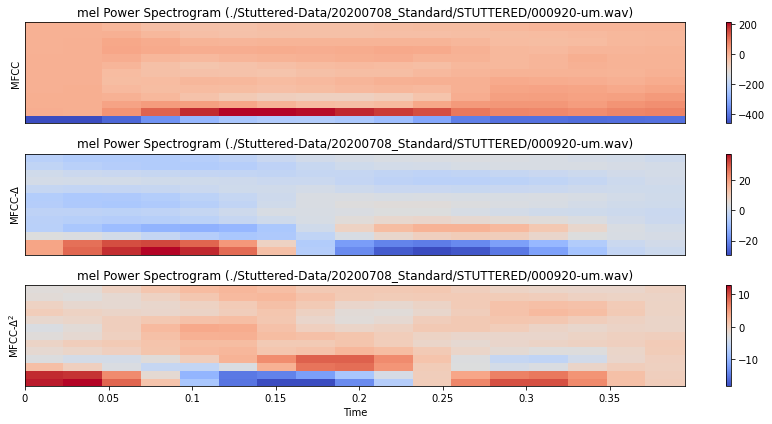

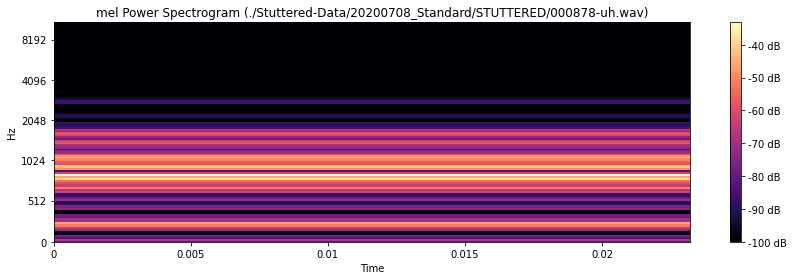

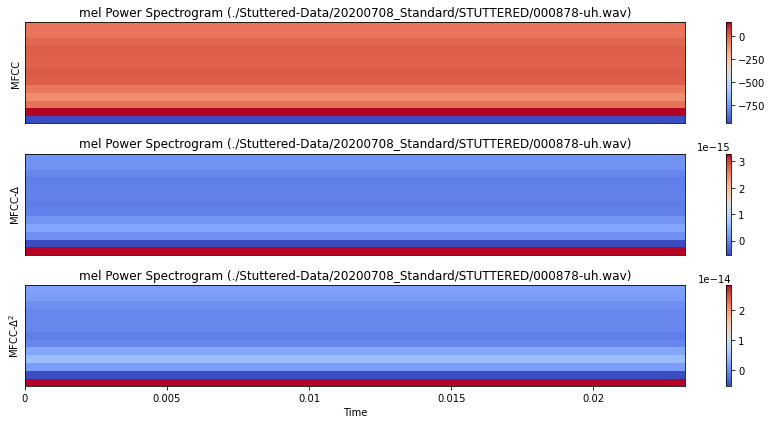

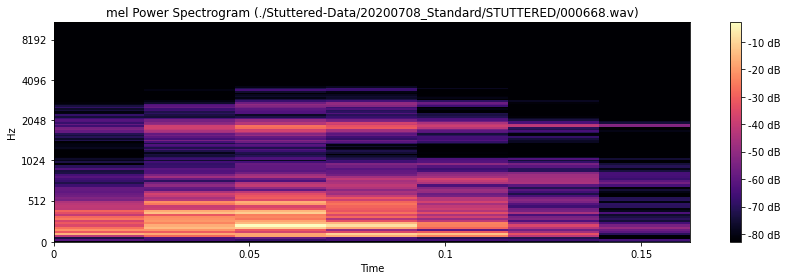

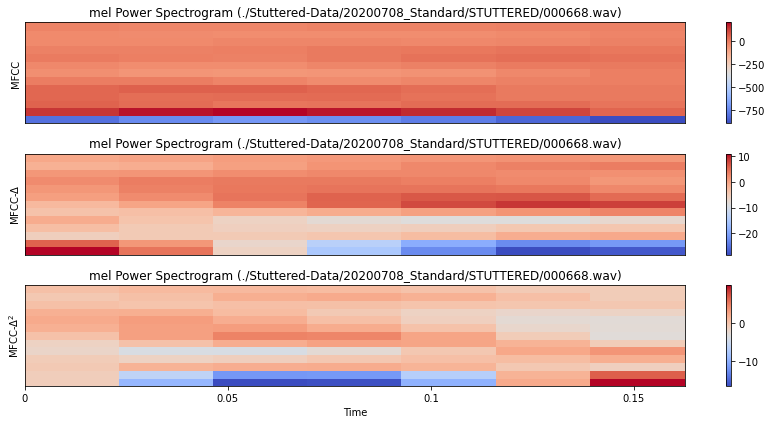

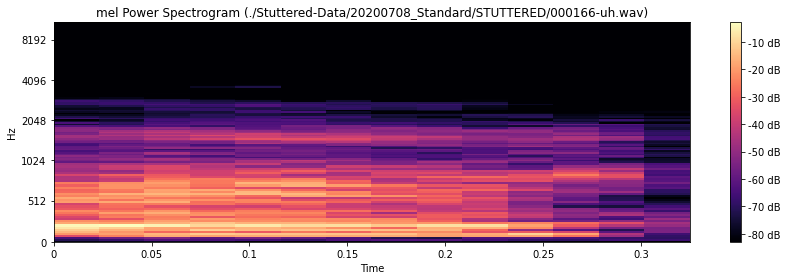

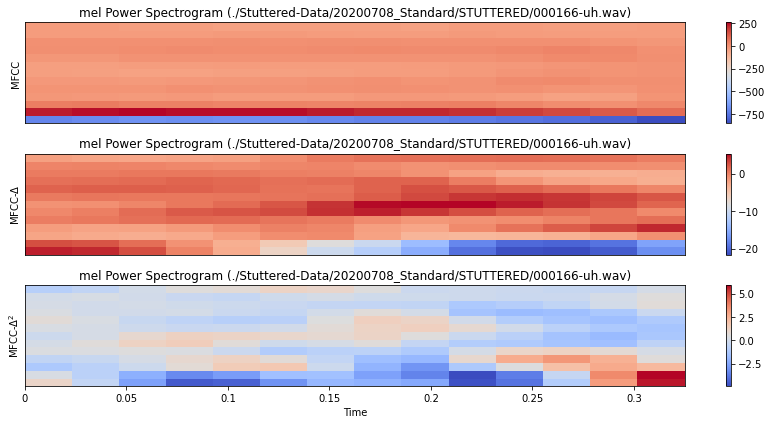

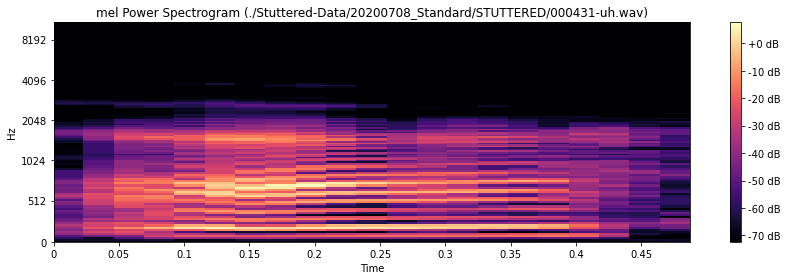

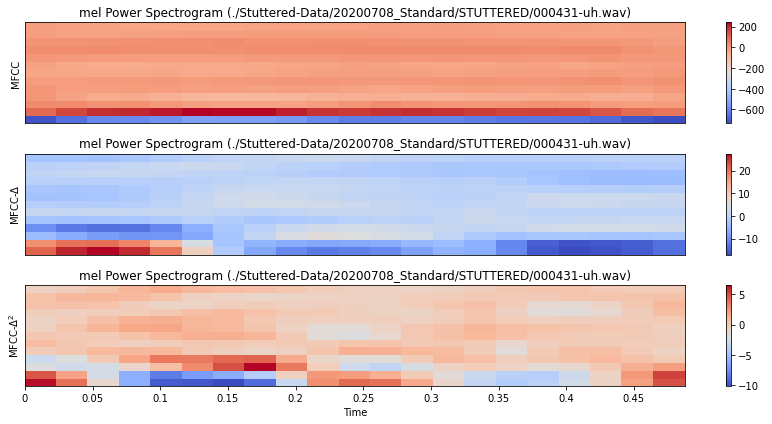

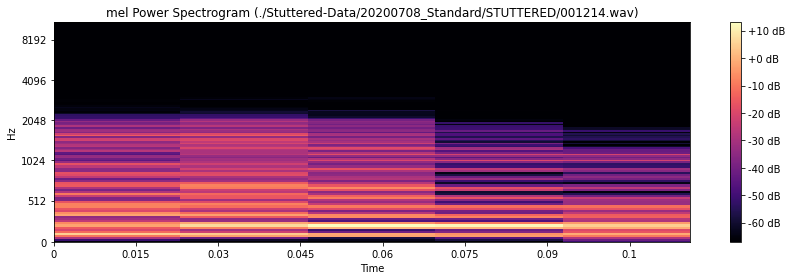

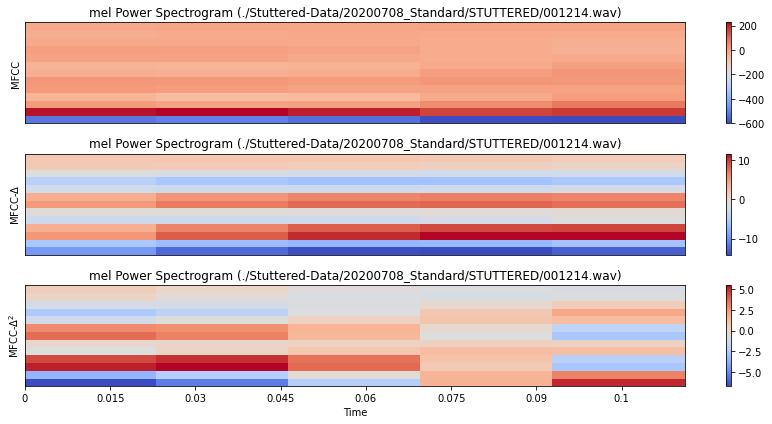

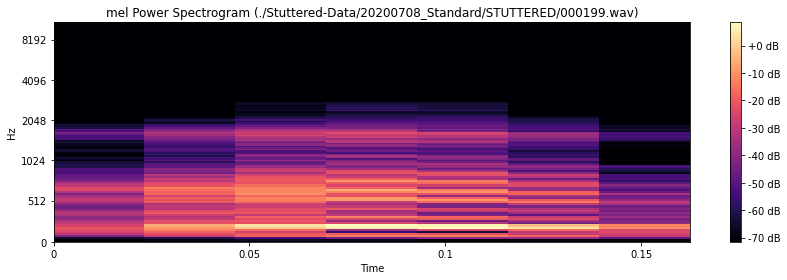

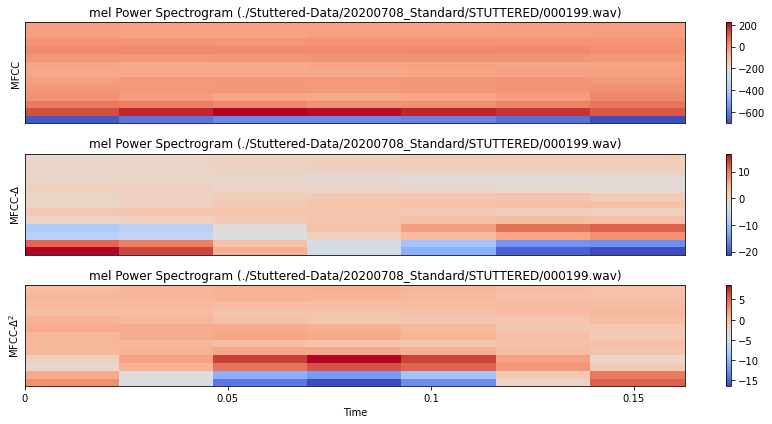

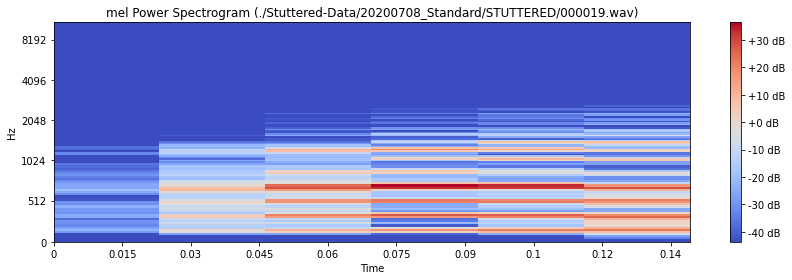

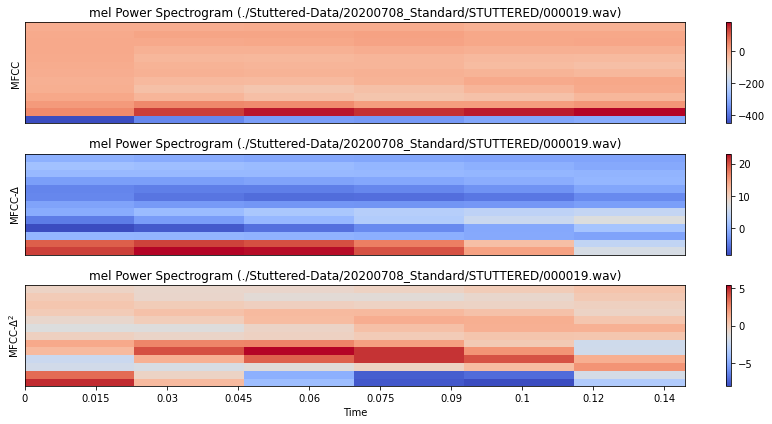

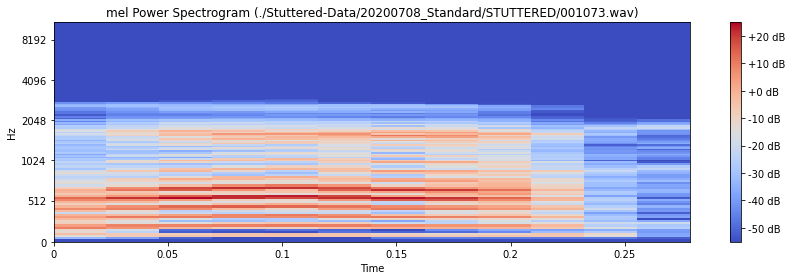

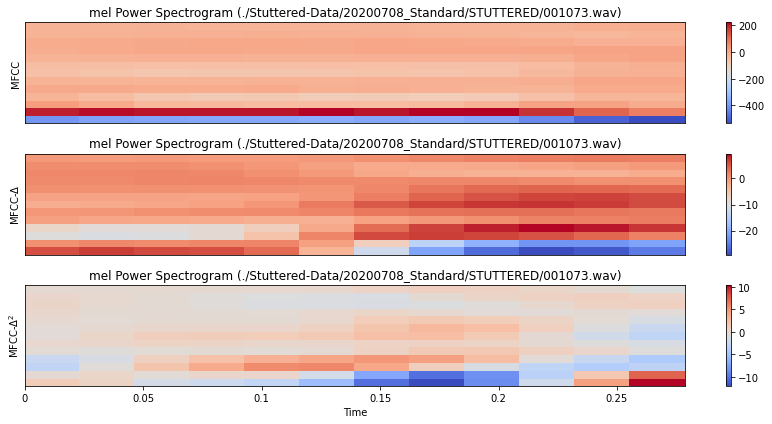

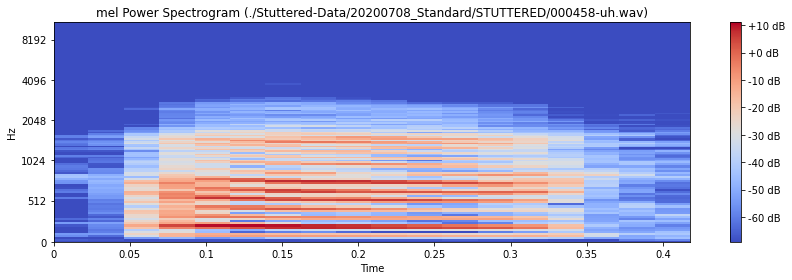

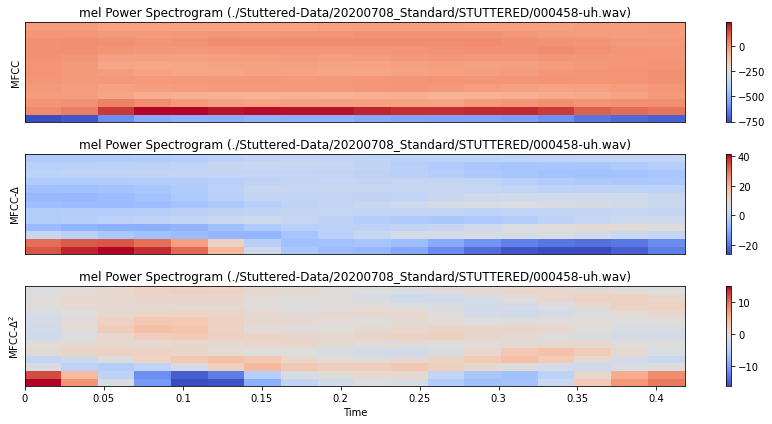

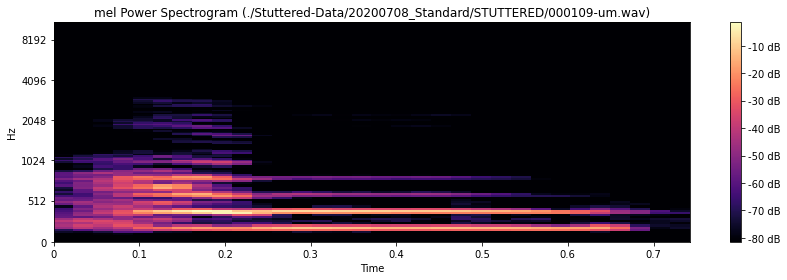

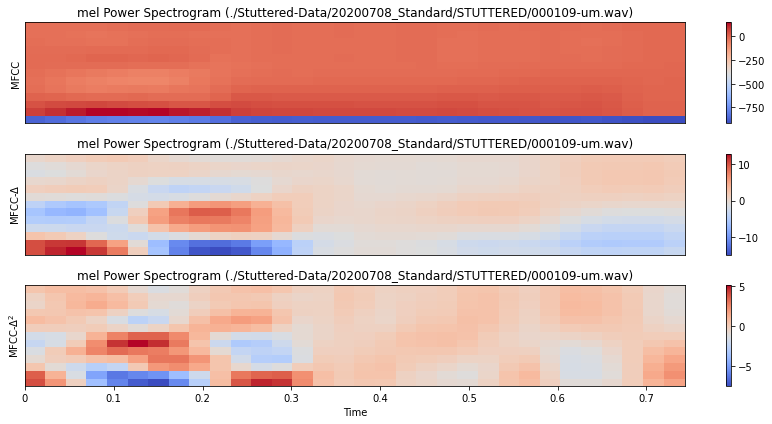

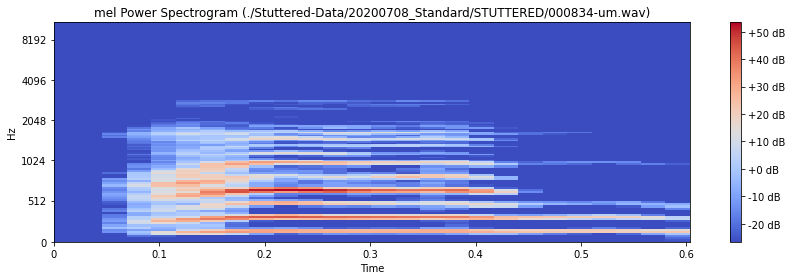

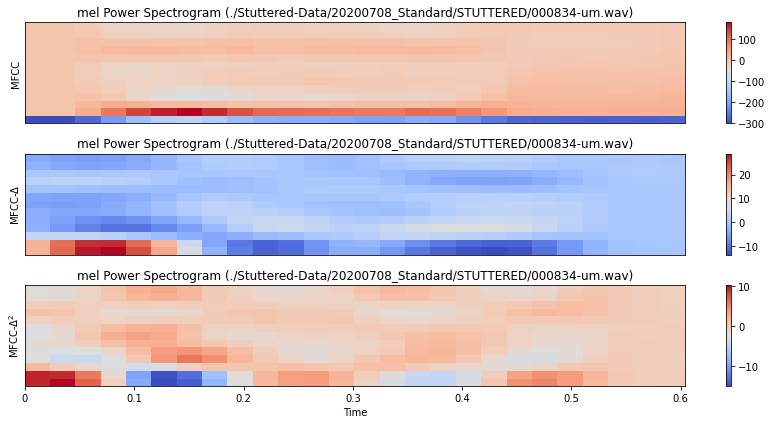

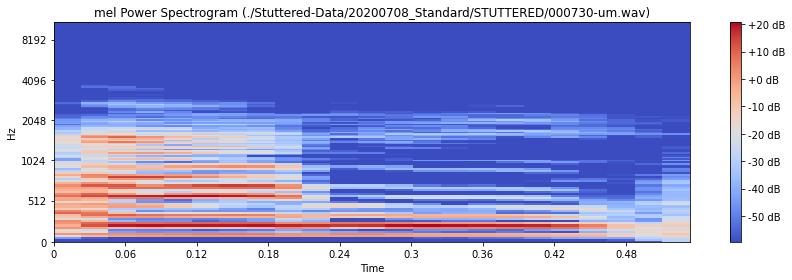

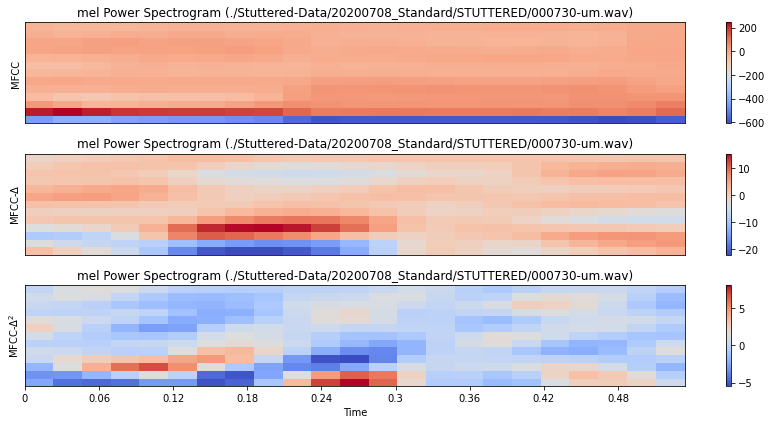

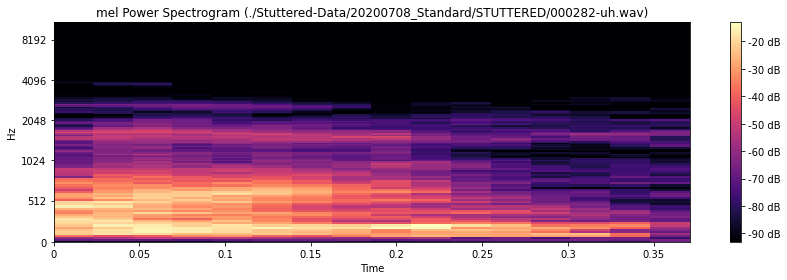

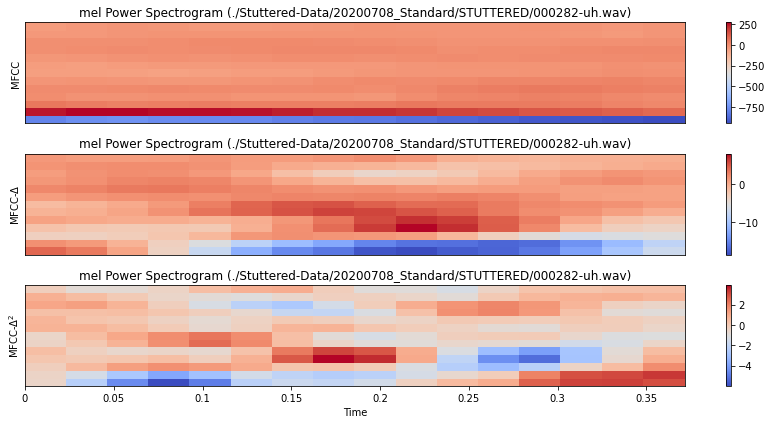

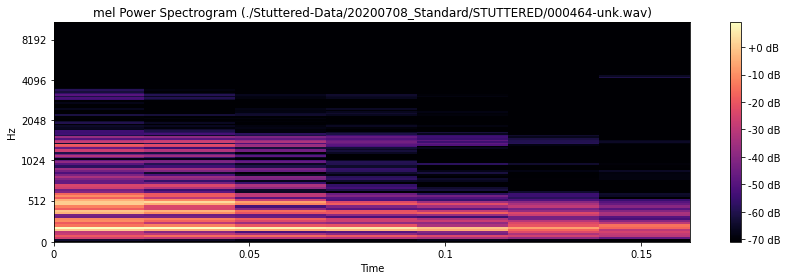

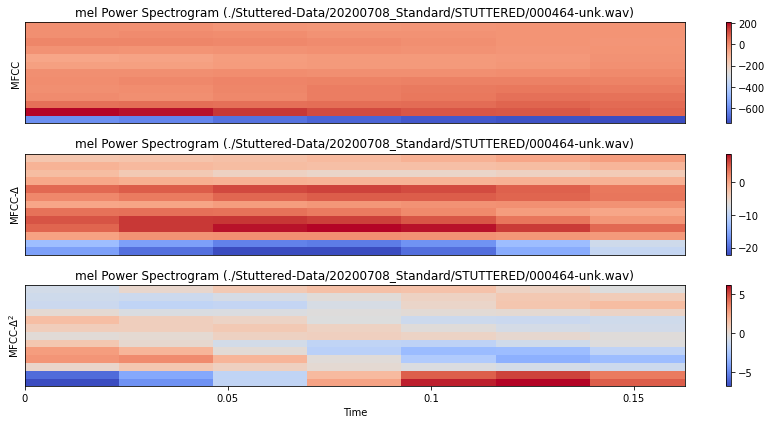

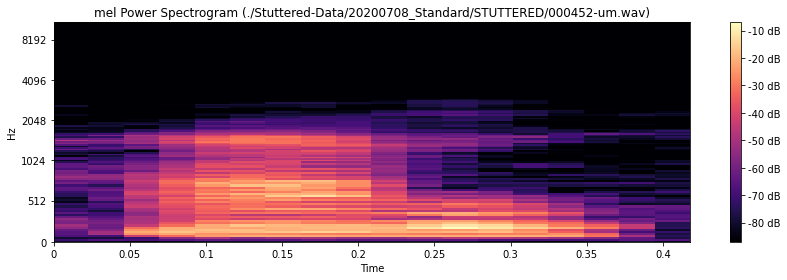

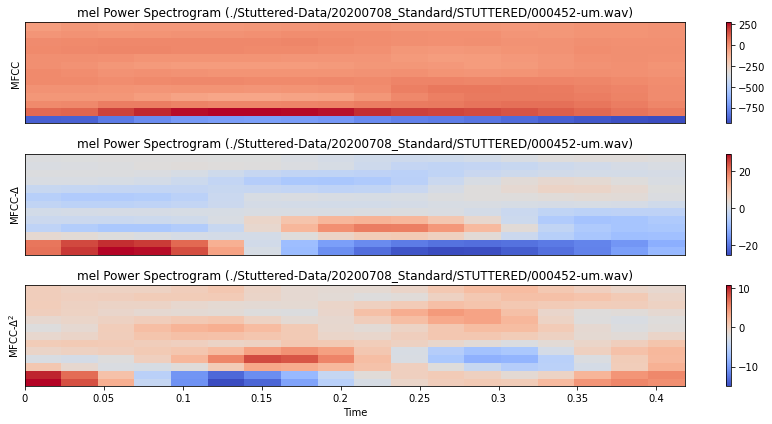

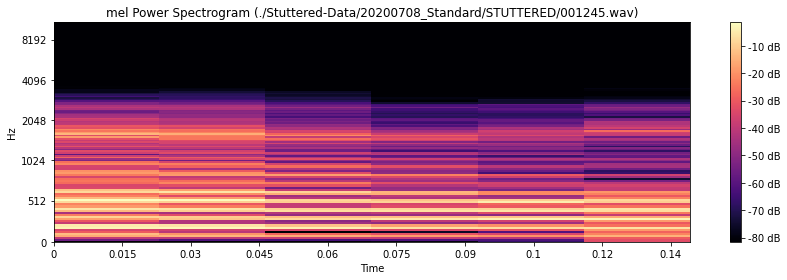

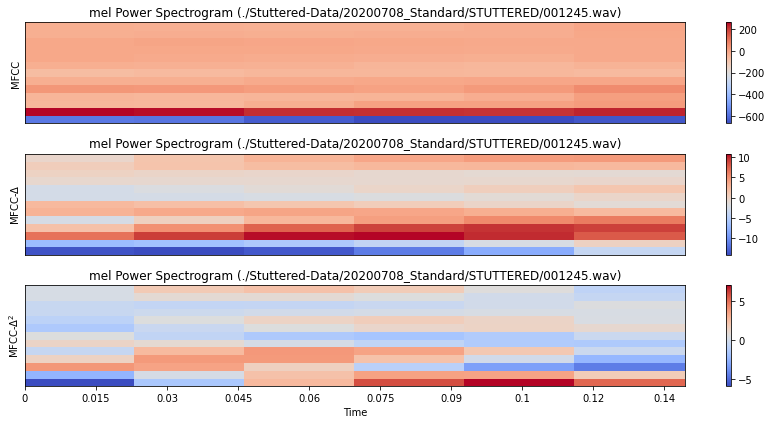

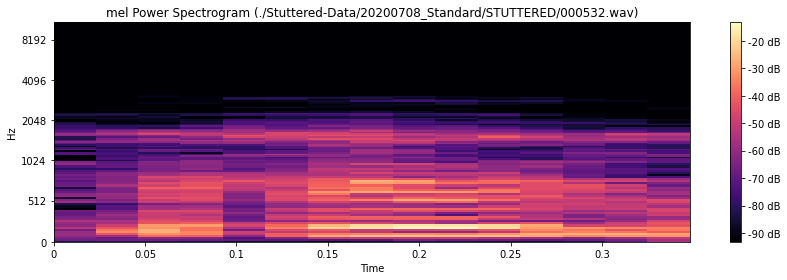

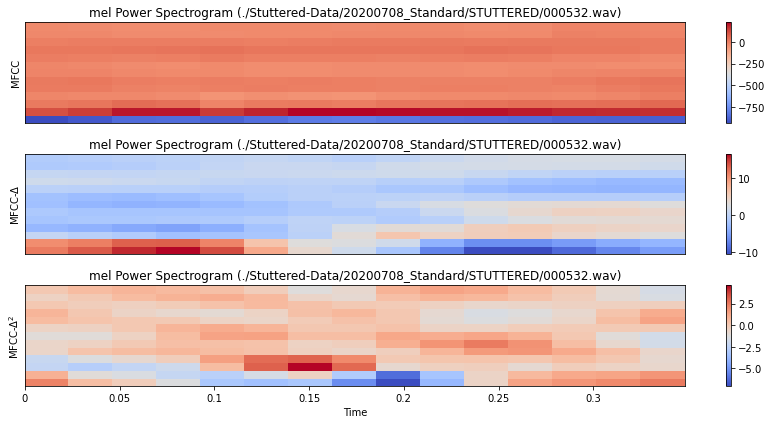

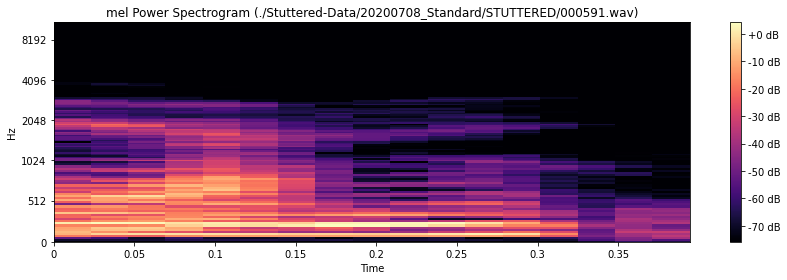

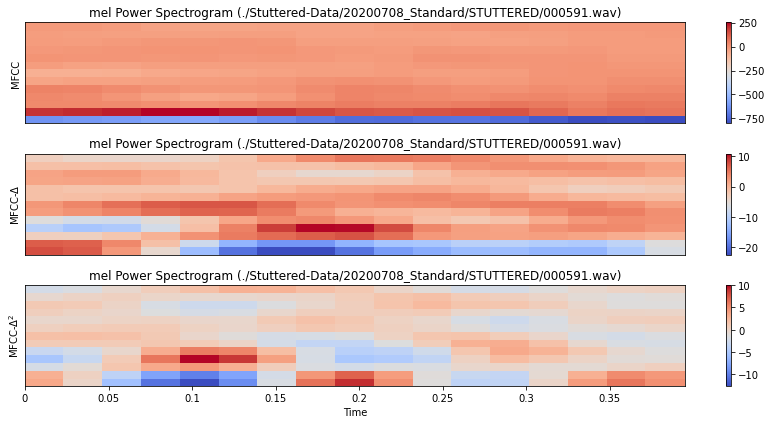

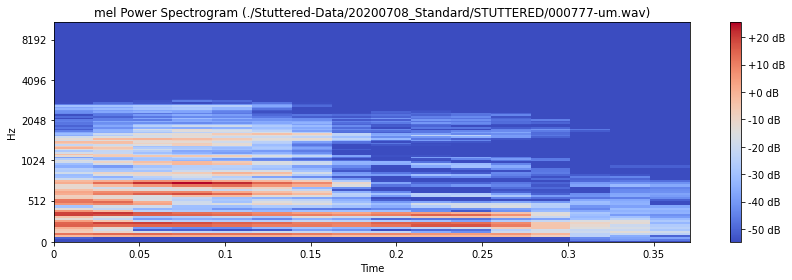

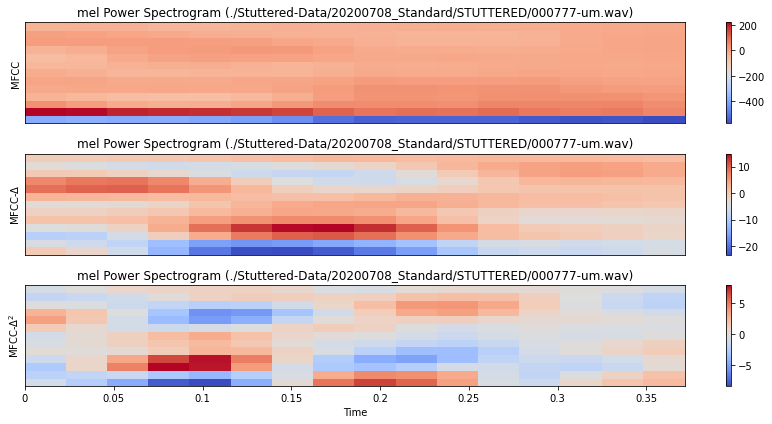

In [39]:
#this is limited to first 10 feature from stuttered audios
#you can change the value of limit
limit = 10
counter = 0
for mfcc_object in tq.tqdm(mfcc_objects):
  if counter == 10:
    break
  mfcc_object.melspectrogram()
  mfcc_object.plotmelspectrogram()
  mfcc_object.extractmfcc()
  mfcc_object.plotmfcc()
  Audio(mfcc_object.filename)

In [0]:
# for index,mfcc_object in zip(range(len(mfcc_objects)),mfcc_objects):
#   print(index)
#   time.sleep(2)
#   mfcc_object.melspectrogram()
#   # mfcc_object.plotmelspectrogram()
#   mfcc_object.extractmfcc()
#   # mfcc_object.plotmfcc()
#   Audio(mfcc_object.filename)